In [1]:
# Import Required Libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dvs_gesture_dataset import (
    DVS346Sign,  # Main dataset class for parsing, binning, and normalization
    parse_aedat,  # Function to parse .aedat files into raw events
    load_labels,  # Function to load gesture labels from CSV files
    bin_events  # Function to bin raw events into temporal spike frames
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Initialize Device
# Set device to MPS or CPU
device = torch.device("cpu")
print(f"Using device: {device}")
# Temporal Integration (MESTOR)
def temporal_binning(events, time_window=10000, resolution=(128, 128)):
    """
    Bin events into temporal windows.
    Args:
        events: np.ndarray (N x 4) [x, y, polarity, timestamp]
        time_window: int, time duration for each bin in microseconds.
    Returns:
        np.ndarray: Binned events as temporal frames.
    """
    max_time = events[:, 3].max()
    num_bins = int(np.ceil(max_time / time_window))
    binned_events = np.zeros((num_bins, resolution[0], resolution[1]), dtype=np.float32)

    for x, y, polarity, timestamp in events:
        bin_idx = int(timestamp // time_window)
        binned_events[bin_idx, int(y), int(x)] += polarity

    return binned_events

Using device: cpu


In [2]:

# Paths and Constants
root_dir = "/Users/uzay/Downloads/DvsGesture"
labels_path = "/Users/uzay/Downloads/DvsGesture"
train_trials_path = "/Users/uzay/Downloads/DvsGesture/trials_to_train.txt"
test_trials_path = "/Users/uzay/Downloads/DvsGesture/trials_to_test.txt"
batch_size = 16
epochs = 10



In [3]:
"""# Debugging DVS346Sign with verbose checks
import os
import torch

print("Testing DVS346Sign dataset initialization and sample generation...")

try:
    # Initialize the dataset with detailed debug
    print("[DEBUG] Initializing DVS346Sign...")
    dvs_dataset = DVS346Sign(root_dir, labels_path, max_bins=100)

    if len(dvs_dataset) == 0:
        print("[ERROR] DVS346Sign dataset is empty. Investigating why...")

        # Manually check the dataset initialization logic
        for file_name in os.listdir(root_dir):
            if file_name.endswith(".aedat"):
                aedat_file = os.path.join(root_dir, file_name)
                label_file = os.path.join(labels_path, file_name.replace(".aedat", "_labels.csv"))
                print(f"[DEBUG] Checking file: {aedat_file}")

                if not os.path.exists(label_file):
                    print(f"[WARNING] Label file missing for {file_name}. Skipping.")
                    continue

                # Debug parse_aedat
                events = parse_aedat(aedat_file)
                print(f"[DEBUG] Parsed {len(events)} events from {file_name}.")

                # Debug load_labels
                gestures = load_labels(label_file)
                print(f"[DEBUG] Loaded {len(gestures)} gestures from {label_file}.")

                # Check if gestures have valid durations
                for gesture in gestures:
                    start_time = gesture["start_time"]
                    end_time = gesture["end_time"]
                    if end_time <= start_time:
                        print(f"[ERROR] Invalid gesture duration: {gesture}")
                    else:
                        print(f"[INFO] Valid gesture: {gesture}")

                print("[DEBUG] Breaking early to investigate further.")
                break  # Stop after the first file for debugging
    else:
        print(f"[INFO] DVS346Sign dataset initialized with {len(dvs_dataset)} samples.")

        # Test retrieving a few samples
        for i in range(min(len(dvs_dataset), 5)):  # Test the first 5 samples
            try:
                spike_frames, label = dvs_dataset[i]
                print(f"[Sample {i}] Label: {label}, Spike Frames Shape: {spike_frames.shape}")
                print(f"Spike Frames Mean: {spike_frames.mean():.4f}, Std: {spike_frames.std():.4f}")
            except Exception as e:
                print(f"[ERROR] Failed to retrieve sample {i}: {e}")

except Exception as e:
    print(f"[ERROR] Failed to initialize or test DVS346Sign dataset: {e}")"""

'# Debugging DVS346Sign with verbose checks\nimport os\nimport torch\n\nprint("Testing DVS346Sign dataset initialization and sample generation...")\n\ntry:\n    # Initialize the dataset with detailed debug\n    print("[DEBUG] Initializing DVS346Sign...")\n    dvs_dataset = DVS346Sign(root_dir, labels_path, max_bins=100)\n\n    if len(dvs_dataset) == 0:\n        print("[ERROR] DVS346Sign dataset is empty. Investigating why...")\n\n        # Manually check the dataset initialization logic\n        for file_name in os.listdir(root_dir):\n            if file_name.endswith(".aedat"):\n                aedat_file = os.path.join(root_dir, file_name)\n                label_file = os.path.join(labels_path, file_name.replace(".aedat", "_labels.csv"))\n                print(f"[DEBUG] Checking file: {aedat_file}")\n\n                if not os.path.exists(label_file):\n                    print(f"[WARNING] Label file missing for {file_name}. Skipping.")\n                    continue\n\n             

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset

# Define paths
precomputed_dir = os.path.join(root_dir, "precomputed")  # Directory for precomputed .pt files

# Ensure precomputed data exists
def ensure_precomputed_data(root_dir, labels_path, precomputed_dir):
    """
    Precompute gestures with global normalization if not already saved.
    """
    if not os.path.exists(precomputed_dir) or not os.listdir(precomputed_dir):
        print("[INFO] Precomputing gestures with global normalization...")
        dvs_dataset = DVS346Sign(root_dir, labels_path, max_bins=100, precomputed_dir=precomputed_dir)
        print(f"[INFO] Precomputed {len(dvs_dataset.samples)} gestures.")
    else:
        print("[INFO] Precomputed data already exists.")

# Ensure data is precomputed
ensure_precomputed_data(root_dir, labels_path, precomputed_dir)

# Dataset class for precomputed data
class PrecomputedDataset(Dataset):
    def __init__(self, precomputed_dir):
        """
        Dataset for loading precomputed spike frames.
        Args:
            precomputed_dir (str): Directory containing precomputed .pt files.
        """
        self.samples = [
            os.path.join(precomputed_dir, f)
            for f in os.listdir(precomputed_dir)
            if f.endswith(".pt")
        ]
        print(f"[INFO] Found {len(self.samples)} precomputed samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        data = torch.load(file_path)
        
        # Extract spike_frames and label from the dictionary
        spike_frames = torch.tensor(data["spike_frames"], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = data["label"]
        
        return spike_frames, label

# Load precomputed datasets
train_dataset = PrecomputedDataset(precomputed_dir)
test_dataset = PrecomputedDataset(precomputed_dir)

# Debugging subsets for reduced dataset size
train_subset = Subset(train_dataset, range(min(len(train_dataset), 100)))  # Use first 100 samples
test_subset = Subset(test_dataset, range(min(len(test_dataset), 50)))  # Use first 50 samples

# DataLoader configurations
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Logging dataset info
print(f"Training dataset loaded with {len(train_dataset)} samples.")
print(f"Testing dataset loaded with {len(test_dataset)} samples.")

[INFO] Precomputed data already exists.
[INFO] Found 1342 precomputed samples.
[INFO] Found 1342 precomputed samples.
Training dataset loaded with 1342 samples.
Testing dataset loaded with 1342 samples.


In [5]:

if __name__ == "__main__":
    import multiprocessing
    multiprocessing.set_start_method("fork")  # Use "fork" instead of "spawn"


# Load DataLoaders
# Load Training and Testing Dataset with Optimized DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Minimal workers
    #pin_memory=True,
    #persistent_workers=True,  # Avoid excessive preloading
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Minimal workers
    #pin_memory=True,
    #persistent_workers=True,  # Avoid excessive preloading
)

In [6]:
# Check the size of the original datasets
train_size = len(train_dataset)
test_size = len(test_dataset)

print(f"Original Training Dataset Size: {train_size}")
print(f"Original Testing Dataset Size: {test_size}")

Original Training Dataset Size: 1342
Original Testing Dataset Size: 1342


In [7]:
import matplotlib.pyplot as plt
from collections import Counter
"""
# Inspect the Dataset
print("Inspecting Dataset...")
for i in range(3):  # Inspect first 3 samples
    raw_events, raw_labels = train_dataset[i]
    print(f"Sample {i} - Raw Events Shape: {raw_events.shape}, Labels: {raw_labels}")
    for label in raw_labels:
        print(f"  Gesture Class: {label['class']}, Start Time: {label['start_time']}, End Time: {label['end_time']}")

# Fetch and Analyze a Batch
spike_frames, labels = next(iter(train_loader))
print(f"Batch Shape: Spike Frames: {spike_frames.shape}, Labels: {labels.shape}")
print(f"Spike Frames - Mean: {spike_frames.mean():.4f}, Std: {spike_frames.std():.4f}")
print(f"Unique Labels in Batch: {labels.unique()}")

# Debug Preprocessing
spike_frames = spike_frames[:, :, :50, :, :]  # Temporal reduction
print(f"After Temporal Reduction - Shape: {spike_frames.shape}")
spike_frames = spike_frames.sum(dim=1, keepdim=True)  # Sum across gestures
print(f"After Summation - Shape: {spike_frames.shape}")
depth = spike_frames.size(2)
spike_frames = spike_frames.reshape(spike_frames.size(0), 1, depth, spike_frames.size(3), spike_frames.size(4))
print(f"After Reshaping - Shape: {spike_frames.shape}")

# Verify Temporal Ranges in Labels
for batch_labels in train_loader:
    for i, label_set in enumerate(batch_labels):
        print(f"Batch {i} - Label Temporal Ranges:")
        for label in label_set:
            print(f"  Gesture Class: {label['class']}, Start Time: {label['start_time']}, End Time: {label['end_time']}")

# Adjust and Verify Label Range
labels = labels[:, 0] - 1  # Adjust labels to [0..10]
print(f"Adjusted Labels: {labels}")
print(f"Unique Adjusted Labels: {labels.unique()}")

# Visualize a Spike Frame
sample_frame = spike_frames[0, 0, :, :, :]  # First sample, first channel
time_step = 10  # Choose a time step to visualize
plt.imshow(sample_frame[time_step].numpy(), cmap='gray')
plt.title(f"Spike Frame at Time Step {time_step}")
plt.colorbar()
plt.show()

# Class Distribution in Training Data
label_counts = Counter()
for _, batch_labels in train_loader:
    adjusted_labels = (batch_labels[:, 0] - 1).tolist()
    label_counts.update(adjusted_labels)
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Class (Gesture)")
plt.ylabel("Count")
plt.title("Class Distribution in Training Dataset")
plt.show()

# Debugging Single Sample
print("Debugging Single Sample...")
single_spike_frames, single_labels = train_dataset[0]
print(f"Single Sample - Shape: {single_spike_frames.shape}, Labels: {single_labels}")
for label in single_labels:
    print(f"  Gesture Class: {label['class']}, Start Time: {label['start_time']}, End Time: {label['end_time']}")
single_spike_frames = single_spike_frames.sum(dim=1, keepdim=True)
depth = single_spike_frames.size(1)
single_spike_frames = single_spike_frames.reshape(1, 1, depth, single_spike_frames.size(2), single_spike_frames.size(3))
print(f"Processed Single Sample - Shape: {single_spike_frames.shape}")
"""

'\n# Inspect the Dataset\nprint("Inspecting Dataset...")\nfor i in range(3):  # Inspect first 3 samples\n    raw_events, raw_labels = train_dataset[i]\n    print(f"Sample {i} - Raw Events Shape: {raw_events.shape}, Labels: {raw_labels}")\n    for label in raw_labels:\n        print(f"  Gesture Class: {label[\'class\']}, Start Time: {label[\'start_time\']}, End Time: {label[\'end_time\']}")\n\n# Fetch and Analyze a Batch\nspike_frames, labels = next(iter(train_loader))\nprint(f"Batch Shape: Spike Frames: {spike_frames.shape}, Labels: {labels.shape}")\nprint(f"Spike Frames - Mean: {spike_frames.mean():.4f}, Std: {spike_frames.std():.4f}")\nprint(f"Unique Labels in Batch: {labels.unique()}")\n\n# Debug Preprocessing\nspike_frames = spike_frames[:, :, :50, :, :]  # Temporal reduction\nprint(f"After Temporal Reduction - Shape: {spike_frames.shape}")\nspike_frames = spike_frames.sum(dim=1, keepdim=True)  # Sum across gestures\nprint(f"After Summation - Shape: {spike_frames.shape}")\ndepth = 

In [8]:
import torch
import torch.nn as nn

###########################################
# Few-Spikes Neuron (FSN) Utilities
###########################################
class ActFun(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.where(input >= 0, torch.ones_like(input), torch.zeros_like(input))

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        lens = 0.5
        temp = (torch.abs(input) < lens) * (0.5 / lens)
        return grad_output * temp.float()

# Spiking activation
act_fun = ActFun.apply

def fs_mem_update(ops, x, mem, decay):
    mem = mem + ops(x) * decay
    return mem

def fs_coding(mem, decay, threshold):
    spike = act_fun(mem - threshold)
    mem = mem - decay * spike
    return mem, spike

###########################################
# Fixed-Shape FSN Model
###########################################
class FSN(nn.Module):
    """
    Spiking NN with 4 Conv3D layers + spiking logic.
    Each layer uses MaxPool3d(kernel_size=(1,2,2)), so
    the time dimension T remains the same, but H/W halves each time.

    We fix T=50 globally. Final shape after 4 pools => [B, 128, 50, 8, 8].
    Flatten = 128 * 50 * 8 * 8 = 409600 => fc1: Linear(409600, 128).
    """
    def __init__(self):
        super(FSN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)

        # Spiking parameters
        self.decay = 0.7
        self.threshold = 0.2

        # 3D Pooling (time dimension not pooled, kernel_size=(1,2,2))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # FIXED: After 4x pooling in space, final is [B,128,T=50,8,8]
        # Flatten => 128 * 50 * 8 * 8 = 409600
        flattened_size = 128 * 50 * 8 * 8
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 11)  # 11 gestures

    def forward(self, x):
        decay, threshold = self.decay, self.threshold

        # 1st conv + spiking
        conv1_out = self.conv1(x)
        mem1 = torch.zeros_like(conv1_out, device=x.device)
        mem1 = fs_mem_update(lambda z: z, conv1_out, mem1, decay)
        mem1, spikes1 = fs_coding(mem1, decay, threshold)
        x = self.pool(spikes1)  # shape => [B,16,T,64,64]
        #print(f"After pool1: {x.shape}")

        # 2nd conv + spiking
        conv2_out = self.conv2(x)
        mem2 = torch.zeros_like(conv2_out, device=x.device)
        mem2 = fs_mem_update(lambda z: z, conv2_out, mem2, decay)
        mem2, spikes2 = fs_coding(mem2, decay, threshold)
        x = self.pool(spikes2)  # [B,32,T,32,32]
        #print(f"After pool2: {x.shape}")

        # 3rd conv + spiking
        conv3_out = self.conv3(x)
        mem3 = torch.zeros_like(conv3_out, device=x.device)
        mem3 = fs_mem_update(lambda z: z, conv3_out, mem3, decay)
        mem3, spikes3 = fs_coding(mem3, decay, threshold)
        x = self.pool(spikes3)  # [B,64,T,16,16]
        #print(f"After pool3: {x.shape}")

        # 4th conv + spiking
        conv4_out = self.conv4(x)
        mem4 = torch.zeros_like(conv4_out, device=x.device)
        mem4 = fs_mem_update(lambda z: z, conv4_out, mem4, decay)
        mem4, spikes4 = fs_coding(mem4, decay, threshold)
        x = self.pool(spikes4)  # [B,128,T,8,8]
        #print(f"After pool4: {x.shape}")

        # Flatten & FC layers
        x = x.view(x.size(0), -1)  # shape => [B, 409600]
        x = torch.relu(self.fc1(x))  # [B,128]
        x = self.fc2(x)             # [B,11]
        return x

model = FSN().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=8e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4, weight_decay=1e-4)

In [9]:
# Training and Testing Loops
epochs = 10
train_accuracies, train_losses = [], []
test_accuracies, test_losses = [], []

In [10]:
import os

# Function to analyze gesture durations
def analyze_gesture_durations(csv_file_path):
    """
    Analyze the durations of gestures in a CSV file.
    Args:
        csv_file_path (str): Path to the CSV file containing gesture metadata.
    Returns:
        List of gesture durations.
    """
    durations = []
    if not os.path.exists(csv_file_path):
        print(f"[ERROR] File not found: {csv_file_path}")
        return durations

    print(f"Analyzing gesture durations in {csv_file_path}...")
    with open(csv_file_path, "r") as f:
        for line in f:
            if line.startswith("class"):
                continue
            parts = line.strip().split(",")
            if len(parts) == 3:
                g_class, start_time, end_time = int(parts[0]), int(parts[1]), int(parts[2])
                duration = end_time - start_time
                durations.append((g_class, duration))
            else:
                print(f"[WARNING] Malformed line: {line}")

    return durations


# Temporary code block to analyze one CSV file
csv_file_path = "/Users/uzay/Downloads/DvsGesture/user17_led_labels.csv"  # Replace with your CSV file
gesture_durations = analyze_gesture_durations(csv_file_path)

if gesture_durations:
    print("\nGesture Durations (end_time - start_time):")
    for g_class, duration in gesture_durations:
        print(f"Gesture {g_class}: {duration / 1e6:.2f} seconds")  # Convert to seconds for readability
else:
    print("[ERROR] No gesture durations found.")

Analyzing gesture durations in /Users/uzay/Downloads/DvsGesture/user17_led_labels.csv...

Gesture Durations (end_time - start_time):
Gesture 1: 5.59 seconds
Gesture 2: 5.71 seconds
Gesture 3: 7.67 seconds
Gesture 4: 6.97 seconds
Gesture 5: 5.73 seconds
Gesture 6: 6.90 seconds
Gesture 7: 7.50 seconds
Gesture 8: 7.15 seconds
Gesture 8: 7.57 seconds
Gesture 9: 8.76 seconds
Gesture 10: 7.50 seconds
Gesture 11: 4.20 seconds


In [11]:
"""# Debugging: Validate data preparation and binning

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Initialize a small subset of the dataset for debugging
debug_dataset = DVS346Sign(root_dir, labels_path, max_bins=10)
debug_loader = DataLoader(debug_dataset, batch_size=1, shuffle=False)

# Loop through a few samples to validate
print("Validating dataset...")
for i, (spike_frames, label) in enumerate(debug_loader):
    print(f"\n[Sample {i + 1}]")
    print(f"Spike frames shape: {spike_frames.shape}")
    print(f"Label: {label.item()}")

    # Debugging the contents of spike_frames
    print(f"Spike frames mean: {spike_frames.mean().item()} std: {spike_frames.std().item()}")

    # Check for empty or zeroed bins
    if spike_frames.mean().item() == 0.0:
        print("[WARNING] All spike frames are zeros. Investigating...")
        frames = spike_frames.squeeze(0).squeeze(0).numpy()  # Remove batch and channel dimensions

        # Check individual time bins
        for t in range(frames.shape[0]):
            bin_mean = frames[t].mean()
            bin_sum = frames[t].sum()
            print(f"  Time bin {t}: Mean = {bin_mean}, Sum = {bin_sum}")
            if bin_sum == 0:
                print(f"  [WARNING] Time bin {t} is empty (sum = 0).")
    else:
        print("[INFO] Spike frames contain valid data.")

    # Debug the events used to create this sample
    gesture_events = debug_dataset.samples[i][0]
    print(f"Number of gesture events: {gesture_events.shape[0]}")
    print(f"Event timestamps range: {gesture_events[:, 3].min()} to {gesture_events[:, 3].max()}")

    # Optionally, visualize a slice of the spike frames
    frame_to_visualize = 0
    plt.imshow(frames[frame_to_visualize], cmap="gray")
    plt.title(f"Spike Frame at Time Bin {frame_to_visualize}")
    plt.colorbar()
    plt.show()

    # Break after checking a few samples
    if i >= 1:
        break
"""

'# Debugging: Validate data preparation and binning\n\nfrom torch.utils.data import DataLoader\nimport matplotlib.pyplot as plt\n\n# Initialize a small subset of the dataset for debugging\ndebug_dataset = DVS346Sign(root_dir, labels_path, max_bins=10)\ndebug_loader = DataLoader(debug_dataset, batch_size=1, shuffle=False)\n\n# Loop through a few samples to validate\nprint("Validating dataset...")\nfor i, (spike_frames, label) in enumerate(debug_loader):\n    print(f"\n[Sample {i + 1}]")\n    print(f"Spike frames shape: {spike_frames.shape}")\n    print(f"Label: {label.item()}")\n\n    # Debugging the contents of spike_frames\n    print(f"Spike frames mean: {spike_frames.mean().item()} std: {spike_frames.std().item()}")\n\n    # Check for empty or zeroed bins\n    if spike_frames.mean().item() == 0.0:\n        print("[WARNING] All spike frames are zeros. Investigating...")\n        frames = spike_frames.squeeze(0).squeeze(0).numpy()  # Remove batch and channel dimensions\n\n        # Che

In [12]:
import torch
import os

def check_precomputed_format(precomputed_dir, num_samples=5):
    """
    Check the format of a few precomputed files.
    Args:
        precomputed_dir (str): Path to the directory containing precomputed files.
        num_samples (int): Number of files to check.
    """
    files = [f for f in os.listdir(precomputed_dir) if f.endswith(".pt")]
    print(f"Found {len(files)} precomputed files.")
    
    for idx, file_name in enumerate(files[:num_samples]):
        file_path = os.path.join(precomputed_dir, file_name)
        data = torch.load(file_path)
        
        print(f"\n[File {idx+1}] {file_name}")
        if isinstance(data, dict):
            print("Format: Dictionary")
            print(f"Keys: {list(data.keys())}")
            if "spike_frames" in data and "label" in data:
                print(f"spike_frames shape: {data['spike_frames'].shape}")
                print(f"label: {data['label']}")
        elif isinstance(data, tuple):
            print("Format: Tuple")
            spike_frames, label = data
            print(f"spike_frames shape: {spike_frames.shape}")
            print(f"label: {label}")
        else:
            print(f"Unexpected format: {type(data)}")
        print("-" * 30)

# Specify your precomputed directory path

# Check the format of the precomputed files
check_precomputed_format(precomputed_dir, num_samples=5)

Found 1342 precomputed files.

[File 1] user26_led.aedat_gesture_7.pt
Format: Dictionary
Keys: ['spike_frames', 'label', 'mean', 'std']
spike_frames shape: (100, 128, 128)
label: 7
------------------------------

[File 2] user07_fluorescent.aedat_gesture_2.pt
Format: Dictionary
Keys: ['spike_frames', 'label', 'mean', 'std']
spike_frames shape: (100, 128, 128)
label: 2
------------------------------

[File 3] user13_natural.aedat_gesture_6.pt
Format: Dictionary
Keys: ['spike_frames', 'label', 'mean', 'std']
spike_frames shape: (100, 128, 128)
label: 6
------------------------------

[File 4] user04_fluorescent_led.aedat_gesture_0.pt
Format: Dictionary
Keys: ['spike_frames', 'label', 'mean', 'std']
spike_frames shape: (100, 128, 128)
label: 0
------------------------------

[File 5] user29_fluorescent_led.aedat_gesture_8.pt
Format: Dictionary
Keys: ['spike_frames', 'label', 'mean', 'std']
spike_frames shape: (100, 128, 128)
label: 7
------------------------------


/var/folders/tc/nqn36dfs0pvb4_4xs97lt0xh0000gn/T/ipykernel_47527/1279438259.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Visualizing spike frames from the dataset...
[Sample 0] Label: 7, Spike Frames Shape: (100, 128, 128)


/var/folders/tc/nqn36dfs0pvb4_4xs97lt0xh0000gn/T/ipykernel_47527/2609370794.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


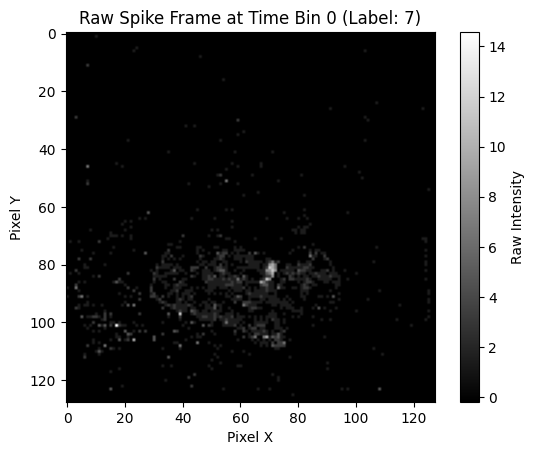

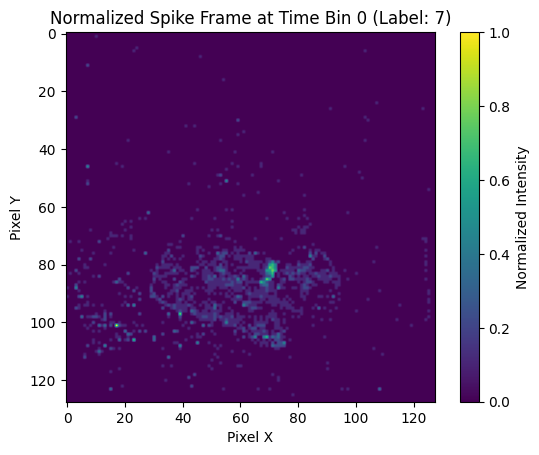

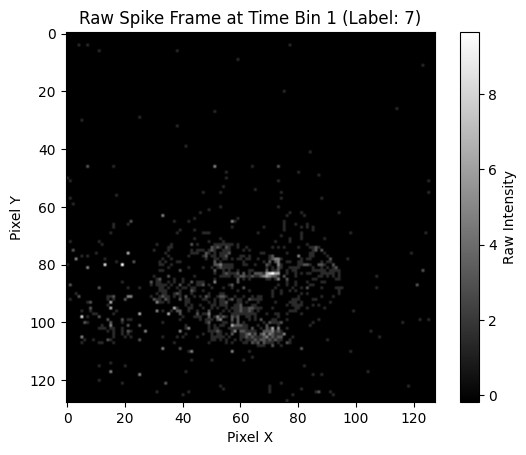

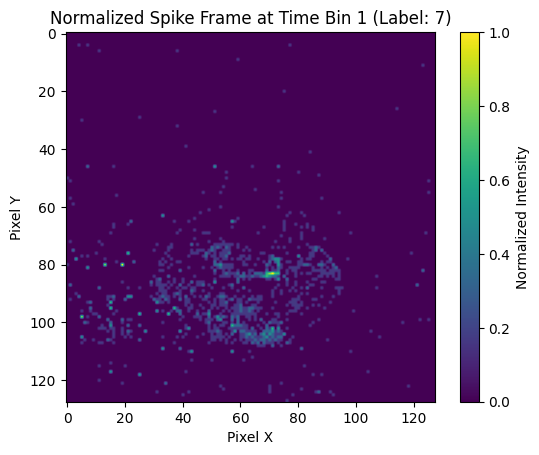

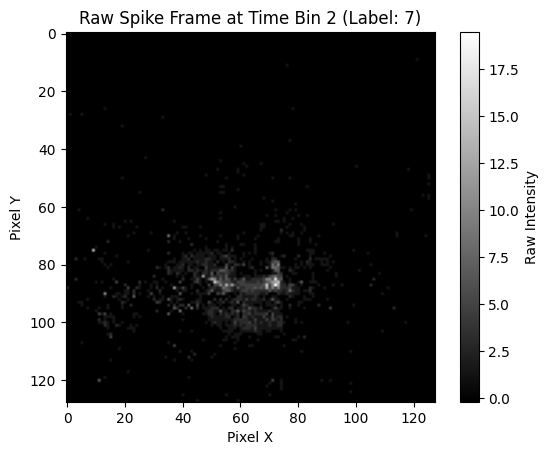

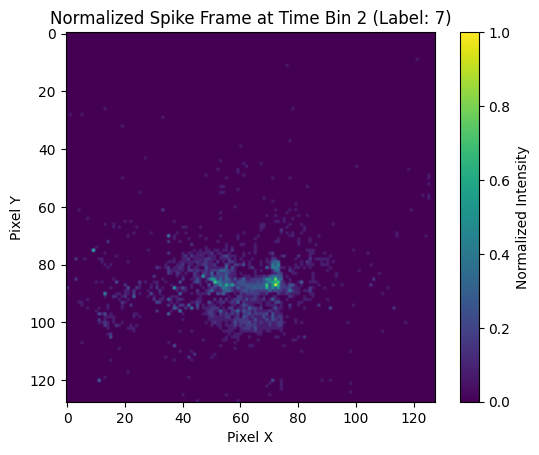

[Sample 1] Label: 2, Spike Frames Shape: (100, 128, 128)


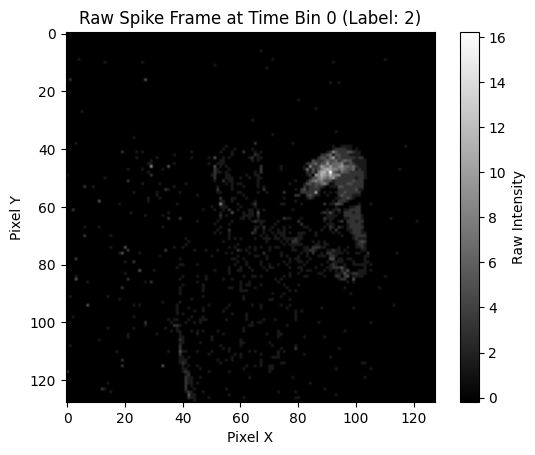

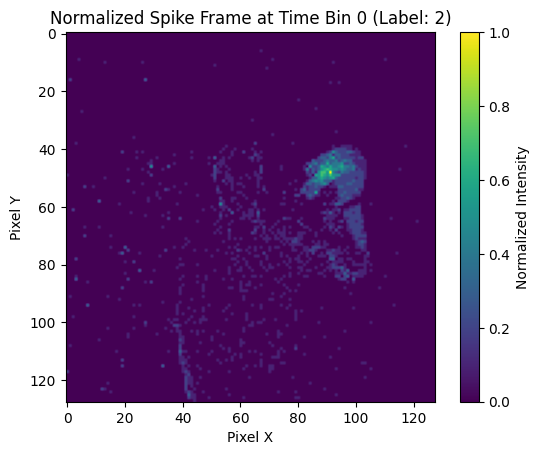

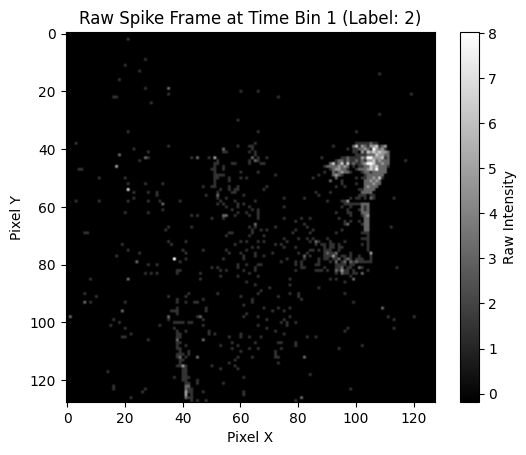

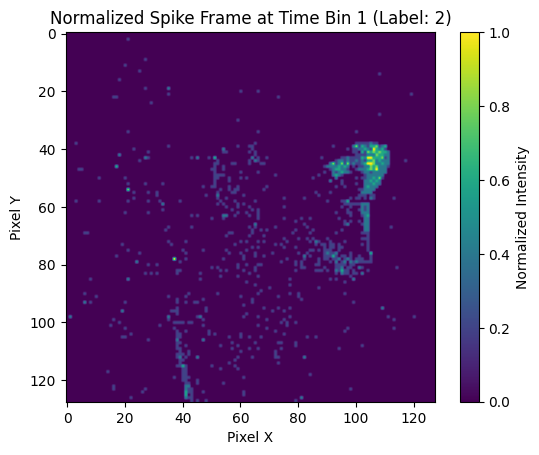

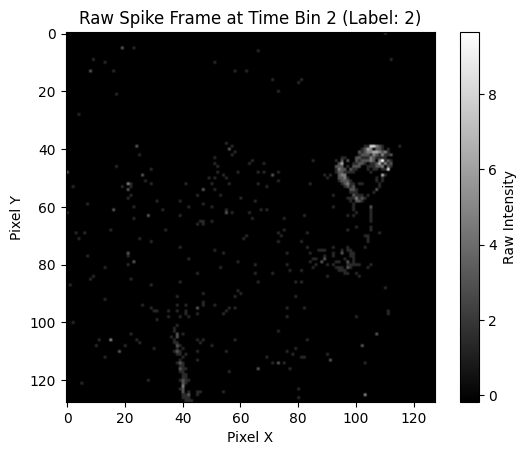

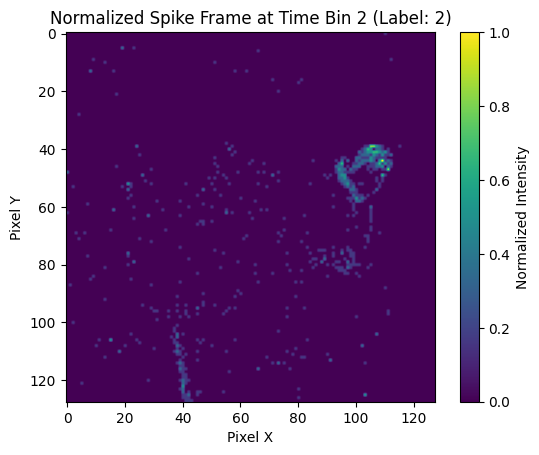

[Sample 2] Label: 6, Spike Frames Shape: (100, 128, 128)


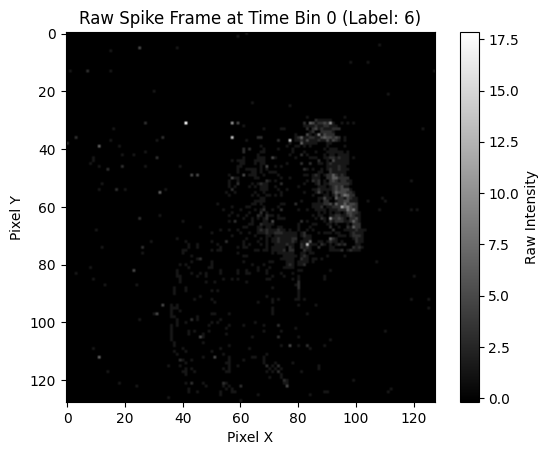

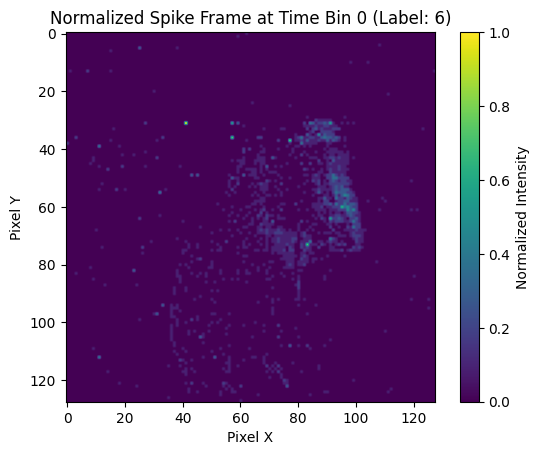

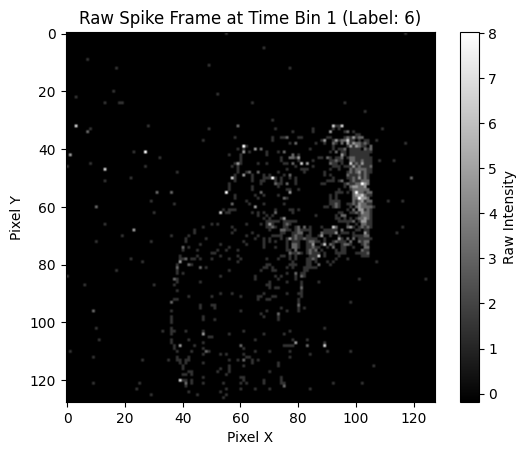

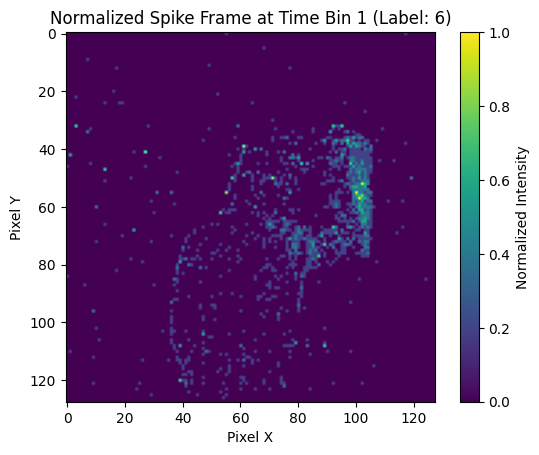

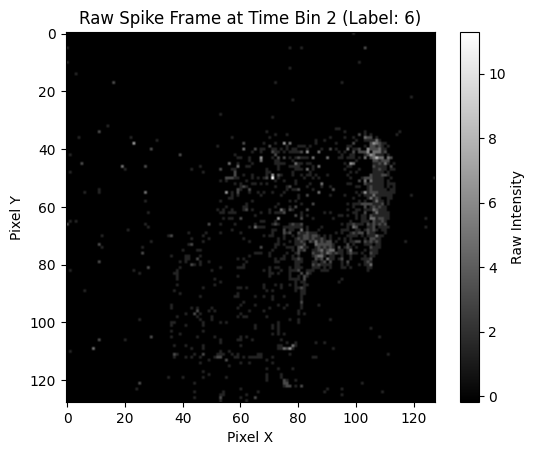

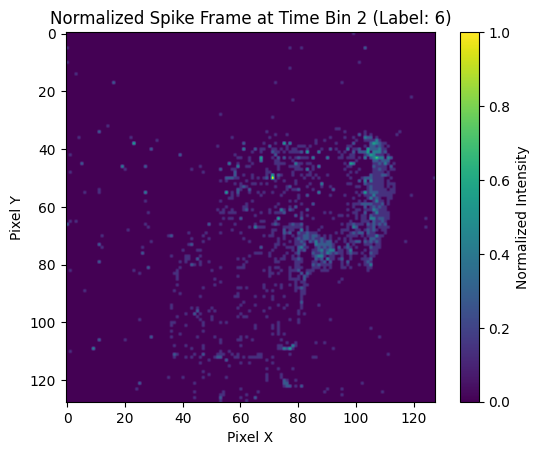

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize a sample from the dataset
def visualize_spike_frames(dvs_dataset, num_samples=5):
    """
    Visualize raw and normalized spike frames from the dataset.
    Args:
        dvs_dataset (Dataset): DVS dataset instance.
        num_samples (int): Number of samples to visualize.
    """
    for idx in range(min(len(dvs_dataset), num_samples)):
        spike_frames, label = dvs_dataset[idx]
        spike_frames = spike_frames.squeeze(0).numpy()  # Remove channel dimension
        print(f"[Sample {idx}] Label: {label}, Spike Frames Shape: {spike_frames.shape}")

        # Visualize a few time bins
        for t in range(min(3, spike_frames.shape[0])):  # Show up to 3 time bins
            raw_frame = spike_frames[t]
            normalized_frame = (raw_frame - np.min(raw_frame)) / (np.max(raw_frame) - np.min(raw_frame) + 1e-8)

            # Plot raw frame
            plt.imshow(raw_frame, cmap="gray")
            plt.colorbar(label="Raw Intensity")
            plt.title(f"Raw Spike Frame at Time Bin {t} (Label: {label})")
            plt.xlabel("Pixel X")
            plt.ylabel("Pixel Y")
            plt.show()

            # Plot normalized frame
            plt.imshow(normalized_frame, cmap="viridis")
            plt.colorbar(label="Normalized Intensity")
            plt.title(f"Normalized Spike Frame at Time Bin {t} (Label: {label})")
            plt.xlabel("Pixel X")
            plt.ylabel("Pixel Y")
            plt.show()

print("Visualizing spike frames from the dataset...")
visualize_spike_frames(train_dataset, num_samples=3)

In [14]:
"""import torch

def debug_gradients_minimal(model, spike_frames, labels, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    outputs = model(spike_frames)
    loss = criterion(outputs, labels)
    print(f"[Gradient Debug] Loss: {loss.item():.6f}")

    loss.backward()

    # Print gradient stats for each parameter
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_cpu = param.grad.detach().cpu()
            mean_val = grad_cpu.mean().item()
            std_val = grad_cpu.std().item()
            print(f"[Gradient Debug] {name} => mean={mean_val:.6f}, std={std_val:.6f}")
            print(f"  Min: {grad_cpu.min().item():.6f}, Max: {grad_cpu.max().item():.6f}")

    # Clear gradients
    optimizer.zero_grad()

def run_minimal_gradient_debug(model, train_loader, optimizer, criterion, device="cpu"):

    model.to(device)

    # 1) Grab first batch from loader
    spike_frames, labels = next(iter(train_loader))

    # 2) Micro-batch of size 4
    spike_frames = spike_frames[:4]
    labels = labels[:4]
    print(f"[Debug] Micro-batch size: {spike_frames.size(0)}")

    # 3) If missing channel dimension => [B,T,H,W], add it => [B,1,T,H,W]
    if spike_frames.dim() == 4:
        spike_frames = spike_frames.unsqueeze(1)

    # 4) Move to device
    spike_frames = spike_frames.to(device, dtype=torch.float32)
    labels = labels.to(device, dtype=torch.long)

    # 5) Actually debug
    debug_gradients_minimal(model, spike_frames, labels, optimizer, criterion)

# Example usage after defining your train_loader, model, optimizer, criterion:
run_minimal_gradient_debug(model, train_loader, optimizer, criterion, device=device)"""

'import torch\n\ndef debug_gradients_minimal(model, spike_frames, labels, optimizer, criterion):\n    model.train()\n    optimizer.zero_grad()\n\n    outputs = model(spike_frames)\n    loss = criterion(outputs, labels)\n    print(f"[Gradient Debug] Loss: {loss.item():.6f}")\n\n    loss.backward()\n\n    # Print gradient stats for each parameter\n    for name, param in model.named_parameters():\n        if param.grad is not None:\n            grad_cpu = param.grad.detach().cpu()\n            mean_val = grad_cpu.mean().item()\n            std_val = grad_cpu.std().item()\n            print(f"[Gradient Debug] {name} => mean={mean_val:.6f}, std={std_val:.6f}")\n            print(f"  Min: {grad_cpu.min().item():.6f}, Max: {grad_cpu.max().item():.6f}")\n\n    # Clear gradients\n    optimizer.zero_grad()\n\ndef run_minimal_gradient_debug(model, train_loader, optimizer, criterion, device="cpu"):\n\n    model.to(device)\n\n    # 1) Grab first batch from loader\n    spike_frames, labels = next(it

In [15]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
  # or wherever you placed the FSN code

# Constants & Hyperparams
CLIP_VALUE = 1.0
DOWNSAMPLE_T = 50  # MUST stay 50 to match FSN's fc1 shape
EPOCHS = 10
BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Suppose you already have:
#   train_loader, test_loader => yield (spike_frames, labels)
#   criterion => CrossEntropyLoss
#   (We define model and optimizer below.)

model = FSN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4, weight_decay=1e-4)

def preprocess_batch(spike_frames, target_time_dim=DOWNSAMPLE_T):
    # Ensure spike_frames shape => [B,1,T,H,W] with T=target_time_dim
    if spike_frames.size(2) != target_time_dim:
        spike_frames = F.interpolate(
            spike_frames,
            size=(target_time_dim, spike_frames.size(3), spike_frames.size(4)),
            mode='nearest'
        )
    return spike_frames

###############################################
# Training Loop
###############################################
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{EPOCHS}", unit="batch") as pbar:
        for batch_idx, (spike_frames, labels) in enumerate(train_loader):
            try:
                print(f"[Batch {batch_idx+1}] Original spike_frames shape: {spike_frames.shape}")

                # Downsample T => 50
                spike_frames = preprocess_batch(spike_frames, DOWNSAMPLE_T)
                print(f"[Batch {batch_idx+1}] Adjusted spike_frames shape: {spike_frames.shape}")

                # Move to device
                spike_frames = spike_frames.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.long)

                # Forward & backward
                optimizer.zero_grad()
                outputs = model(spike_frames)
                loss = criterion(outputs, labels)
                print(f"[Batch {batch_idx+1}] Loss: {loss.item():.6f}")

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)
                optimizer.step()

                # Metrics
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                print(f"[Batch {batch_idx+1}] Predicted labels: {predicted.tolist()}")

                pbar.update(1)
                pbar.set_postfix(loss=loss.item(), acc=f"{correct/total:.4f}")

                # Cleanup
                del spike_frames, labels, outputs, loss
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"[Batch {batch_idx+1}] Error: {e}")
                continue

    train_acc = correct / total if total > 0 else 0
    print(f"Epoch {epoch+1}: Train Loss={running_loss/len(train_loader):.4f}, Acc={train_acc:.4f}")

    # Save checkpoint
    checkpoint_dir = "./model_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model saved at {checkpoint_path}")

###############################################
# Testing Loop
###############################################
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    print("\nStarting Testing...")
    with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
        for batch_idx, (spike_frames, labels) in enumerate(test_loader):
            try:
                print(f"[Batch {batch_idx+1}] Original spike_frames shape: {spike_frames.shape}")

                # Same downsample logic
                spike_frames = preprocess_batch(spike_frames, DOWNSAMPLE_T)
                print(f"[Batch {batch_idx+1}] Adjusted spike_frames shape: {spike_frames.shape}")

                spike_frames = spike_frames.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.long)

                outputs = model(spike_frames)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                print(f"[Batch {batch_idx+1}] Predicted labels: {predicted.tolist()}")

                del spike_frames, labels, outputs, loss
                torch.cuda.empty_cache()

                pbar.update(1)

            except Exception as e:
                print(f"[Batch {batch_idx+1}] Error: {e}")
                continue

test_acc = correct / total if total > 0 else 0
print(f"\nTesting: Test Loss={test_loss/len(test_loader):.4f}, Test Acc={test_acc:.4f}")


Epoch 1/10


Training Epoch 1/10:   0%|          | 0/84 [00:00<?, ?batch/s]/var/folders/tc/nqn36dfs0pvb4_4xs97lt0xh0000gn/T/ipykernel_47527/2609370794.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 2.474216


Training Epoch 1/10:   1%|          | 1/84 [00:10<14:24, 10.41s/batch, acc=0.1250, loss=2.47]

[Batch 1] Predicted labels: [8, 2, 4, 2, 2, 4, 8, 4, 4, 8, 4, 3, 8, 4, 2, 8]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 90.089958


Training Epoch 1/10:   2%|▏         | 2/84 [00:20<14:02, 10.27s/batch, acc=0.1250, loss=90.1]

[Batch 2] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 17.430662


Training Epoch 1/10:   4%|▎         | 3/84 [00:30<13:51, 10.26s/batch, acc=0.0833, loss=17.4]

[Batch 3] Predicted labels: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 3.217102


Training Epoch 1/10:   5%|▍         | 4/84 [00:41<13:50, 10.38s/batch, acc=0.0625, loss=3.22]

[Batch 4] Predicted labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 2.384048


Training Epoch 1/10:   6%|▌         | 5/84 [00:51<13:42, 10.41s/batch, acc=0.0750, loss=2.38]

[Batch 5] Predicted labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 2.387756


Training Epoch 1/10:   7%|▋         | 6/84 [01:01<13:24, 10.32s/batch, acc=0.0833, loss=2.39]

[Batch 6] Predicted labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 2.390543


Training Epoch 1/10:   8%|▊         | 7/84 [01:12<13:11, 10.28s/batch, acc=0.0804, loss=2.39]

[Batch 7] Predicted labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 2.454301


Training Epoch 1/10:  10%|▉         | 8/84 [01:22<12:59, 10.25s/batch, acc=0.0781, loss=2.45]

[Batch 8] Predicted labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 2.410571


Training Epoch 1/10:  11%|█         | 9/84 [01:32<12:49, 10.26s/batch, acc=0.0764, loss=2.41]

[Batch 9] Predicted labels: [9, 7, 9, 7, 9, 7, 9, 7, 9, 9, 9, 9, 7, 7, 9, 9]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 2.558489


Training Epoch 1/10:  12%|█▏        | 10/84 [01:42<12:31, 10.15s/batch, acc=0.0875, loss=2.56]

[Batch 10] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 2.375928


Training Epoch 1/10:  13%|█▎        | 11/84 [01:52<12:20, 10.14s/batch, acc=0.0852, loss=2.38]

[Batch 11] Predicted labels: [7, 1, 9, 9, 1, 9, 1, 1, 2, 9, 4, 1, 1, 1, 4, 4]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 2.357981


Training Epoch 1/10:  14%|█▍        | 12/84 [02:02<12:09, 10.13s/batch, acc=0.1042, loss=2.36]

[Batch 12] Predicted labels: [1, 7, 7, 1, 1, 1, 1, 2, 9, 7, 1, 7, 7, 7, 2, 2]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 2.307297


Training Epoch 1/10:  15%|█▌        | 13/84 [02:13<12:15, 10.36s/batch, acc=0.1106, loss=2.31]

[Batch 13] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 2.758497


Training Epoch 1/10:  17%|█▋        | 14/84 [02:24<12:05, 10.36s/batch, acc=0.1116, loss=2.76]

[Batch 14] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 2.684254


Training Epoch 1/10:  18%|█▊        | 15/84 [02:34<12:01, 10.46s/batch, acc=0.1083, loss=2.68]

[Batch 15] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 2.084743


Training Epoch 1/10:  19%|█▉        | 16/84 [02:45<11:49, 10.43s/batch, acc=0.1055, loss=2.08]

[Batch 16] Predicted labels: [3, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 3, 3]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 2.690362


Training Epoch 1/10:  20%|██        | 17/84 [02:55<11:33, 10.35s/batch, acc=0.1029, loss=2.69]

[Batch 17] Predicted labels: [3, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 8, 8, 4, 8, 8]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 2.313597


Training Epoch 1/10:  21%|██▏       | 18/84 [03:05<11:18, 10.28s/batch, acc=0.1215, loss=2.31]

[Batch 18] Predicted labels: [8, 8, 8, 7, 4, 7, 7, 7, 8, 7, 8, 7, 7, 8, 7, 7]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 2.465756


Training Epoch 1/10:  23%|██▎       | 19/84 [03:15<11:04, 10.22s/batch, acc=0.1217, loss=2.47]

[Batch 19] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 2.302285


Training Epoch 1/10:  24%|██▍       | 20/84 [03:25<10:51, 10.18s/batch, acc=0.1250, loss=2.3] 

[Batch 20] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 2.186300


Training Epoch 1/10:  25%|██▌       | 21/84 [03:35<10:39, 10.16s/batch, acc=0.1280, loss=2.19]

[Batch 21] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 2.581021


Training Epoch 1/10:  26%|██▌       | 22/84 [03:45<10:28, 10.13s/batch, acc=0.1307, loss=2.58]

[Batch 22] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 2.187243


Training Epoch 1/10:  27%|██▋       | 23/84 [03:55<10:17, 10.12s/batch, acc=0.1359, loss=2.19]

[Batch 23] Predicted labels: [7, 7, 7, 7, 6, 7, 7, 7, 6, 6, 6, 7, 6, 7, 7, 7]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 2.473007


Training Epoch 1/10:  29%|██▊       | 24/84 [04:05<10:07, 10.12s/batch, acc=0.1302, loss=2.47]

[Batch 24] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 2.318637


Training Epoch 1/10:  30%|██▉       | 25/84 [04:15<09:55, 10.09s/batch, acc=0.1250, loss=2.32]

[Batch 25] Predicted labels: [7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 6, 6, 7, 6]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 2.272187


Training Epoch 1/10:  31%|███       | 26/84 [04:25<09:43, 10.06s/batch, acc=0.1274, loss=2.27]

[Batch 26] Predicted labels: [7, 1, 7, 7, 1, 6, 0, 8, 8, 0, 6, 7, 6, 6, 6, 0]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 2.318635


Training Epoch 1/10:  32%|███▏      | 27/84 [04:35<09:31, 10.03s/batch, acc=0.1296, loss=2.32]

[Batch 27] Predicted labels: [8, 8, 0, 6, 0, 6, 8, 3, 8, 3, 1, 3, 8, 8, 1, 6]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 2.107177


Training Epoch 1/10:  33%|███▎      | 28/84 [04:45<09:21, 10.03s/batch, acc=0.1362, loss=2.11]

[Batch 28] Predicted labels: [8, 8, 8, 8, 8, 0, 0, 8, 1, 3, 3, 8, 8, 0, 0, 8]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 2.207455


Training Epoch 1/10:  35%|███▍      | 29/84 [04:56<09:21, 10.21s/batch, acc=0.1379, loss=2.21]

[Batch 29] Predicted labels: [0, 0, 2, 7, 1, 1, 1, 0, 3, 8, 8, 0, 3, 0, 0, 0]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 2.267888


Training Epoch 1/10:  36%|███▌      | 30/84 [05:06<09:09, 10.17s/batch, acc=0.1437, loss=2.27]

[Batch 30] Predicted labels: [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 2.987234


Training Epoch 1/10:  37%|███▋      | 31/84 [05:16<08:58, 10.15s/batch, acc=0.1452, loss=2.99]

[Batch 31] Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 2.695638


Training Epoch 1/10:  38%|███▊      | 32/84 [05:26<08:46, 10.12s/batch, acc=0.1445, loss=2.7] 

[Batch 32] Predicted labels: [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 2.349041


Training Epoch 1/10:  39%|███▉      | 33/84 [05:36<08:34, 10.09s/batch, acc=0.1420, loss=2.35]

[Batch 33] Predicted labels: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 2.250794


Training Epoch 1/10:  40%|████      | 34/84 [05:46<08:21, 10.02s/batch, acc=0.1434, loss=2.25]

[Batch 34] Predicted labels: [1, 7, 3, 1, 8, 3, 3, 1, 3, 2, 7, 1, 3, 3, 3, 2]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 2.119846


Training Epoch 1/10:  42%|████▏     | 35/84 [05:56<08:09,  9.99s/batch, acc=0.1518, loss=2.12]

[Batch 35] Predicted labels: [3, 1, 1, 1, 7, 7, 3, 1, 1, 7, 1, 1, 7, 1, 8, 3]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 2.331335


Training Epoch 1/10:  43%|████▎     | 36/84 [06:06<07:58,  9.96s/batch, acc=0.1510, loss=2.33]

[Batch 36] Predicted labels: [7, 7, 7, 7, 7, 0, 7, 7, 1, 7, 7, 1, 0, 7, 7, 0]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 2.299988


Training Epoch 1/10:  44%|████▍     | 37/84 [06:16<07:47,  9.94s/batch, acc=0.1486, loss=2.3] 

[Batch 37] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 2.204415


Training Epoch 1/10:  45%|████▌     | 38/84 [06:26<07:36,  9.92s/batch, acc=0.1513, loss=2.2]

[Batch 38] Predicted labels: [7, 7, 7, 7, 7, 7, 1, 7, 1, 0, 7, 2, 7, 7, 7, 7]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 2.142994


Training Epoch 1/10:  46%|████▋     | 39/84 [06:36<07:24,  9.88s/batch, acc=0.1538, loss=2.14]

[Batch 39] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 7, 1, 7, 7, 7]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 2.030275


Training Epoch 1/10:  48%|████▊     | 40/84 [06:46<07:16,  9.93s/batch, acc=0.1562, loss=2.03]

[Batch 40] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 2.368028


Training Epoch 1/10:  49%|████▉     | 41/84 [06:55<07:05,  9.89s/batch, acc=0.1555, loss=2.37]

[Batch 41] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 2.202410


Training Epoch 1/10:  50%|█████     | 42/84 [07:05<06:57,  9.94s/batch, acc=0.1607, loss=2.2] 

[Batch 42] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 2.341043


Training Epoch 1/10:  51%|█████     | 43/84 [07:16<06:49, 10.00s/batch, acc=0.1599, loss=2.34]

[Batch 43] Predicted labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 2.481967


Training Epoch 1/10:  52%|█████▏    | 44/84 [07:26<06:38,  9.97s/batch, acc=0.1562, loss=2.48]

[Batch 44] Predicted labels: [7, 8, 8, 7, 7, 8, 7, 8, 8, 8, 8, 7, 3, 8, 7, 3]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 2.290057


Training Epoch 1/10:  54%|█████▎    | 45/84 [07:35<06:26,  9.91s/batch, acc=0.1542, loss=2.29]

[Batch 45] Predicted labels: [8, 7, 3, 7, 3, 8, 8, 3, 8, 3, 8, 4, 3, 8, 3, 8]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 2.162868


Training Epoch 1/10:  55%|█████▍    | 46/84 [07:45<06:16,  9.90s/batch, acc=0.1535, loss=2.16]

[Batch 46] Predicted labels: [4, 1, 8, 8, 4, 4, 4, 1, 4, 4, 1, 8, 4, 4, 5, 4]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 1.886638


Training Epoch 1/10:  56%|█████▌    | 47/84 [07:55<06:09,  9.98s/batch, acc=0.1569, loss=1.89]

[Batch 47] Predicted labels: [7, 1, 1, 0, 1, 3, 1, 7, 1, 3, 3, 0, 7, 1, 7, 1]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 2.052323


Training Epoch 1/10:  57%|█████▋    | 48/84 [08:05<06:00, 10.02s/batch, acc=0.1562, loss=2.05]

[Batch 48] Predicted labels: [1, 3, 1, 1, 1, 1, 3, 7, 1, 3, 1, 1, 1, 1, 7, 1]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 2.245512


Training Epoch 1/10:  58%|█████▊    | 49/84 [08:15<05:50, 10.01s/batch, acc=0.1569, loss=2.25]

[Batch 49] Predicted labels: [1, 7, 3, 1, 1, 3, 1, 3, 7, 1, 7, 3, 1, 3, 7, 3]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 1.954927


Training Epoch 1/10:  60%|█████▉    | 50/84 [08:25<05:39,  9.99s/batch, acc=0.1600, loss=1.95]

[Batch 50] Predicted labels: [7, 7, 0, 7, 3, 1, 1, 3, 7, 1, 3, 1, 5, 3, 1, 3]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 2.224672


Training Epoch 1/10:  61%|██████    | 51/84 [08:35<05:29,  9.98s/batch, acc=0.1605, loss=2.22]

[Batch 51] Predicted labels: [3, 3, 3, 3, 3, 7, 1, 7, 7, 1, 7, 3, 3, 3, 1, 3]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 1.781329


Training Epoch 1/10:  62%|██████▏   | 52/84 [08:45<05:19,  9.97s/batch, acc=0.1647, loss=1.78]

[Batch 52] Predicted labels: [7, 7, 1, 0, 7, 7, 6, 7, 7, 3, 7, 7, 4, 7, 1, 1]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 1.971427


Training Epoch 1/10:  63%|██████▎   | 53/84 [08:55<05:08,  9.97s/batch, acc=0.1698, loss=1.97]

[Batch 53] Predicted labels: [1, 1, 0, 3, 1, 7, 7, 5, 7, 0, 7, 7, 7, 7, 1, 3]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 1.699280


Training Epoch 1/10:  64%|██████▍   | 54/84 [09:05<04:58,  9.97s/batch, acc=0.1736, loss=1.7] 

[Batch 54] Predicted labels: [7, 1, 7, 6, 7, 7, 0, 7, 3, 7, 7, 7, 1, 3, 5, 7]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 2.239506


Training Epoch 1/10:  65%|██████▌   | 55/84 [09:15<04:49,  9.99s/batch, acc=0.1739, loss=2.24]

[Batch 55] Predicted labels: [7, 7, 0, 7, 1, 0, 1, 7, 7, 7, 7, 0, 7, 0, 7, 7]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 2.070061


Training Epoch 1/10:  67%|██████▋   | 56/84 [09:25<04:39,  9.99s/batch, acc=0.1752, loss=2.07]

[Batch 56] Predicted labels: [7, 0, 0, 7, 0, 7, 7, 7, 7, 7, 1, 1, 7, 7, 0, 0]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 1.711237


Training Epoch 1/10:  68%|██████▊   | 57/84 [09:35<04:29,  9.99s/batch, acc=0.1787, loss=1.71]

[Batch 57] Predicted labels: [6, 7, 7, 0, 7, 1, 3, 7, 7, 7, 1, 7, 0, 7, 6, 7]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 1.960353


Training Epoch 1/10:  69%|██████▉   | 58/84 [09:45<04:20, 10.01s/batch, acc=0.1810, loss=1.96]

[Batch 58] Predicted labels: [3, 3, 3, 7, 7, 0, 7, 7, 1, 0, 7, 1, 3, 7, 3, 7]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 1.374244


Training Epoch 1/10:  70%|███████   | 59/84 [09:55<04:10, 10.03s/batch, acc=0.1864, loss=1.37]

[Batch 59] Predicted labels: [3, 1, 7, 7, 0, 0, 1, 1, 0, 7, 7, 7, 7, 6, 1, 1]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 2.003766


Training Epoch 1/10:  71%|███████▏  | 60/84 [10:05<04:01, 10.06s/batch, acc=0.1865, loss=2]   

[Batch 60] Predicted labels: [6, 0, 1, 1, 3, 7, 1, 0, 1, 7, 1, 3, 7, 1, 1, 1]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 1.963662


Training Epoch 1/10:  73%|███████▎  | 61/84 [10:16<03:51, 10.06s/batch, acc=0.1885, loss=1.96]

[Batch 61] Predicted labels: [3, 2, 5, 3, 7, 1, 7, 3, 3, 7, 1, 0, 1, 1, 2, 4]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 1.764610


Training Epoch 1/10:  74%|███████▍  | 62/84 [10:25<03:40, 10.01s/batch, acc=0.1915, loss=1.76]

[Batch 62] Predicted labels: [1, 3, 3, 3, 7, 7, 7, 3, 1, 7, 7, 5, 5, 5, 2, 3]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 1.718229


Training Epoch 1/10:  75%|███████▌  | 63/84 [10:35<03:30, 10.01s/batch, acc=0.1964, loss=1.72]

[Batch 63] Predicted labels: [2, 7, 7, 0, 5, 7, 7, 5, 7, 2, 7, 5, 2, 8, 5, 5]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 1.653292


Training Epoch 1/10:  76%|███████▌  | 64/84 [10:46<03:21, 10.05s/batch, acc=0.2031, loss=1.65]

[Batch 64] Predicted labels: [2, 7, 3, 7, 7, 3, 3, 5, 7, 7, 2, 2, 2, 7, 7, 7]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 1.774990


Training Epoch 1/10:  77%|███████▋  | 65/84 [10:56<03:11, 10.09s/batch, acc=0.2077, loss=1.77]

[Batch 65] Predicted labels: [2, 2, 7, 7, 7, 0, 2, 7, 7, 2, 7, 7, 2, 7, 7, 7]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 1.917536


Training Epoch 1/10:  79%|███████▊  | 66/84 [11:06<03:01, 10.09s/batch, acc=0.2121, loss=1.92]

[Batch 66] Predicted labels: [7, 2, 2, 7, 7, 7, 2, 0, 7, 7, 2, 7, 2, 7, 2, 2]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 2.232616


Training Epoch 1/10:  80%|███████▉  | 67/84 [11:16<02:51, 10.09s/batch, acc=0.2127, loss=2.23]

[Batch 67] Predicted labels: [7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 2, 2, 7, 2, 7, 7]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 1.495969


Training Epoch 1/10:  81%|████████  | 68/84 [11:26<02:41, 10.06s/batch, acc=0.2169, loss=1.5] 

[Batch 68] Predicted labels: [7, 7, 7, 7, 7, 2, 2, 2, 7, 2, 7, 7, 7, 7, 7, 2]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 1.451831


Training Epoch 1/10:  82%|████████▏ | 69/84 [11:36<02:30, 10.02s/batch, acc=0.2210, loss=1.45]

[Batch 69] Predicted labels: [7, 7, 7, 7, 7, 3, 0, 7, 7, 7, 5, 7, 7, 5, 7, 7]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 1.364934


Training Epoch 1/10:  83%|████████▎ | 70/84 [11:46<02:20, 10.03s/batch, acc=0.2268, loss=1.36]

[Batch 70] Predicted labels: [7, 5, 7, 7, 7, 5, 2, 7, 7, 3, 7, 0, 5, 0, 6, 0]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 1.706827


Training Epoch 1/10:  85%|████████▍ | 71/84 [11:56<02:10, 10.02s/batch, acc=0.2298, loss=1.71]

[Batch 71] Predicted labels: [0, 7, 5, 7, 7, 0, 0, 5, 7, 7, 2, 2, 0, 7, 5, 7]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 1.918720


Training Epoch 1/10:  86%|████████▌ | 72/84 [12:06<02:00, 10.04s/batch, acc=0.2309, loss=1.92]

[Batch 72] Predicted labels: [7, 7, 6, 3, 0, 5, 6, 7, 3, 7, 2, 7, 3, 6, 2, 2]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 1.664622


Training Epoch 1/10:  87%|████████▋ | 73/84 [12:16<01:50, 10.05s/batch, acc=0.2346, loss=1.66]

[Batch 73] Predicted labels: [0, 0, 0, 3, 7, 2, 6, 3, 6, 7, 2, 0, 6, 3, 7, 2]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 2.156193


Training Epoch 1/10:  88%|████████▊ | 74/84 [12:27<01:41, 10.17s/batch, acc=0.2348, loss=2.16]

[Batch 74] Predicted labels: [0, 6, 0, 7, 7, 2, 2, 7, 3, 6, 2, 7, 0, 0, 0, 7]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 1.758777


Training Epoch 1/10:  89%|████████▉ | 75/84 [12:37<01:31, 10.20s/batch, acc=0.2383, loss=1.76]

[Batch 75] Predicted labels: [6, 9, 2, 0, 7, 6, 3, 0, 0, 1, 3, 5, 3, 3, 6, 3]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 1.658077


Training Epoch 1/10:  90%|█████████ | 76/84 [12:47<01:21, 10.20s/batch, acc=0.2418, loss=1.66]

[Batch 76] Predicted labels: [6, 0, 3, 7, 3, 8, 3, 5, 8, 3, 3, 3, 0, 6, 8, 3]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 1.593652


Training Epoch 1/10:  92%|█████████▏| 77/84 [12:57<01:11, 10.16s/batch, acc=0.2451, loss=1.59]

[Batch 77] Predicted labels: [1, 8, 3, 3, 0, 3, 1, 6, 2, 0, 6, 6, 1, 0, 6, 1]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 1.872954


Training Epoch 1/10:  93%|█████████▎| 78/84 [13:07<01:00, 10.11s/batch, acc=0.2460, loss=1.87]

[Batch 78] Predicted labels: [0, 7, 6, 7, 2, 6, 0, 0, 0, 7, 3, 3, 7, 0, 0, 7]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 1.674804


Training Epoch 1/10:  94%|█████████▍| 79/84 [13:17<00:50, 10.14s/batch, acc=0.2484, loss=1.67]

[Batch 79] Predicted labels: [8, 9, 9, 3, 0, 6, 8, 8, 6, 0, 8, 7, 3, 3, 4, 6]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 1.891421


Training Epoch 1/10:  95%|█████████▌| 80/84 [13:27<00:40, 10.09s/batch, acc=0.2492, loss=1.89]

[Batch 80] Predicted labels: [8, 3, 8, 7, 9, 9, 9, 6, 2, 2, 2, 1, 9, 9, 0, 8]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 1.669991


Training Epoch 1/10:  96%|█████████▋| 81/84 [13:37<00:30, 10.05s/batch, acc=0.2500, loss=1.67]

[Batch 81] Predicted labels: [8, 8, 5, 8, 8, 8, 8, 2, 3, 6, 6, 8, 3, 2, 6, 2]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 1.572204


Training Epoch 1/10:  98%|█████████▊| 82/84 [13:47<00:20, 10.08s/batch, acc=0.2508, loss=1.57]

[Batch 82] Predicted labels: [8, 8, 8, 2, 8, 2, 2, 6, 2, 4, 3, 1, 8, 7, 7, 7]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 1.266801


Training Epoch 1/10:  99%|█████████▉| 83/84 [13:57<00:10, 10.05s/batch, acc=0.2553, loss=1.27]

[Batch 83] Predicted labels: [2, 1, 2, 4, 9, 9, 6, 2, 3, 6, 7, 7, 7, 3, 7, 4]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 1.215353


Training Epoch 1/10: 100%|██████████| 84/84 [14:06<00:00, 10.07s/batch, acc=0.2601, loss=1.22]


[Batch 84] Predicted labels: [4, 2, 6, 4, 7, 7, 6, 7, 9, 9, 7, 7, 4, 1]
Epoch 1: Train Loss=3.3387, Acc=0.2601
Model saved at ./model_checkpoints/model_epoch_1.pth

Epoch 2/10


Training Epoch 2/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 1.477990


Training Epoch 2/10:   1%|          | 1/84 [00:10<13:59, 10.11s/batch, acc=0.6250, loss=1.48]

[Batch 1] Predicted labels: [7, 6, 2, 4, 6, 4, 1, 7, 1, 4, 1, 7, 4, 7, 1, 2]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 2.063411


Training Epoch 2/10:   2%|▏         | 2/84 [00:20<13:43, 10.04s/batch, acc=0.4688, loss=2.06]

[Batch 2] Predicted labels: [7, 4, 9, 4, 4, 6, 4, 4, 1, 6, 7, 6, 7, 1, 4, 7]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 2.079009


Training Epoch 2/10:   4%|▎         | 3/84 [00:30<13:34, 10.05s/batch, acc=0.3958, loss=2.08]

[Batch 3] Predicted labels: [4, 7, 9, 4, 7, 4, 7, 7, 4, 4, 4, 7, 7, 9, 4, 4]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 1.373234


Training Epoch 2/10:   5%|▍         | 4/84 [00:40<13:21, 10.02s/batch, acc=0.4375, loss=1.37]

[Batch 4] Predicted labels: [7, 6, 6, 7, 9, 2, 2, 7, 7, 9, 4, 7, 4, 9, 7, 7]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 1.265800


Training Epoch 2/10:   6%|▌         | 5/84 [00:50<13:13, 10.05s/batch, acc=0.4500, loss=1.27]

[Batch 5] Predicted labels: [6, 6, 2, 2, 7, 7, 6, 6, 7, 9, 9, 1, 1, 7, 9, 4]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 1.356419


Training Epoch 2/10:   7%|▋         | 6/84 [01:00<13:05, 10.07s/batch, acc=0.4479, loss=1.36]

[Batch 6] Predicted labels: [7, 7, 6, 2, 2, 4, 4, 0, 7, 0, 3, 7, 2, 7, 7, 9]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 1.381836


Training Epoch 2/10:   8%|▊         | 7/84 [01:10<12:56, 10.08s/batch, acc=0.4464, loss=1.38]

[Batch 7] Predicted labels: [6, 7, 7, 0, 8, 6, 9, 8, 1, 0, 2, 3, 1, 0, 8, 8]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 1.162943


Training Epoch 2/10:  10%|▉         | 8/84 [01:20<12:46, 10.09s/batch, acc=0.4531, loss=1.16]

[Batch 8] Predicted labels: [8, 8, 7, 3, 0, 1, 0, 0, 1, 8, 0, 1, 3, 0, 2, 8]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 1.260837


Training Epoch 2/10:  11%|█         | 9/84 [01:31<12:45, 10.20s/batch, acc=0.4583, loss=1.26]

[Batch 9] Predicted labels: [8, 6, 9, 8, 6, 7, 8, 1, 8, 0, 3, 2, 0, 0, 1, 3]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 1.433221


Training Epoch 2/10:  12%|█▏        | 10/84 [01:41<12:36, 10.22s/batch, acc=0.4500, loss=1.43]

[Batch 10] Predicted labels: [3, 8, 3, 0, 8, 3, 6, 0, 8, 6, 8, 7, 6, 1, 7, 8]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 1.295267


Training Epoch 2/10:  13%|█▎        | 11/84 [01:51<12:24, 10.20s/batch, acc=0.4602, loss=1.3] 

[Batch 11] Predicted labels: [7, 7, 8, 7, 9, 3, 3, 9, 6, 3, 0, 8, 7, 0, 6, 0]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 1.001190


Training Epoch 2/10:  14%|█▍        | 12/84 [02:01<12:13, 10.19s/batch, acc=0.4740, loss=1]  

[Batch 12] Predicted labels: [5, 0, 6, 7, 7, 3, 6, 0, 3, 0, 1, 6, 7, 7, 6, 0]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 1.151117


Training Epoch 2/10:  15%|█▌        | 13/84 [02:11<12:04, 10.20s/batch, acc=0.4760, loss=1.15]

[Batch 13] Predicted labels: [8, 3, 2, 7, 7, 0, 7, 7, 6, 6, 3, 7, 7, 7, 2, 7]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 1.319256


Training Epoch 2/10:  17%|█▋        | 14/84 [02:21<11:53, 10.19s/batch, acc=0.4821, loss=1.32]

[Batch 14] Predicted labels: [3, 3, 6, 6, 6, 7, 1, 6, 1, 8, 7, 7, 7, 3, 3, 6]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 1.205503


Training Epoch 2/10:  18%|█▊        | 15/84 [02:32<11:40, 10.15s/batch, acc=0.4875, loss=1.21]

[Batch 15] Predicted labels: [6, 3, 6, 7, 7, 6, 6, 8, 6, 6, 1, 6, 2, 7, 1, 1]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.870638


Training Epoch 2/10:  19%|█▉        | 16/84 [02:42<11:29, 10.14s/batch, acc=0.4961, loss=0.871]

[Batch 16] Predicted labels: [1, 7, 1, 2, 9, 9, 1, 6, 5, 6, 8, 6, 7, 3, 8, 7]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 1.338966


Training Epoch 2/10:  20%|██        | 17/84 [02:52<11:18, 10.13s/batch, acc=0.4926, loss=1.34] 

[Batch 17] Predicted labels: [9, 1, 3, 3, 5, 9, 7, 7, 7, 2, 7, 7, 4, 0, 3, 5]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 1.057503


Training Epoch 2/10:  21%|██▏       | 18/84 [03:02<11:05, 10.08s/batch, acc=0.5035, loss=1.06]

[Batch 18] Predicted labels: [0, 7, 7, 0, 5, 2, 7, 3, 7, 7, 7, 6, 0, 7, 7, 9]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 1.221965


Training Epoch 2/10:  23%|██▎       | 19/84 [03:12<10:56, 10.10s/batch, acc=0.5132, loss=1.22]

[Batch 19] Predicted labels: [1, 2, 4, 7, 2, 7, 2, 1, 7, 7, 7, 7, 7, 7, 7, 1]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 1.355341


Training Epoch 2/10:  24%|██▍       | 20/84 [03:22<10:44, 10.07s/batch, acc=0.5156, loss=1.36]

[Batch 20] Predicted labels: [0, 4, 7, 0, 1, 7, 0, 5, 7, 7, 0, 1, 7, 4, 0, 7]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 1.092252


Training Epoch 2/10:  25%|██▌       | 21/84 [03:32<10:33, 10.06s/batch, acc=0.5268, loss=1.09]

[Batch 21] Predicted labels: [4, 1, 7, 2, 4, 7, 7, 6, 7, 7, 7, 3, 1, 2, 0, 7]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 1.406191


Training Epoch 2/10:  26%|██▌       | 22/84 [03:42<10:22, 10.03s/batch, acc=0.5227, loss=1.41]

[Batch 22] Predicted labels: [7, 5, 7, 2, 4, 7, 4, 4, 9, 2, 7, 5, 1, 0, 3, 7]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 1.278004


Training Epoch 2/10:  27%|██▋       | 23/84 [03:52<10:11, 10.03s/batch, acc=0.5190, loss=1.28]

[Batch 23] Predicted labels: [7, 7, 5, 4, 2, 5, 2, 2, 3, 7, 7, 1, 7, 7, 9, 4]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 1.085218


Training Epoch 2/10:  29%|██▊       | 24/84 [04:02<10:02, 10.04s/batch, acc=0.5208, loss=1.09]

[Batch 24] Predicted labels: [7, 5, 4, 2, 4, 4, 6, 6, 3, 6, 7, 7, 4, 7, 2, 6]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 1.034949


Training Epoch 2/10:  30%|██▉       | 25/84 [04:12<09:55, 10.09s/batch, acc=0.5250, loss=1.03]

[Batch 25] Predicted labels: [5, 7, 7, 7, 6, 7, 1, 3, 6, 7, 7, 7, 7, 7, 5, 4]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 1.073211


Training Epoch 2/10:  31%|███       | 26/84 [04:22<09:43, 10.06s/batch, acc=0.5312, loss=1.07]

[Batch 26] Predicted labels: [1, 8, 6, 4, 9, 0, 2, 7, 2, 3, 3, 1, 7, 1, 5, 7]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.668882


Training Epoch 2/10:  32%|███▏      | 27/84 [04:32<09:33, 10.06s/batch, acc=0.5417, loss=0.669]

[Batch 27] Predicted labels: [7, 0, 2, 8, 6, 6, 8, 1, 0, 3, 2, 0, 2, 2, 7, 0]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 1.288136


Training Epoch 2/10:  33%|███▎      | 28/84 [04:42<09:24, 10.09s/batch, acc=0.5402, loss=1.29] 

[Batch 28] Predicted labels: [5, 9, 9, 7, 4, 7, 7, 7, 0, 9, 1, 0, 4, 4, 0, 9]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 1.082429


Training Epoch 2/10:  35%|███▍      | 29/84 [04:53<09:16, 10.12s/batch, acc=0.5409, loss=1.08]

[Batch 29] Predicted labels: [0, 0, 2, 5, 0, 0, 2, 3, 2, 5, 0, 7, 7, 7, 3, 5]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 1.667781


Training Epoch 2/10:  36%|███▌      | 30/84 [05:03<09:04, 10.09s/batch, acc=0.5354, loss=1.67]

[Batch 30] Predicted labels: [1, 9, 0, 1, 1, 3, 9, 9, 1, 0, 5, 9, 2, 1, 9, 0]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 1.289032


Training Epoch 2/10:  37%|███▋      | 31/84 [05:13<08:55, 10.10s/batch, acc=0.5383, loss=1.29]

[Batch 31] Predicted labels: [9, 1, 7, 7, 0, 7, 1, 0, 7, 2, 5, 0, 3, 9, 3, 7]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 1.244408


Training Epoch 2/10:  38%|███▊      | 32/84 [05:23<08:44, 10.09s/batch, acc=0.5371, loss=1.24]

[Batch 32] Predicted labels: [3, 7, 3, 1, 0, 3, 1, 8, 3, 1, 7, 5, 2, 3, 7, 2]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 1.354219


Training Epoch 2/10:  39%|███▉      | 33/84 [05:33<08:33, 10.06s/batch, acc=0.5322, loss=1.35]

[Batch 33] Predicted labels: [1, 5, 5, 0, 7, 7, 3, 3, 3, 0, 9, 9, 5, 5, 9, 2]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 1.180057


Training Epoch 2/10:  40%|████      | 34/84 [05:43<08:23, 10.07s/batch, acc=0.5349, loss=1.18]

[Batch 34] Predicted labels: [3, 3, 7, 9, 9, 5, 9, 7, 3, 5, 7, 9, 3, 0, 3, 1]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 1.085381


Training Epoch 2/10:  42%|████▏     | 35/84 [05:53<08:13, 10.07s/batch, acc=0.5321, loss=1.09]

[Batch 35] Predicted labels: [9, 1, 3, 7, 1, 3, 9, 1, 1, 3, 3, 7, 9, 2, 7, 3]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 1.269392


Training Epoch 2/10:  43%|████▎     | 36/84 [06:03<08:03, 10.07s/batch, acc=0.5295, loss=1.27]

[Batch 36] Predicted labels: [7, 4, 7, 2, 5, 7, 0, 2, 7, 7, 9, 3, 7, 7, 7, 0]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.709179


Training Epoch 2/10:  44%|████▍     | 37/84 [06:13<07:52, 10.06s/batch, acc=0.5338, loss=0.709]

[Batch 37] Predicted labels: [0, 4, 0, 7, 2, 2, 2, 7, 7, 7, 7, 7, 5, 7, 7, 7]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 1.685661


Training Epoch 2/10:  45%|████▌     | 38/84 [06:23<07:41, 10.04s/batch, acc=0.5296, loss=1.69] 

[Batch 38] Predicted labels: [7, 5, 0, 5, 7, 4, 0, 5, 7, 0, 0, 7, 7, 5, 7, 4]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 1.967332


Training Epoch 2/10:  46%|████▋     | 39/84 [06:33<07:37, 10.17s/batch, acc=0.5272, loss=1.97]

[Batch 39] Predicted labels: [7, 4, 5, 7, 7, 5, 4, 5, 4, 4, 4, 4, 4, 7, 4, 2]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 1.402358


Training Epoch 2/10:  48%|████▊     | 40/84 [06:44<07:30, 10.24s/batch, acc=0.5250, loss=1.4] 

[Batch 40] Predicted labels: [8, 5, 7, 4, 7, 4, 2, 4, 5, 4, 4, 5, 4, 7, 8, 8]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 1.371017


Training Epoch 2/10:  49%|████▉     | 41/84 [06:54<07:19, 10.23s/batch, acc=0.5259, loss=1.37]

[Batch 41] Predicted labels: [4, 4, 5, 2, 4, 4, 5, 5, 5, 1, 4, 2, 4, 1, 5, 1]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.626972


Training Epoch 2/10:  50%|█████     | 42/84 [07:05<07:20, 10.48s/batch, acc=0.5342, loss=0.627]

[Batch 42] Predicted labels: [5, 7, 2, 4, 7, 5, 1, 9, 1, 5, 2, 2, 5, 9, 0, 1]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 1.651597


Training Epoch 2/10:  51%|█████     | 43/84 [07:16<07:11, 10.51s/batch, acc=0.5305, loss=1.65] 

[Batch 43] Predicted labels: [1, 4, 5, 4, 0, 4, 0, 5, 4, 7, 1, 4, 2, 4, 4, 4]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 1.163636


Training Epoch 2/10:  52%|█████▏    | 44/84 [07:26<06:55, 10.38s/batch, acc=0.5312, loss=1.16]

[Batch 44] Predicted labels: [5, 9, 5, 7, 5, 7, 4, 5, 7, 4, 1, 0, 9, 1, 6, 9]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 1.207255


Training Epoch 2/10:  54%|█████▎    | 45/84 [07:36<06:41, 10.30s/batch, acc=0.5278, loss=1.21]

[Batch 45] Predicted labels: [4, 7, 5, 5, 4, 8, 4, 2, 9, 9, 4, 4, 4, 2, 7, 4]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 1.171538


Training Epoch 2/10:  55%|█████▍    | 46/84 [07:46<06:29, 10.26s/batch, acc=0.5285, loss=1.17]

[Batch 46] Predicted labels: [2, 5, 4, 7, 8, 4, 5, 9, 9, 7, 4, 4, 5, 4, 7, 4]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 1.285105


Training Epoch 2/10:  56%|█████▌    | 47/84 [07:56<06:20, 10.30s/batch, acc=0.5266, loss=1.29]

[Batch 47] Predicted labels: [5, 2, 5, 7, 5, 1, 5, 7, 9, 2, 9, 4, 9, 4, 6, 1]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.965224


Training Epoch 2/10:  57%|█████▋    | 48/84 [08:07<06:11, 10.32s/batch, acc=0.5299, loss=0.965]

[Batch 48] Predicted labels: [1, 7, 4, 9, 7, 7, 0, 5, 0, 2, 7, 7, 7, 4, 4, 4]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.672391


Training Epoch 2/10:  58%|█████▊    | 49/84 [08:17<06:00, 10.30s/batch, acc=0.5344, loss=0.672]

[Batch 49] Predicted labels: [2, 4, 7, 1, 7, 9, 6, 0, 1, 9, 7, 6, 0, 1, 7, 1]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 2.004881


Training Epoch 2/10:  60%|█████▉    | 50/84 [08:27<05:47, 10.23s/batch, acc=0.5325, loss=2]    

[Batch 50] Predicted labels: [6, 0, 1, 2, 1, 2, 4, 1, 7, 2, 1, 1, 0, 9, 0, 2]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 1.396514


Training Epoch 2/10:  61%|██████    | 51/84 [08:37<05:34, 10.15s/batch, acc=0.5355, loss=1.4]

[Batch 51] Predicted labels: [0, 0, 0, 0, 0, 0, 0, 3, 7, 1, 1, 3, 3, 1, 0, 2]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 1.571167


Training Epoch 2/10:  62%|██████▏   | 52/84 [08:47<05:22, 10.09s/batch, acc=0.5361, loss=1.57]

[Batch 52] Predicted labels: [0, 0, 1, 1, 3, 7, 2, 0, 3, 1, 0, 0, 7, 1, 0, 1]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 1.131382


Training Epoch 2/10:  63%|██████▎   | 53/84 [08:58<05:23, 10.44s/batch, acc=0.5354, loss=1.13]

[Batch 53] Predicted labels: [8, 3, 7, 2, 5, 7, 0, 1, 0, 0, 6, 2, 0, 6, 5, 1]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 1.164765


Training Epoch 2/10:  64%|██████▍   | 54/84 [09:09<05:17, 10.58s/batch, acc=0.5347, loss=1.16]

[Batch 54] Predicted labels: [7, 7, 0, 7, 2, 7, 5, 3, 7, 0, 2, 6, 7, 3, 7, 6]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 1.380571


Training Epoch 2/10:  65%|██████▌   | 55/84 [09:20<05:04, 10.48s/batch, acc=0.5318, loss=1.38]

[Batch 55] Predicted labels: [1, 8, 3, 3, 2, 8, 3, 7, 3, 3, 3, 8, 3, 3, 8, 3]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 1.797797


Training Epoch 2/10:  67%|██████▋   | 56/84 [09:30<04:49, 10.35s/batch, acc=0.5312, loss=1.8] 

[Batch 56] Predicted labels: [7, 5, 9, 9, 8, 1, 7, 3, 3, 1, 5, 8, 3, 6, 6, 7]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 1.113649


Training Epoch 2/10:  68%|██████▊   | 57/84 [09:40<04:38, 10.33s/batch, acc=0.5318, loss=1.11]

[Batch 57] Predicted labels: [2, 5, 3, 2, 3, 3, 7, 5, 3, 8, 7, 2, 1, 7, 8, 3]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 1.286479


Training Epoch 2/10:  69%|██████▉   | 58/84 [09:50<04:26, 10.24s/batch, acc=0.5302, loss=1.29]

[Batch 58] Predicted labels: [3, 5, 9, 8, 5, 1, 8, 6, 8, 3, 8, 3, 8, 3, 8, 8]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 1.294771


Training Epoch 2/10:  70%|███████   | 59/84 [10:00<04:13, 10.16s/batch, acc=0.5307, loss=1.29]

[Batch 59] Predicted labels: [2, 3, 1, 7, 7, 3, 5, 3, 9, 1, 7, 3, 3, 3, 7, 8]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 1.006008


Training Epoch 2/10:  71%|███████▏  | 60/84 [10:10<04:07, 10.29s/batch, acc=0.5333, loss=1.01]

[Batch 60] Predicted labels: [9, 7, 9, 3, 7, 3, 7, 0, 3, 2, 3, 8, 7, 2, 7, 5]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 1.090417


Training Epoch 2/10:  73%|███████▎  | 61/84 [10:21<03:58, 10.38s/batch, acc=0.5348, loss=1.09]

[Batch 61] Predicted labels: [7, 7, 7, 9, 9, 9, 1, 6, 3, 5, 3, 1, 1, 9, 9, 6]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.977656


Training Epoch 2/10:  74%|███████▍  | 62/84 [10:32<03:49, 10.43s/batch, acc=0.5363, loss=0.978]

[Batch 62] Predicted labels: [3, 0, 6, 0, 2, 2, 3, 2, 2, 6, 1, 1, 3, 3, 1, 9]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 1.012368


Training Epoch 2/10:  75%|███████▌  | 63/84 [10:42<03:40, 10.48s/batch, acc=0.5367, loss=1.01] 

[Batch 63] Predicted labels: [0, 7, 2, 2, 7, 9, 0, 0, 4, 5, 4, 9, 7, 7, 1, 5]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.969493


Training Epoch 2/10:  76%|███████▌  | 64/84 [10:53<03:34, 10.72s/batch, acc=0.5381, loss=0.969]

[Batch 64] Predicted labels: [7, 2, 1, 7, 1, 4, 7, 2, 1, 4, 7, 7, 6, 5, 7, 4]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.785729


Training Epoch 2/10:  77%|███████▋  | 65/84 [11:04<03:21, 10.58s/batch, acc=0.5394, loss=0.786]

[Batch 65] Predicted labels: [0, 1, 7, 5, 1, 1, 0, 4, 0, 5, 9, 4, 7, 1, 1, 7]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 1.408240


Training Epoch 2/10:  79%|███████▊  | 66/84 [11:14<03:08, 10.47s/batch, acc=0.5369, loss=1.41] 

[Batch 66] Predicted labels: [0, 4, 7, 7, 0, 5, 8, 7, 0, 7, 4, 2, 0, 5, 1, 5]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 1.419661


Training Epoch 2/10:  80%|███████▉  | 67/84 [11:24<02:56, 10.38s/batch, acc=0.5336, loss=1.42]

[Batch 67] Predicted labels: [5, 4, 4, 5, 4, 2, 5, 1, 4, 4, 4, 6, 0, 4, 6, 8]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 1.282661


Training Epoch 2/10:  81%|████████  | 68/84 [11:34<02:45, 10.34s/batch, acc=0.5331, loss=1.28]

[Batch 68] Predicted labels: [7, 1, 8, 4, 5, 7, 2, 8, 8, 4, 4, 2, 1, 4, 8, 5]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 1.231380


Training Epoch 2/10:  82%|████████▏ | 69/84 [11:45<02:35, 10.34s/batch, acc=0.5335, loss=1.23]

[Batch 69] Predicted labels: [1, 7, 5, 8, 5, 4, 2, 5, 8, 8, 4, 5, 4, 4, 5, 4]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 1.016705


Training Epoch 2/10:  83%|████████▎ | 70/84 [11:55<02:23, 10.28s/batch, acc=0.5348, loss=1.02]

[Batch 70] Predicted labels: [6, 4, 7, 5, 5, 8, 7, 5, 2, 5, 7, 4, 7, 6, 9, 8]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 1.229878


Training Epoch 2/10:  85%|████████▍ | 71/84 [12:05<02:13, 10.27s/batch, acc=0.5361, loss=1.23]

[Batch 71] Predicted labels: [4, 9, 5, 7, 0, 7, 7, 0, 4, 7, 1, 5, 2, 5, 2, 7]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 1.148893


Training Epoch 2/10:  86%|████████▌ | 72/84 [12:15<02:02, 10.18s/batch, acc=0.5365, loss=1.15]

[Batch 72] Predicted labels: [9, 7, 7, 0, 0, 6, 5, 0, 7, 2, 9, 0, 6, 0, 1, 7]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 1.572000


Training Epoch 2/10:  87%|████████▋ | 73/84 [12:25<01:51, 10.16s/batch, acc=0.5368, loss=1.57]

[Batch 73] Predicted labels: [0, 5, 5, 7, 4, 7, 7, 9, 2, 5, 9, 7, 6, 7, 7, 7]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 1.010838


Training Epoch 2/10:  88%|████████▊ | 74/84 [12:35<01:40, 10.08s/batch, acc=0.5355, loss=1.01]

[Batch 74] Predicted labels: [2, 4, 0, 1, 1, 9, 9, 7, 1, 9, 5, 7, 2, 9, 1, 7]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.850847


Training Epoch 2/10:  89%|████████▉ | 75/84 [12:45<01:30, 10.01s/batch, acc=0.5383, loss=0.851]

[Batch 75] Predicted labels: [7, 2, 1, 1, 6, 4, 3, 8, 3, 7, 4, 7, 1, 0, 7, 8]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 1.292638


Training Epoch 2/10:  90%|█████████ | 76/84 [12:55<01:20, 10.01s/batch, acc=0.5395, loss=1.29] 

[Batch 76] Predicted labels: [2, 1, 2, 1, 2, 7, 1, 4, 2, 9, 7, 6, 5, 5, 0, 4]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.967497


Training Epoch 2/10:  92%|█████████▏| 77/84 [13:05<01:09,  9.99s/batch, acc=0.5414, loss=0.967]

[Batch 77] Predicted labels: [9, 6, 2, 4, 6, 7, 2, 9, 4, 2, 2, 7, 9, 1, 5, 5]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 1.416820


Training Epoch 2/10:  93%|█████████▎| 78/84 [13:15<00:59,  9.97s/batch, acc=0.5401, loss=1.42] 

[Batch 78] Predicted labels: [7, 9, 7, 7, 6, 9, 2, 1, 1, 7, 5, 8, 2, 3, 5, 6]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.799007


Training Epoch 2/10:  94%|█████████▍| 79/84 [13:25<00:51, 10.20s/batch, acc=0.5411, loss=0.799]

[Batch 79] Predicted labels: [6, 7, 2, 2, 4, 3, 5, 3, 5, 2, 1, 1, 4, 2, 5, 8]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.794895


Training Epoch 2/10:  95%|█████████▌| 80/84 [13:36<00:41, 10.38s/batch, acc=0.5422, loss=0.795]

[Batch 80] Predicted labels: [7, 3, 7, 7, 8, 5, 3, 4, 0, 2, 2, 7, 7, 7, 5, 2]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.866450


Training Epoch 2/10:  96%|█████████▋| 81/84 [13:48<00:31, 10.63s/batch, acc=0.5424, loss=0.866]

[Batch 81] Predicted labels: [2, 5, 2, 8, 5, 8, 8, 6, 8, 7, 8, 7, 5, 0, 7, 7]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 1.314694


Training Epoch 2/10:  98%|█████████▊| 82/84 [13:58<00:21, 10.57s/batch, acc=0.5404, loss=1.31] 

[Batch 82] Predicted labels: [0, 6, 6, 2, 1, 6, 4, 0, 7, 4, 7, 6, 1, 2, 4, 7]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 1.130029


Training Epoch 2/10:  99%|█████████▉| 83/84 [14:08<00:10, 10.52s/batch, acc=0.5407, loss=1.13]

[Batch 83] Predicted labels: [5, 8, 8, 7, 7, 4, 7, 4, 7, 2, 4, 7, 0, 0, 6, 0]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.910621


Training Epoch 2/10: 100%|██████████| 84/84 [14:17<00:00, 10.21s/batch, acc=0.5425, loss=0.911]


[Batch 84] Predicted labels: [4, 5, 3, 3, 5, 3, 2, 5, 1, 4, 4, 7, 1, 8]
Epoch 2: Train Loss=1.2297, Acc=0.5425
Model saved at ./model_checkpoints/model_epoch_2.pth

Epoch 3/10


Training Epoch 3/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 0.723804


Training Epoch 3/10:   1%|          | 1/84 [00:11<15:26, 11.17s/batch, acc=0.8125, loss=0.724]

[Batch 1] Predicted labels: [7, 5, 2, 9, 2, 4, 6, 8, 8, 7, 5, 7, 6, 8, 8, 2]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 0.781135


Training Epoch 3/10:   2%|▏         | 2/84 [00:21<14:23, 10.54s/batch, acc=0.7500, loss=0.781]

[Batch 2] Predicted labels: [8, 8, 0, 7, 9, 1, 3, 1, 9, 1, 5, 1, 7, 9, 7, 7]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.703580


Training Epoch 3/10:   4%|▎         | 3/84 [00:31<14:00, 10.38s/batch, acc=0.7708, loss=0.704]

[Batch 3] Predicted labels: [7, 1, 3, 2, 6, 0, 3, 6, 9, 7, 2, 3, 3, 1, 1, 9]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 1.022125


Training Epoch 3/10:   5%|▍         | 4/84 [00:41<13:44, 10.30s/batch, acc=0.7188, loss=1.02] 

[Batch 4] Predicted labels: [6, 2, 1, 9, 9, 1, 1, 2, 2, 0, 9, 3, 7, 9, 2, 9]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 0.951957


Training Epoch 3/10:   6%|▌         | 5/84 [00:51<13:25, 10.19s/batch, acc=0.7000, loss=0.952]

[Batch 5] Predicted labels: [7, 3, 9, 1, 0, 1, 9, 2, 2, 5, 6, 9, 3, 3, 2, 9]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 0.764133


Training Epoch 3/10:   7%|▋         | 6/84 [01:01<13:14, 10.19s/batch, acc=0.6979, loss=0.764]

[Batch 6] Predicted labels: [6, 3, 3, 7, 7, 0, 1, 3, 7, 7, 6, 9, 7, 2, 7, 7]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.980551


Training Epoch 3/10:   8%|▊         | 7/84 [01:11<12:57, 10.10s/batch, acc=0.6786, loss=0.981]

[Batch 7] Predicted labels: [9, 9, 7, 5, 3, 7, 2, 3, 3, 2, 7, 7, 6, 5, 3, 7]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 1.113508


Training Epoch 3/10:  10%|▉         | 8/84 [01:21<12:47, 10.10s/batch, acc=0.6562, loss=1.11] 

[Batch 8] Predicted labels: [7, 1, 4, 7, 3, 7, 7, 3, 7, 1, 3, 4, 3, 1, 3, 7]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.846533


Training Epoch 3/10:  11%|█         | 9/84 [01:31<12:30, 10.01s/batch, acc=0.6458, loss=0.847]

[Batch 9] Predicted labels: [7, 3, 3, 7, 6, 7, 1, 7, 7, 1, 7, 2, 3, 5, 3, 7]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 0.904273


Training Epoch 3/10:  12%|█▏        | 10/84 [01:41<12:22, 10.04s/batch, acc=0.6375, loss=0.904]

[Batch 10] Predicted labels: [1, 7, 7, 2, 5, 7, 7, 0, 0, 6, 5, 0, 5, 7, 0, 5]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 1.023559


Training Epoch 3/10:  13%|█▎        | 11/84 [01:52<12:23, 10.18s/batch, acc=0.6364, loss=1.02] 

[Batch 11] Predicted labels: [5, 7, 3, 0, 7, 6, 2, 9, 9, 7, 3, 3, 0, 7, 7, 1]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.918373


Training Epoch 3/10:  14%|█▍        | 12/84 [02:02<12:15, 10.21s/batch, acc=0.6302, loss=0.918]

[Batch 12] Predicted labels: [7, 8, 2, 7, 3, 0, 9, 2, 0, 7, 6, 3, 0, 3, 8, 8]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 0.801662


Training Epoch 3/10:  15%|█▌        | 13/84 [02:12<12:08, 10.26s/batch, acc=0.6442, loss=0.802]

[Batch 13] Predicted labels: [8, 9, 1, 8, 0, 7, 6, 5, 3, 0, 5, 8, 7, 6, 2, 1]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.818666


Training Epoch 3/10:  17%|█▋        | 14/84 [02:24<12:23, 10.62s/batch, acc=0.6429, loss=0.819]

[Batch 14] Predicted labels: [5, 3, 6, 5, 6, 3, 0, 3, 8, 2, 9, 3, 6, 3, 6, 5]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.813008


Training Epoch 3/10:  18%|█▊        | 15/84 [02:34<12:04, 10.50s/batch, acc=0.6500, loss=0.813]

[Batch 15] Predicted labels: [2, 1, 8, 3, 1, 5, 0, 2, 1, 8, 1, 3, 1, 8, 0, 0]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.835248


Training Epoch 3/10:  19%|█▉        | 16/84 [02:44<11:44, 10.36s/batch, acc=0.6523, loss=0.835]

[Batch 16] Predicted labels: [0, 7, 5, 3, 6, 3, 7, 9, 9, 8, 2, 6, 3, 6, 8, 8]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.992385


Training Epoch 3/10:  20%|██        | 17/84 [02:54<11:31, 10.32s/batch, acc=0.6471, loss=0.992]

[Batch 17] Predicted labels: [9, 9, 8, 3, 1, 8, 8, 7, 0, 7, 8, 9, 5, 5, 3, 1]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 0.779669


Training Epoch 3/10:  21%|██▏       | 18/84 [03:04<11:14, 10.22s/batch, acc=0.6528, loss=0.78] 

[Batch 18] Predicted labels: [2, 9, 8, 6, 2, 9, 1, 8, 4, 9, 7, 3, 0, 1, 2, 7]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.693564


Training Epoch 3/10:  23%|██▎       | 19/84 [03:14<11:01, 10.17s/batch, acc=0.6546, loss=0.694]

[Batch 19] Predicted labels: [6, 1, 7, 1, 1, 8, 7, 1, 8, 3, 2, 8, 6, 6, 2, 7]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 1.118983


Training Epoch 3/10:  24%|██▍       | 20/84 [03:24<10:47, 10.11s/batch, acc=0.6438, loss=1.12] 

[Batch 20] Predicted labels: [3, 7, 3, 8, 6, 3, 6, 8, 3, 7, 9, 7, 7, 2, 3, 5]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 1.583260


Training Epoch 3/10:  25%|██▌       | 21/84 [03:34<10:35, 10.09s/batch, acc=0.6429, loss=1.58]

[Batch 21] Predicted labels: [9, 3, 4, 9, 5, 4, 9, 7, 1, 7, 7, 7, 2, 2, 7, 7]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 1.071015


Training Epoch 3/10:  26%|██▌       | 22/84 [03:44<10:23, 10.06s/batch, acc=0.6335, loss=1.07]

[Batch 22] Predicted labels: [3, 7, 2, 5, 1, 1, 7, 6, 7, 7, 3, 7, 7, 3, 7, 1]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 1.250072


Training Epoch 3/10:  27%|██▋       | 23/84 [03:54<10:13, 10.06s/batch, acc=0.6250, loss=1.25]

[Batch 23] Predicted labels: [6, 7, 7, 3, 5, 0, 7, 7, 5, 7, 3, 6, 7, 7, 7, 3]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 0.870140


Training Epoch 3/10:  29%|██▊       | 24/84 [04:04<10:03, 10.06s/batch, acc=0.6276, loss=0.87]

[Batch 24] Predicted labels: [1, 7, 7, 1, 7, 2, 7, 7, 0, 7, 5, 4, 0, 0, 0, 2]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 1.210412


Training Epoch 3/10:  30%|██▉       | 25/84 [04:14<09:51, 10.03s/batch, acc=0.6250, loss=1.21]

[Batch 25] Predicted labels: [7, 3, 7, 8, 7, 7, 7, 4, 7, 3, 0, 5, 1, 5, 5, 7]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 1.072939


Training Epoch 3/10:  31%|███       | 26/84 [04:25<09:43, 10.06s/batch, acc=0.6226, loss=1.07]

[Batch 26] Predicted labels: [5, 3, 2, 1, 4, 1, 7, 5, 0, 2, 2, 5, 5, 8, 9, 4]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 1.451611


Training Epoch 3/10:  32%|███▏      | 27/84 [04:35<09:33, 10.06s/batch, acc=0.6204, loss=1.45]

[Batch 27] Predicted labels: [4, 7, 0, 5, 2, 4, 5, 3, 7, 2, 5, 4, 3, 5, 4, 7]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.931092


Training Epoch 3/10:  33%|███▎      | 28/84 [04:45<09:23, 10.07s/batch, acc=0.6228, loss=0.931]

[Batch 28] Predicted labels: [3, 7, 2, 7, 7, 3, 7, 7, 7, 7, 3, 5, 4, 1, 1, 0]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 1.003379


Training Epoch 3/10:  35%|███▍      | 29/84 [04:55<09:17, 10.13s/batch, acc=0.6228, loss=1]    

[Batch 29] Predicted labels: [9, 7, 7, 4, 3, 5, 4, 5, 8, 8, 1, 7, 7, 4, 7, 1]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.731139


Training Epoch 3/10:  36%|███▌      | 30/84 [05:05<09:05, 10.10s/batch, acc=0.6271, loss=0.731]

[Batch 30] Predicted labels: [2, 5, 7, 1, 4, 7, 0, 5, 0, 7, 5, 4, 7, 4, 5, 7]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.811752


Training Epoch 3/10:  37%|███▋      | 31/84 [05:15<08:52, 10.05s/batch, acc=0.6270, loss=0.812]

[Batch 31] Predicted labels: [4, 5, 4, 7, 4, 8, 5, 4, 7, 7, 5, 2, 4, 5, 1, 5]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.853743


Training Epoch 3/10:  38%|███▊      | 32/84 [05:25<08:40, 10.01s/batch, acc=0.6211, loss=0.854]

[Batch 32] Predicted labels: [7, 5, 2, 5, 7, 7, 4, 1, 5, 4, 4, 9, 7, 7, 0, 5]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.767200


Training Epoch 3/10:  39%|███▉      | 33/84 [05:35<08:27,  9.96s/batch, acc=0.6212, loss=0.767]

[Batch 33] Predicted labels: [7, 1, 5, 2, 7, 6, 0, 8, 5, 7, 6, 0, 0, 0, 4, 7]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.657287


Training Epoch 3/10:  40%|████      | 34/84 [05:45<08:22, 10.05s/batch, acc=0.6232, loss=0.657]

[Batch 34] Predicted labels: [7, 6, 7, 7, 7, 2, 1, 7, 7, 1, 6, 1, 9, 0, 4, 7]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 1.186898


Training Epoch 3/10:  42%|████▏     | 35/84 [05:55<08:09,  9.99s/batch, acc=0.6232, loss=1.19] 

[Batch 35] Predicted labels: [4, 6, 8, 7, 1, 7, 7, 8, 8, 5, 4, 4, 7, 8, 8, 1]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 1.222625


Training Epoch 3/10:  43%|████▎     | 36/84 [06:05<08:03, 10.08s/batch, acc=0.6181, loss=1.22]

[Batch 36] Predicted labels: [4, 7, 6, 1, 6, 7, 4, 7, 7, 6, 7, 7, 7, 7, 4, 6]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.657337


Training Epoch 3/10:  44%|████▍     | 37/84 [06:16<08:09, 10.41s/batch, acc=0.6166, loss=0.657]

[Batch 37] Predicted labels: [4, 7, 1, 2, 7, 7, 6, 0, 4, 7, 1, 4, 2, 5, 1, 6]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.584338


Training Epoch 3/10:  45%|████▌     | 38/84 [06:27<07:56, 10.37s/batch, acc=0.6217, loss=0.584]

[Batch 38] Predicted labels: [4, 7, 0, 4, 7, 5, 2, 0, 1, 7, 1, 9, 7, 4, 4, 5]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.888420


Training Epoch 3/10:  46%|████▋     | 39/84 [06:37<07:45, 10.35s/batch, acc=0.6218, loss=0.888]

[Batch 39] Predicted labels: [3, 2, 6, 8, 5, 8, 9, 8, 5, 2, 3, 6, 7, 2, 1, 8]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.798738


Training Epoch 3/10:  48%|████▊     | 40/84 [06:47<07:28, 10.19s/batch, acc=0.6203, loss=0.799]

[Batch 40] Predicted labels: [2, 3, 4, 1, 8, 7, 8, 8, 5, 7, 7, 3, 7, 3, 7, 6]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.984531


Training Epoch 3/10:  49%|████▉     | 41/84 [06:57<07:14, 10.09s/batch, acc=0.6189, loss=0.985]

[Batch 41] Predicted labels: [4, 5, 8, 5, 2, 9, 2, 4, 0, 2, 9, 1, 8, 3, 6, 8]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.729337


Training Epoch 3/10:  50%|█████     | 42/84 [07:06<07:01, 10.03s/batch, acc=0.6235, loss=0.729]

[Batch 42] Predicted labels: [5, 9, 3, 7, 8, 3, 3, 5, 4, 4, 5, 7, 0, 3, 8, 3]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.733684


Training Epoch 3/10:  51%|█████     | 43/84 [07:16<06:48,  9.96s/batch, acc=0.6250, loss=0.734]

[Batch 43] Predicted labels: [9, 3, 7, 3, 9, 8, 7, 7, 3, 3, 0, 2, 7, 5, 7, 3]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.551088


Training Epoch 3/10:  52%|█████▏    | 44/84 [07:26<06:35,  9.88s/batch, acc=0.6293, loss=0.551]

[Batch 44] Predicted labels: [9, 3, 7, 1, 1, 2, 8, 5, 0, 7, 1, 5, 7, 7, 3, 2]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.784454


Training Epoch 3/10:  54%|█████▎    | 45/84 [07:36<06:24,  9.86s/batch, acc=0.6333, loss=0.784]

[Batch 45] Predicted labels: [7, 7, 8, 2, 7, 6, 2, 6, 7, 7, 7, 9, 2, 3, 3, 3]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 1.366668


Training Epoch 3/10:  55%|█████▍    | 46/84 [07:46<06:16,  9.90s/batch, acc=0.6318, loss=1.37] 

[Batch 46] Predicted labels: [3, 7, 1, 1, 3, 3, 7, 5, 5, 5, 5, 7, 8, 1, 7, 3]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.772337


Training Epoch 3/10:  56%|█████▌    | 47/84 [07:56<06:10, 10.02s/batch, acc=0.6290, loss=0.772]

[Batch 47] Predicted labels: [5, 7, 5, 5, 7, 7, 7, 7, 1, 7, 7, 3, 1, 5, 5, 3]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.817715


Training Epoch 3/10:  57%|█████▋    | 48/84 [08:06<06:05, 10.14s/batch, acc=0.6289, loss=0.818]

[Batch 48] Predicted labels: [4, 1, 5, 0, 7, 4, 5, 7, 7, 9, 2, 2, 7, 0, 3, 5]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.795160


Training Epoch 3/10:  58%|█████▊    | 49/84 [08:17<05:56, 10.18s/batch, acc=0.6276, loss=0.795]

[Batch 49] Predicted labels: [2, 0, 7, 0, 6, 7, 7, 3, 7, 0, 5, 2, 0, 7, 5, 5]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.944308


Training Epoch 3/10:  60%|█████▉    | 50/84 [08:27<05:44, 10.14s/batch, acc=0.6275, loss=0.944]

[Batch 50] Predicted labels: [4, 2, 3, 0, 2, 9, 7, 6, 4, 9, 7, 9, 8, 0, 4, 7]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.555439


Training Epoch 3/10:  61%|██████    | 51/84 [08:37<05:32, 10.08s/batch, acc=0.6324, loss=0.555]

[Batch 51] Predicted labels: [0, 4, 1, 6, 4, 1, 7, 3, 2, 0, 7, 0, 2, 0, 0, 9]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.707490


Training Epoch 3/10:  62%|██████▏   | 52/84 [08:47<05:21, 10.05s/batch, acc=0.6346, loss=0.707]

[Batch 52] Predicted labels: [7, 0, 3, 7, 1, 6, 6, 0, 8, 6, 7, 8, 6, 4, 8, 3]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.592683


Training Epoch 3/10:  63%|██████▎   | 53/84 [08:57<05:10, 10.01s/batch, acc=0.6368, loss=0.593]

[Batch 53] Predicted labels: [7, 0, 9, 6, 3, 8, 8, 4, 8, 8, 2, 4, 6, 6, 7, 1]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 0.672150


Training Epoch 3/10:  64%|██████▍   | 54/84 [09:06<04:58,  9.96s/batch, acc=0.6377, loss=0.672]

[Batch 54] Predicted labels: [4, 3, 2, 8, 9, 6, 1, 9, 4, 8, 7, 5, 6, 4, 0, 7]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 0.773163


Training Epoch 3/10:  65%|██████▌   | 55/84 [09:16<04:47,  9.91s/batch, acc=0.6398, loss=0.773]

[Batch 55] Predicted labels: [2, 8, 2, 9, 9, 8, 4, 6, 3, 0, 5, 9, 3, 2, 6, 6]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.949704


Training Epoch 3/10:  67%|██████▋   | 56/84 [09:26<04:36,  9.87s/batch, acc=0.6384, loss=0.95] 

[Batch 56] Predicted labels: [7, 4, 4, 7, 6, 9, 1, 8, 7, 7, 7, 4, 8, 6, 7, 6]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.730330


Training Epoch 3/10:  68%|██████▊   | 57/84 [09:36<04:27,  9.89s/batch, acc=0.6371, loss=0.73]

[Batch 57] Predicted labels: [2, 8, 7, 2, 1, 9, 6, 1, 4, 4, 2, 4, 4, 7, 6, 1]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 0.921880


Training Epoch 3/10:  69%|██████▉   | 58/84 [09:46<04:17,  9.89s/batch, acc=0.6369, loss=0.922]

[Batch 58] Predicted labels: [4, 7, 2, 6, 9, 1, 7, 6, 2, 0, 4, 0, 1, 4, 7, 2]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 1.041958


Training Epoch 3/10:  70%|███████   | 59/84 [09:56<04:08,  9.95s/batch, acc=0.6367, loss=1.04] 

[Batch 59] Predicted labels: [6, 1, 4, 6, 1, 6, 1, 7, 3, 2, 9, 1, 6, 7, 0, 0]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 0.695464


Training Epoch 3/10:  71%|███████▏  | 60/84 [10:06<03:59,  9.98s/batch, acc=0.6375, loss=0.695]

[Batch 60] Predicted labels: [2, 4, 7, 4, 7, 6, 2, 2, 1, 1, 9, 7, 4, 2, 6, 7]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 0.649006


Training Epoch 3/10:  73%|███████▎  | 61/84 [10:16<03:48,  9.96s/batch, acc=0.6404, loss=0.649]

[Batch 61] Predicted labels: [0, 3, 9, 9, 1, 2, 7, 6, 7, 2, 7, 1, 1, 1, 1, 7]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.663124


Training Epoch 3/10:  74%|███████▍  | 62/84 [10:26<03:39,  9.98s/batch, acc=0.6411, loss=0.663]

[Batch 62] Predicted labels: [0, 4, 7, 8, 9, 1, 6, 6, 0, 3, 7, 8, 7, 1, 4, 8]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.780166


Training Epoch 3/10:  75%|███████▌  | 63/84 [10:36<03:31, 10.08s/batch, acc=0.6438, loss=0.78] 

[Batch 63] Predicted labels: [7, 8, 1, 9, 9, 7, 7, 2, 7, 7, 1, 8, 1, 0, 3, 5]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.688593


Training Epoch 3/10:  76%|███████▌  | 64/84 [10:48<03:30, 10.51s/batch, acc=0.6445, loss=0.689]

[Batch 64] Predicted labels: [2, 7, 5, 5, 0, 3, 7, 7, 9, 6, 6, 8, 2, 3, 6, 6]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.698610


Training Epoch 3/10:  77%|███████▋  | 65/84 [10:58<03:16, 10.35s/batch, acc=0.6442, loss=0.699]

[Batch 65] Predicted labels: [6, 3, 7, 7, 0, 5, 6, 6, 7, 1, 7, 6, 3, 6, 3, 7]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 0.762907


Training Epoch 3/10:  79%|███████▊  | 66/84 [11:08<03:04, 10.24s/batch, acc=0.6420, loss=0.763]

[Batch 66] Predicted labels: [7, 7, 0, 5, 7, 8, 6, 6, 0, 1, 0, 3, 1, 7, 2, 3]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.640201


Training Epoch 3/10:  80%|███████▉  | 67/84 [11:18<02:52, 10.13s/batch, acc=0.6427, loss=0.64] 

[Batch 67] Predicted labels: [5, 5, 3, 0, 4, 0, 2, 2, 4, 3, 7, 2, 3, 4, 7, 3]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.594173


Training Epoch 3/10:  81%|████████  | 68/84 [11:28<02:41, 10.07s/batch, acc=0.6461, loss=0.594]

[Batch 68] Predicted labels: [2, 0, 7, 7, 4, 5, 8, 7, 0, 3, 5, 1, 7, 5, 7, 6]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 0.426992


Training Epoch 3/10:  82%|████████▏ | 69/84 [11:37<02:29,  9.99s/batch, acc=0.6495, loss=0.427]

[Batch 69] Predicted labels: [2, 7, 7, 5, 7, 4, 1, 5, 9, 9, 4, 5, 4, 7, 4, 4]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 0.957478


Training Epoch 3/10:  83%|████████▎ | 70/84 [11:47<02:19,  9.97s/batch, acc=0.6491, loss=0.957]

[Batch 70] Predicted labels: [7, 7, 0, 0, 2, 7, 7, 4, 9, 7, 0, 5, 4, 7, 0, 8]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.436848


Training Epoch 3/10:  85%|████████▍ | 71/84 [11:57<02:08,  9.90s/batch, acc=0.6514, loss=0.437]

[Batch 71] Predicted labels: [7, 0, 7, 0, 5, 9, 0, 0, 7, 2, 0, 1, 7, 7, 0, 4]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 0.676859


Training Epoch 3/10:  86%|████████▌ | 72/84 [12:07<01:58,  9.85s/batch, acc=0.6519, loss=0.677]

[Batch 72] Predicted labels: [4, 4, 5, 7, 2, 4, 5, 9, 5, 2, 5, 4, 5, 4, 5, 5]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 1.001192


Training Epoch 3/10:  87%|████████▋ | 73/84 [12:17<01:48,  9.85s/batch, acc=0.6498, loss=1]    

[Batch 73] Predicted labels: [4, 1, 5, 4, 5, 7, 7, 7, 1, 9, 5, 2, 5, 4, 1, 1]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 0.627630


Training Epoch 3/10:  88%|████████▊ | 74/84 [12:26<01:38,  9.83s/batch, acc=0.6520, loss=0.628]

[Batch 74] Predicted labels: [4, 9, 2, 4, 7, 5, 7, 7, 0, 0, 4, 9, 7, 9, 2, 1]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.865254


Training Epoch 3/10:  89%|████████▉ | 75/84 [12:36<01:27,  9.76s/batch, acc=0.6542, loss=0.865]

[Batch 75] Predicted labels: [0, 9, 7, 7, 9, 4, 4, 7, 7, 1, 2, 2, 9, 9, 7, 1]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 1.409213


Training Epoch 3/10:  90%|█████████ | 76/84 [12:46<01:18,  9.83s/batch, acc=0.6521, loss=1.41] 

[Batch 76] Predicted labels: [4, 6, 9, 1, 7, 9, 9, 6, 7, 6, 9, 4, 9, 5, 9, 5]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.800860


Training Epoch 3/10:  92%|█████████▏| 77/84 [12:56<01:09,  9.88s/batch, acc=0.6534, loss=0.801]

[Batch 77] Predicted labels: [2, 4, 7, 9, 9, 0, 1, 3, 0, 4, 2, 2, 9, 9, 0, 6]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 1.012733


Training Epoch 3/10:  93%|█████████▎| 78/84 [13:06<00:59,  9.85s/batch, acc=0.6522, loss=1.01] 

[Batch 78] Predicted labels: [6, 6, 3, 9, 9, 9, 6, 5, 2, 9, 1, 7, 0, 9, 7, 6]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.929694


Training Epoch 3/10:  94%|█████████▍| 79/84 [13:16<00:49,  9.85s/batch, acc=0.6527, loss=0.93]

[Batch 79] Predicted labels: [3, 3, 7, 5, 1, 7, 4, 2, 9, 7, 6, 6, 9, 3, 1, 0]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.486591


Training Epoch 3/10:  95%|█████████▌| 80/84 [13:25<00:39,  9.82s/batch, acc=0.6555, loss=0.487]

[Batch 80] Predicted labels: [3, 7, 1, 1, 2, 1, 7, 9, 6, 6, 2, 2, 9, 7, 6, 5]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.787779


Training Epoch 3/10:  96%|█████████▋| 81/84 [13:35<00:29,  9.80s/batch, acc=0.6559, loss=0.788]

[Batch 81] Predicted labels: [7, 3, 2, 7, 6, 5, 5, 0, 3, 3, 7, 0, 7, 5, 6, 6]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.884374


Training Epoch 3/10:  98%|█████████▊| 82/84 [13:45<00:19,  9.79s/batch, acc=0.6555, loss=0.884]

[Batch 82] Predicted labels: [3, 7, 0, 3, 2, 3, 7, 3, 8, 1, 5, 3, 9, 4, 3, 8]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.451450


Training Epoch 3/10:  99%|█████████▉| 83/84 [13:55<00:09,  9.84s/batch, acc=0.6574, loss=0.451]

[Batch 83] Predicted labels: [6, 1, 4, 9, 1, 7, 2, 0, 5, 7, 9, 1, 0, 1, 7, 2]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.373570


Training Epoch 3/10: 100%|██████████| 84/84 [14:03<00:00, 10.04s/batch, acc=0.6595, loss=0.374]


[Batch 84] Predicted labels: [7, 6, 1, 6, 1, 2, 8, 7, 0, 8, 7, 9, 0, 8]
Epoch 3: Train Loss=0.8442, Acc=0.6595
Model saved at ./model_checkpoints/model_epoch_3.pth

Epoch 4/10


Training Epoch 4/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 0.501227


Training Epoch 4/10:   1%|          | 1/84 [00:09<13:34,  9.81s/batch, acc=0.8125, loss=0.501]

[Batch 1] Predicted labels: [8, 6, 4, 7, 8, 0, 6, 6, 4, 1, 1, 5, 6, 2, 4, 0]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 1.030742


Training Epoch 4/10:   2%|▏         | 2/84 [00:19<13:31,  9.89s/batch, acc=0.7812, loss=1.03] 

[Batch 2] Predicted labels: [8, 0, 1, 7, 7, 8, 8, 0, 2, 7, 1, 2, 2, 7, 6, 6]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.621105


Training Epoch 4/10:   4%|▎         | 3/84 [00:29<13:22,  9.91s/batch, acc=0.7708, loss=0.621]

[Batch 3] Predicted labels: [6, 8, 4, 8, 3, 7, 1, 8, 8, 8, 8, 6, 4, 0, 1, 2]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 0.708243


Training Epoch 4/10:   5%|▍         | 4/84 [00:39<13:22, 10.03s/batch, acc=0.7344, loss=0.708]

[Batch 4] Predicted labels: [9, 9, 8, 2, 4, 8, 9, 8, 2, 2, 2, 8, 3, 1, 0, 8]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 1.162687


Training Epoch 4/10:   6%|▌         | 5/84 [00:50<13:16, 10.08s/batch, acc=0.6875, loss=1.16] 

[Batch 5] Predicted labels: [0, 0, 4, 6, 4, 6, 1, 7, 4, 7, 0, 0, 6, 6, 0, 0]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 0.639813


Training Epoch 4/10:   7%|▋         | 6/84 [00:59<12:59,  9.99s/batch, acc=0.6771, loss=0.64]

[Batch 6] Predicted labels: [1, 0, 1, 6, 1, 1, 9, 9, 0, 9, 5, 7, 2, 0, 0, 0]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.992248


Training Epoch 4/10:   8%|▊         | 7/84 [01:09<12:42,  9.90s/batch, acc=0.6518, loss=0.992]

[Batch 7] Predicted labels: [4, 6, 0, 9, 8, 9, 7, 8, 1, 1, 7, 1, 1, 9, 6, 3]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 0.527907


Training Epoch 4/10:  10%|▉         | 8/84 [01:19<12:30,  9.87s/batch, acc=0.6719, loss=0.528]

[Batch 8] Predicted labels: [7, 9, 1, 5, 9, 9, 3, 3, 1, 2, 8, 1, 7, 5, 8, 6]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.893911


Training Epoch 4/10:  11%|█         | 9/84 [01:28<12:12,  9.77s/batch, acc=0.6597, loss=0.894]

[Batch 9] Predicted labels: [7, 4, 0, 3, 2, 6, 6, 8, 6, 5, 0, 7, 8, 0, 3, 7]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 1.006405


Training Epoch 4/10:  12%|█▏        | 10/84 [01:38<12:06,  9.82s/batch, acc=0.6500, loss=1.01] 

[Batch 10] Predicted labels: [0, 2, 1, 3, 9, 3, 3, 1, 3, 9, 7, 1, 5, 7, 3, 0]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 1.110777


Training Epoch 4/10:  13%|█▎        | 11/84 [01:48<12:00,  9.87s/batch, acc=0.6648, loss=1.11]

[Batch 11] Predicted labels: [9, 1, 7, 7, 9, 7, 7, 7, 7, 1, 5, 2, 1, 2, 7, 4]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.719333


Training Epoch 4/10:  14%|█▍        | 12/84 [01:58<11:51,  9.88s/batch, acc=0.6823, loss=0.719]

[Batch 12] Predicted labels: [3, 4, 5, 7, 0, 5, 8, 4, 7, 5, 8, 5, 4, 5, 2, 7]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 1.355299


Training Epoch 4/10:  15%|█▌        | 13/84 [02:08<11:45,  9.94s/batch, acc=0.6779, loss=1.36] 

[Batch 13] Predicted labels: [9, 7, 2, 3, 9, 5, 7, 5, 5, 6, 9, 7, 7, 9, 9, 1]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.497457


Training Epoch 4/10:  17%|█▋        | 14/84 [02:18<11:37,  9.97s/batch, acc=0.6830, loss=0.497]

[Batch 14] Predicted labels: [7, 5, 7, 7, 9, 1, 5, 5, 1, 0, 1, 4, 5, 2, 7, 5]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.271369


Training Epoch 4/10:  18%|█▊        | 15/84 [02:28<11:28,  9.97s/batch, acc=0.6958, loss=0.271]

[Batch 15] Predicted labels: [2, 5, 4, 0, 7, 7, 0, 5, 7, 9, 7, 0, 2, 4, 7, 7]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.603632


Training Epoch 4/10:  19%|█▉        | 16/84 [02:38<11:19,  9.99s/batch, acc=0.6992, loss=0.604]

[Batch 16] Predicted labels: [4, 9, 4, 6, 7, 7, 4, 4, 4, 7, 1, 7, 5, 1, 2, 4]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.542579


Training Epoch 4/10:  20%|██        | 17/84 [02:48<11:09,  9.99s/batch, acc=0.7022, loss=0.543]

[Batch 17] Predicted labels: [1, 2, 0, 5, 2, 0, 0, 9, 5, 0, 7, 7, 3, 2, 2, 3]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 0.801248


Training Epoch 4/10:  21%|██▏       | 18/84 [02:58<10:59,  9.99s/batch, acc=0.7083, loss=0.801]

[Batch 18] Predicted labels: [1, 1, 7, 7, 9, 7, 9, 7, 6, 7, 7, 9, 1, 2, 6, 5]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.693088


Training Epoch 4/10:  23%|██▎       | 19/84 [03:08<10:48,  9.97s/batch, acc=0.7039, loss=0.693]

[Batch 19] Predicted labels: [0, 7, 7, 5, 2, 2, 1, 8, 5, 2, 7, 7, 5, 5, 2, 7]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 0.617511


Training Epoch 4/10:  24%|██▍       | 20/84 [03:18<10:37,  9.96s/batch, acc=0.7094, loss=0.618]

[Batch 20] Predicted labels: [1, 2, 9, 3, 3, 0, 2, 2, 5, 3, 3, 1, 1, 3, 7, 6]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 0.710190


Training Epoch 4/10:  25%|██▌       | 21/84 [03:28<10:27,  9.97s/batch, acc=0.7113, loss=0.71] 

[Batch 21] Predicted labels: [0, 2, 4, 2, 7, 7, 0, 1, 9, 9, 7, 9, 1, 0, 7, 7]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 0.722894


Training Epoch 4/10:  26%|██▌       | 22/84 [03:38<10:17,  9.96s/batch, acc=0.7102, loss=0.723]

[Batch 22] Predicted labels: [2, 6, 6, 3, 2, 8, 8, 6, 2, 7, 7, 6, 0, 3, 6, 7]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 0.747699


Training Epoch 4/10:  27%|██▋       | 23/84 [03:48<10:08,  9.98s/batch, acc=0.7120, loss=0.748]

[Batch 23] Predicted labels: [0, 6, 2, 4, 1, 3, 8, 2, 2, 3, 6, 1, 1, 3, 1, 0]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 1.033980


Training Epoch 4/10:  29%|██▊       | 24/84 [03:58<09:57,  9.96s/batch, acc=0.7057, loss=1.03] 

[Batch 24] Predicted labels: [9, 2, 3, 6, 3, 6, 3, 9, 9, 3, 6, 8, 8, 8, 2, 1]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 0.956566


Training Epoch 4/10:  30%|██▉       | 25/84 [04:08<09:48,  9.97s/batch, acc=0.6975, loss=0.957]

[Batch 25] Predicted labels: [1, 8, 6, 3, 6, 6, 6, 0, 2, 3, 0, 9, 3, 2, 6, 8]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 1.083236


Training Epoch 4/10:  31%|███       | 26/84 [04:18<09:40, 10.01s/batch, acc=0.6899, loss=1.08] 

[Batch 26] Predicted labels: [8, 5, 8, 1, 8, 2, 8, 4, 8, 2, 0, 8, 8, 8, 0, 9]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.763763


Training Epoch 4/10:  32%|███▏      | 27/84 [04:29<09:43, 10.24s/batch, acc=0.6852, loss=0.764]

[Batch 27] Predicted labels: [1, 8, 8, 8, 8, 3, 8, 2, 1, 1, 8, 8, 2, 8, 9, 9]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.703167


Training Epoch 4/10:  33%|███▎      | 28/84 [04:39<09:36, 10.30s/batch, acc=0.6830, loss=0.703]

[Batch 28] Predicted labels: [8, 2, 8, 4, 3, 8, 8, 3, 8, 1, 8, 4, 8, 6, 1, 8]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 0.667013


Training Epoch 4/10:  35%|███▍      | 29/84 [04:50<09:31, 10.39s/batch, acc=0.6832, loss=0.667]

[Batch 29] Predicted labels: [6, 4, 7, 8, 6, 8, 4, 4, 6, 5, 7, 8, 3, 6, 8, 8]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.852267


Training Epoch 4/10:  36%|███▌      | 30/84 [05:01<09:26, 10.50s/batch, acc=0.6771, loss=0.852]

[Batch 30] Predicted labels: [7, 0, 7, 4, 8, 6, 9, 4, 8, 2, 4, 4, 7, 7, 6, 4]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.415533


Training Epoch 4/10:  37%|███▋      | 31/84 [05:11<09:12, 10.43s/batch, acc=0.6815, loss=0.416]

[Batch 31] Predicted labels: [4, 4, 4, 7, 4, 9, 2, 0, 8, 0, 8, 2, 4, 7, 0, 6]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.541681


Training Epoch 4/10:  38%|███▊      | 32/84 [05:21<08:59, 10.37s/batch, acc=0.6836, loss=0.542]

[Batch 32] Predicted labels: [0, 6, 1, 7, 1, 5, 9, 6, 2, 6, 4, 7, 7, 4, 6, 6]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.493402


Training Epoch 4/10:  39%|███▉      | 33/84 [05:31<08:45, 10.31s/batch, acc=0.6875, loss=0.493]

[Batch 33] Predicted labels: [7, 7, 7, 1, 9, 7, 6, 2, 7, 7, 6, 7, 4, 6, 2, 9]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.621311


Training Epoch 4/10:  40%|████      | 34/84 [05:42<08:32, 10.25s/batch, acc=0.6912, loss=0.621]

[Batch 34] Predicted labels: [6, 3, 0, 9, 1, 7, 9, 4, 3, 7, 3, 3, 1, 3, 7, 1]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 0.820557


Training Epoch 4/10:  42%|████▏     | 35/84 [05:52<08:22, 10.26s/batch, acc=0.6893, loss=0.821]

[Batch 35] Predicted labels: [7, 3, 7, 6, 7, 0, 3, 7, 6, 7, 7, 7, 6, 9, 6, 7]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 0.424991


Training Epoch 4/10:  43%|████▎     | 36/84 [06:02<08:12, 10.26s/batch, acc=0.6927, loss=0.425]

[Batch 36] Predicted labels: [2, 6, 6, 7, 3, 3, 9, 1, 1, 2, 9, 5, 7, 9, 7, 0]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.666208


Training Epoch 4/10:  44%|████▍     | 37/84 [06:12<07:59, 10.19s/batch, acc=0.6959, loss=0.666]

[Batch 37] Predicted labels: [1, 7, 7, 7, 5, 7, 2, 6, 7, 9, 4, 6, 3, 9, 6, 7]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.471061


Training Epoch 4/10:  45%|████▌     | 38/84 [06:22<07:47, 10.17s/batch, acc=0.7007, loss=0.471]

[Batch 38] Predicted labels: [3, 7, 0, 5, 0, 7, 7, 7, 0, 7, 2, 1, 3, 7, 7, 7]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.734722


Training Epoch 4/10:  46%|████▋     | 39/84 [06:32<07:37, 10.17s/batch, acc=0.7035, loss=0.735]

[Batch 39] Predicted labels: [5, 2, 3, 9, 6, 5, 9, 5, 3, 7, 9, 0, 1, 1, 5, 5]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.473591


Training Epoch 4/10:  48%|████▊     | 40/84 [06:42<07:26, 10.14s/batch, acc=0.7078, loss=0.474]

[Batch 40] Predicted labels: [4, 7, 4, 4, 5, 8, 5, 8, 2, 2, 2, 1, 2, 5, 7, 4]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.459215


Training Epoch 4/10:  49%|████▉     | 41/84 [06:53<07:16, 10.15s/batch, acc=0.7104, loss=0.459]

[Batch 41] Predicted labels: [7, 4, 0, 0, 2, 7, 1, 2, 4, 5, 5, 4, 7, 1, 0, 7]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.576035


Training Epoch 4/10:  50%|█████     | 42/84 [07:03<07:08, 10.20s/batch, acc=0.7128, loss=0.576]

[Batch 42] Predicted labels: [5, 1, 9, 7, 3, 7, 4, 9, 1, 7, 7, 4, 3, 1, 9, 3]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.499384


Training Epoch 4/10:  51%|█████     | 43/84 [07:13<06:59, 10.23s/batch, acc=0.7151, loss=0.499]

[Batch 43] Predicted labels: [7, 4, 7, 5, 9, 7, 9, 5, 2, 4, 7, 2, 2, 5, 3, 5]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.739917


Training Epoch 4/10:  52%|█████▏    | 44/84 [07:23<06:46, 10.16s/batch, acc=0.7159, loss=0.74] 

[Batch 44] Predicted labels: [4, 0, 0, 8, 6, 8, 7, 8, 3, 8, 5, 4, 3, 3, 5, 1]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.432702


Training Epoch 4/10:  54%|█████▎    | 45/84 [07:33<06:37, 10.18s/batch, acc=0.7167, loss=0.433]

[Batch 45] Predicted labels: [9, 4, 8, 0, 4, 5, 5, 8, 5, 3, 0, 1, 5, 5, 5, 9]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 0.579262


Training Epoch 4/10:  55%|█████▍    | 46/84 [07:44<06:26, 10.17s/batch, acc=0.7174, loss=0.579]

[Batch 46] Predicted labels: [4, 5, 5, 7, 0, 8, 8, 5, 8, 5, 5, 5, 4, 7, 7, 4]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.678767


Training Epoch 4/10:  56%|█████▌    | 47/84 [07:54<06:16, 10.17s/batch, acc=0.7154, loss=0.679]

[Batch 47] Predicted labels: [8, 7, 3, 3, 5, 5, 3, 2, 7, 1, 8, 0, 3, 7, 7, 2]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.898123


Training Epoch 4/10:  57%|█████▋    | 48/84 [08:04<06:05, 10.15s/batch, acc=0.7148, loss=0.898]

[Batch 48] Predicted labels: [7, 3, 7, 2, 5, 2, 0, 3, 3, 8, 7, 8, 8, 0, 7, 5]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.877260


Training Epoch 4/10:  58%|█████▊    | 49/84 [08:14<05:54, 10.13s/batch, acc=0.7130, loss=0.877]

[Batch 49] Predicted labels: [3, 0, 3, 8, 9, 2, 7, 5, 3, 0, 7, 3, 0, 3, 3, 7]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.924529


Training Epoch 4/10:  60%|█████▉    | 50/84 [08:24<05:43, 10.09s/batch, acc=0.7075, loss=0.925]

[Batch 50] Predicted labels: [5, 5, 7, 5, 4, 8, 1, 7, 3, 4, 8, 8, 0, 8, 5, 8]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.302818


Training Epoch 4/10:  61%|██████    | 51/84 [08:34<05:32, 10.06s/batch, acc=0.7108, loss=0.303]

[Batch 51] Predicted labels: [0, 7, 9, 2, 4, 0, 1, 6, 2, 0, 7, 0, 1, 9, 7, 1]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.923749


Training Epoch 4/10:  62%|██████▏   | 52/84 [08:44<05:21, 10.06s/batch, acc=0.7079, loss=0.924]

[Batch 52] Predicted labels: [0, 2, 1, 0, 5, 2, 1, 0, 0, 1, 0, 0, 3, 7, 0, 4]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.533439


Training Epoch 4/10:  63%|██████▎   | 53/84 [08:54<05:11, 10.05s/batch, acc=0.7087, loss=0.533]

[Batch 53] Predicted labels: [9, 7, 7, 6, 2, 7, 7, 7, 7, 6, 7, 7, 7, 7, 1, 7]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 1.739133


Training Epoch 4/10:  64%|██████▍   | 54/84 [09:04<05:01, 10.04s/batch, acc=0.7025, loss=1.74] 

[Batch 54] Predicted labels: [9, 6, 4, 8, 3, 8, 3, 9, 9, 9, 9, 3, 9, 9, 3, 9]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 1.222024


Training Epoch 4/10:  65%|██████▌   | 55/84 [09:14<04:51, 10.04s/batch, acc=0.6989, loss=1.22]

[Batch 55] Predicted labels: [1, 2, 3, 3, 8, 8, 1, 3, 6, 4, 8, 9, 9, 3, 8, 6]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.866833


Training Epoch 4/10:  67%|██████▋   | 56/84 [09:24<04:41, 10.05s/batch, acc=0.6964, loss=0.867]

[Batch 56] Predicted labels: [7, 6, 4, 6, 4, 8, 3, 6, 5, 2, 6, 1, 1, 9, 6, 7]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.606912


Training Epoch 4/10:  68%|██████▊   | 57/84 [09:34<04:30, 10.03s/batch, acc=0.6985, loss=0.607]

[Batch 57] Predicted labels: [1, 8, 7, 4, 5, 8, 9, 8, 7, 7, 2, 4, 7, 2, 2, 4]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 1.464588


Training Epoch 4/10:  69%|██████▉   | 58/84 [09:44<04:22, 10.08s/batch, acc=0.6972, loss=1.46] 

[Batch 58] Predicted labels: [4, 9, 5, 2, 4, 1, 7, 4, 1, 5, 7, 4, 5, 7, 1, 1]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 1.113499


Training Epoch 4/10:  70%|███████   | 59/84 [09:54<04:12, 10.08s/batch, acc=0.6970, loss=1.11]

[Batch 59] Predicted labels: [1, 2, 0, 1, 8, 5, 4, 1, 2, 1, 5, 6, 8, 7, 9, 2]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 1.018254


Training Epoch 4/10:  71%|███████▏  | 60/84 [10:05<04:02, 10.09s/batch, acc=0.6958, loss=1.02]

[Batch 60] Predicted labels: [7, 7, 5, 1, 1, 7, 2, 7, 0, 7, 2, 7, 2, 6, 7, 6]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 1.425779


Training Epoch 4/10:  73%|███████▎  | 61/84 [10:15<03:52, 10.13s/batch, acc=0.6926, loss=1.43]

[Batch 61] Predicted labels: [5, 7, 3, 7, 5, 8, 7, 7, 4, 3, 7, 0, 7, 7, 1, 2]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 1.712502


Training Epoch 4/10:  74%|███████▍  | 62/84 [10:25<03:42, 10.10s/batch, acc=0.6885, loss=1.71]

[Batch 62] Predicted labels: [7, 0, 7, 3, 3, 7, 7, 5, 8, 7, 7, 2, 0, 5, 7, 4]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.492619


Training Epoch 4/10:  75%|███████▌  | 63/84 [10:35<03:33, 10.16s/batch, acc=0.6905, loss=0.493]

[Batch 63] Predicted labels: [7, 3, 3, 3, 5, 7, 3, 2, 5, 1, 1, 7, 8, 2, 1, 2]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.407485


Training Epoch 4/10:  76%|███████▌  | 64/84 [10:45<03:22, 10.15s/batch, acc=0.6943, loss=0.407]

[Batch 64] Predicted labels: [7, 7, 2, 5, 3, 8, 0, 5, 5, 0, 0, 2, 7, 7, 3, 7]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.604711


Training Epoch 4/10:  77%|███████▋  | 65/84 [10:55<03:12, 10.12s/batch, acc=0.6942, loss=0.605]

[Batch 65] Predicted labels: [3, 3, 5, 3, 1, 6, 0, 2, 7, 0, 1, 2, 7, 9, 1, 0]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 0.905029


Training Epoch 4/10:  79%|███████▊  | 66/84 [11:05<03:01, 10.10s/batch, acc=0.6913, loss=0.905]

[Batch 66] Predicted labels: [5, 5, 4, 9, 3, 9, 3, 3, 9, 7, 1, 9, 7, 9, 0, 0]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.628679


Training Epoch 4/10:  80%|███████▉  | 67/84 [11:15<02:51, 10.10s/batch, acc=0.6940, loss=0.629]

[Batch 67] Predicted labels: [4, 6, 9, 7, 5, 4, 7, 2, 9, 3, 3, 4, 4, 2, 0, 6]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.979390


Training Epoch 4/10:  81%|████████  | 68/84 [11:25<02:41, 10.07s/batch, acc=0.6930, loss=0.979]

[Batch 68] Predicted labels: [7, 6, 6, 0, 1, 7, 7, 4, 7, 0, 6, 1, 7, 4, 6, 6]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 1.682891


Training Epoch 4/10:  82%|████████▏ | 69/84 [11:36<02:31, 10.08s/batch, acc=0.6884, loss=1.68] 

[Batch 69] Predicted labels: [4, 4, 7, 1, 5, 2, 7, 1, 4, 4, 7, 1, 5, 7, 6, 8]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 0.837168


Training Epoch 4/10:  83%|████████▎ | 70/84 [11:46<02:21, 10.11s/batch, acc=0.6875, loss=0.837]

[Batch 70] Predicted labels: [7, 8, 7, 5, 2, 4, 5, 4, 2, 2, 5, 7, 6, 8, 5, 7]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.698395


Training Epoch 4/10:  85%|████████▍ | 71/84 [11:56<02:11, 10.10s/batch, acc=0.6893, loss=0.698]

[Batch 71] Predicted labels: [0, 2, 4, 7, 4, 6, 7, 4, 1, 7, 0, 8, 6, 5, 1, 7]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 0.413968


Training Epoch 4/10:  86%|████████▌ | 72/84 [12:06<02:00, 10.08s/batch, acc=0.6910, loss=0.414]

[Batch 72] Predicted labels: [6, 0, 2, 4, 6, 8, 6, 6, 2, 9, 1, 4, 6, 7, 4, 4]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 2.397254


Training Epoch 4/10:  87%|████████▋ | 73/84 [12:16<01:50, 10.06s/batch, acc=0.6858, loss=2.4]  

[Batch 73] Predicted labels: [6, 1, 8, 8, 7, 8, 8, 6, 6, 4, 4, 9, 9, 2, 8, 8]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 1.183596


Training Epoch 4/10:  88%|████████▊ | 74/84 [12:26<01:40, 10.08s/batch, acc=0.6824, loss=1.18]

[Batch 74] Predicted labels: [1, 9, 6, 9, 9, 3, 3, 8, 1, 6, 3, 1, 9, 9, 3, 3]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 3.319089


Training Epoch 4/10:  89%|████████▉ | 75/84 [12:36<01:30, 10.08s/batch, acc=0.6808, loss=3.32]

[Batch 75] Predicted labels: [9, 9, 1, 3, 8, 2, 8, 3, 3, 0, 6, 3, 9, 8, 2, 9]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 1.091813


Training Epoch 4/10:  90%|█████████ | 76/84 [12:46<01:20, 10.06s/batch, acc=0.6793, loss=1.09]

[Batch 76] Predicted labels: [8, 3, 6, 3, 2, 7, 3, 1, 7, 8, 3, 6, 6, 7, 8, 6]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.926981


Training Epoch 4/10:  92%|█████████▏| 77/84 [12:56<01:10, 10.08s/batch, acc=0.6786, loss=0.927]

[Batch 77] Predicted labels: [3, 3, 6, 3, 6, 6, 6, 1, 9, 3, 3, 9, 6, 9, 7, 8]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 0.709052


Training Epoch 4/10:  93%|█████████▎| 78/84 [13:06<01:00, 10.05s/batch, acc=0.6787, loss=0.709]

[Batch 78] Predicted labels: [6, 6, 3, 7, 6, 1, 0, 2, 1, 3, 7, 7, 6, 6, 9, 9]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.597505


Training Epoch 4/10:  94%|█████████▍| 79/84 [13:16<00:50, 10.05s/batch, acc=0.6788, loss=0.598]

[Batch 79] Predicted labels: [7, 3, 7, 3, 7, 3, 1, 9, 7, 3, 7, 3, 7, 6, 0, 0]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 1.036144


Training Epoch 4/10:  95%|█████████▌| 80/84 [13:26<00:40, 10.06s/batch, acc=0.6773, loss=1.04] 

[Batch 80] Predicted labels: [1, 7, 7, 5, 9, 3, 7, 3, 9, 1, 5, 1, 7, 7, 1, 9]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.316446


Training Epoch 4/10:  96%|█████████▋| 81/84 [13:36<00:30, 10.07s/batch, acc=0.6806, loss=0.316]

[Batch 81] Predicted labels: [2, 7, 7, 0, 1, 0, 2, 7, 7, 0, 5, 5, 9, 1, 7, 0]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.562907


Training Epoch 4/10:  98%|█████████▊| 82/84 [13:46<00:20, 10.05s/batch, acc=0.6806, loss=0.563]

[Batch 82] Predicted labels: [9, 1, 5, 5, 5, 2, 3, 5, 9, 2, 7, 3, 7, 3, 7, 5]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.485615


Training Epoch 4/10:  99%|█████████▉| 83/84 [13:56<00:10, 10.02s/batch, acc=0.6815, loss=0.486]

[Batch 83] Predicted labels: [8, 5, 7, 2, 1, 5, 5, 5, 7, 2, 2, 6, 5, 5, 4, 5]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.956144


Training Epoch 4/10: 100%|██████████| 84/84 [14:05<00:00, 10.06s/batch, acc=0.6803, loss=0.956]


[Batch 84] Predicted labels: [7, 0, 1, 9, 5, 8, 7, 8, 5, 8, 8, 7, 7, 7]
Epoch 4: Train Loss=0.8337, Acc=0.6803
Model saved at ./model_checkpoints/model_epoch_4.pth

Epoch 5/10


Training Epoch 5/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 0.438723


Training Epoch 5/10:   1%|          | 1/84 [00:10<13:57, 10.09s/batch, acc=0.8125, loss=0.439]

[Batch 1] Predicted labels: [8, 1, 1, 7, 5, 2, 0, 3, 3, 2, 4, 5, 5, 2, 4, 0]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 0.496876


Training Epoch 5/10:   2%|▏         | 2/84 [00:20<13:44, 10.06s/batch, acc=0.8438, loss=0.497]

[Batch 2] Predicted labels: [8, 8, 6, 9, 2, 2, 3, 8, 2, 2, 3, 0, 1, 9, 0, 9]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.363222


Training Epoch 5/10:   4%|▎         | 3/84 [00:30<13:32, 10.03s/batch, acc=0.8542, loss=0.363]

[Batch 3] Predicted labels: [0, 6, 4, 3, 0, 3, 7, 3, 9, 2, 1, 5, 3, 1, 6, 4]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 0.450420


Training Epoch 5/10:   5%|▍         | 4/84 [00:40<13:25, 10.07s/batch, acc=0.8281, loss=0.45] 

[Batch 4] Predicted labels: [6, 9, 2, 3, 6, 3, 6, 2, 0, 6, 6, 1, 9, 7, 3, 8]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 0.427996


Training Epoch 5/10:   6%|▌         | 5/84 [00:50<13:14, 10.05s/batch, acc=0.8375, loss=0.428]

[Batch 5] Predicted labels: [7, 2, 7, 7, 3, 2, 6, 6, 9, 6, 6, 7, 7, 0, 8, 3]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 0.569993


Training Epoch 5/10:   7%|▋         | 6/84 [01:00<13:04, 10.05s/batch, acc=0.8333, loss=0.57] 

[Batch 6] Predicted labels: [3, 7, 2, 3, 7, 3, 5, 3, 7, 0, 7, 7, 3, 1, 9, 0]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.686658


Training Epoch 5/10:   8%|▊         | 7/84 [01:10<12:57, 10.09s/batch, acc=0.8125, loss=0.687]

[Batch 7] Predicted labels: [7, 0, 6, 7, 9, 9, 6, 6, 9, 7, 3, 6, 9, 7, 3, 7]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 0.632584


Training Epoch 5/10:  10%|▉         | 8/84 [01:20<12:50, 10.14s/batch, acc=0.7969, loss=0.633]

[Batch 8] Predicted labels: [3, 7, 4, 7, 7, 3, 5, 6, 7, 7, 1, 7, 1, 6, 3, 6]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.576182


Training Epoch 5/10:  11%|█         | 9/84 [01:31<12:44, 10.19s/batch, acc=0.7917, loss=0.576]

[Batch 9] Predicted labels: [7, 2, 6, 5, 7, 7, 9, 8, 3, 1, 6, 3, 7, 1, 3, 1]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 0.547851


Training Epoch 5/10:  12%|█▏        | 10/84 [01:41<12:38, 10.24s/batch, acc=0.8000, loss=0.548]

[Batch 10] Predicted labels: [5, 8, 9, 8, 9, 2, 0, 3, 7, 7, 4, 7, 9, 6, 3, 3]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 0.806887


Training Epoch 5/10:  13%|█▎        | 11/84 [01:51<12:29, 10.27s/batch, acc=0.7841, loss=0.807]

[Batch 11] Predicted labels: [9, 4, 8, 3, 7, 6, 7, 7, 0, 6, 3, 7, 9, 6, 6, 8]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.380112


Training Epoch 5/10:  14%|█▍        | 12/84 [02:01<12:14, 10.20s/batch, acc=0.7917, loss=0.38] 

[Batch 12] Predicted labels: [4, 7, 6, 8, 7, 0, 2, 6, 2, 0, 3, 7, 0, 6, 2, 3]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 0.396869


Training Epoch 5/10:  15%|█▌        | 13/84 [02:11<12:02, 10.18s/batch, acc=0.7933, loss=0.397]

[Batch 13] Predicted labels: [0, 3, 6, 7, 7, 9, 6, 9, 1, 7, 1, 7, 0, 3, 0, 9]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.260359


Training Epoch 5/10:  17%|█▋        | 14/84 [02:22<11:50, 10.16s/batch, acc=0.8080, loss=0.26] 

[Batch 14] Predicted labels: [5, 1, 4, 4, 0, 3, 7, 7, 8, 0, 7, 2, 6, 7, 8, 8]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.481642


Training Epoch 5/10:  18%|█▊        | 15/84 [02:32<11:39, 10.13s/batch, acc=0.8125, loss=0.482]

[Batch 15] Predicted labels: [6, 9, 8, 2, 8, 2, 5, 7, 8, 3, 6, 8, 6, 5, 0, 8]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.505456


Training Epoch 5/10:  19%|█▉        | 16/84 [02:42<11:29, 10.14s/batch, acc=0.8086, loss=0.505]

[Batch 16] Predicted labels: [1, 0, 8, 7, 5, 7, 3, 0, 7, 7, 9, 0, 9, 1, 7, 0]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.552279


Training Epoch 5/10:  20%|██        | 17/84 [02:52<11:17, 10.12s/batch, acc=0.8125, loss=0.552]

[Batch 17] Predicted labels: [9, 1, 4, 4, 2, 3, 0, 6, 8, 0, 2, 1, 5, 9, 3, 5]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 0.517100


Training Epoch 5/10:  21%|██▏       | 18/84 [03:02<11:08, 10.13s/batch, acc=0.8056, loss=0.517]

[Batch 18] Predicted labels: [1, 1, 5, 5, 5, 0, 5, 4, 4, 7, 0, 5, 0, 5, 9, 2]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.526141


Training Epoch 5/10:  23%|██▎       | 19/84 [03:12<10:59, 10.14s/batch, acc=0.8059, loss=0.526]

[Batch 19] Predicted labels: [5, 7, 4, 7, 7, 0, 0, 2, 9, 2, 9, 2, 5, 0, 2, 4]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 1.161686


Training Epoch 5/10:  24%|██▍       | 20/84 [03:22<10:47, 10.12s/batch, acc=0.8031, loss=1.16] 

[Batch 20] Predicted labels: [1, 7, 7, 7, 9, 7, 4, 4, 4, 9, 7, 7, 4, 2, 0, 5]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 0.292806


Training Epoch 5/10:  25%|██▌       | 21/84 [03:32<10:35, 10.09s/batch, acc=0.8065, loss=0.293]

[Batch 21] Predicted labels: [7, 7, 7, 0, 0, 9, 4, 2, 9, 7, 2, 3, 7, 0, 0, 0]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 0.534724


Training Epoch 5/10:  26%|██▌       | 22/84 [03:42<10:28, 10.13s/batch, acc=0.8040, loss=0.535]

[Batch 22] Predicted labels: [7, 7, 9, 0, 5, 7, 1, 4, 4, 7, 0, 7, 2, 1, 6, 3]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 0.420474


Training Epoch 5/10:  27%|██▋       | 23/84 [03:53<10:19, 10.16s/batch, acc=0.8098, loss=0.42] 

[Batch 23] Predicted labels: [7, 7, 9, 5, 8, 5, 1, 1, 0, 2, 3, 7, 5, 7, 9, 1]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 0.421396


Training Epoch 5/10:  29%|██▊       | 24/84 [04:03<10:08, 10.14s/batch, acc=0.8125, loss=0.421]

[Batch 24] Predicted labels: [0, 9, 8, 9, 4, 1, 7, 4, 2, 7, 8, 3, 0, 9, 2, 1]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 0.497153


Training Epoch 5/10:  30%|██▉       | 25/84 [04:13<10:00, 10.18s/batch, acc=0.8100, loss=0.497]

[Batch 25] Predicted labels: [1, 3, 9, 3, 1, 7, 7, 2, 3, 9, 7, 8, 5, 4, 8, 7]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 0.830832


Training Epoch 5/10:  31%|███       | 26/84 [04:23<09:50, 10.18s/batch, acc=0.8125, loss=0.831]

[Batch 26] Predicted labels: [3, 5, 2, 3, 2, 2, 2, 7, 4, 2, 4, 7, 0, 5, 7, 7]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.755890


Training Epoch 5/10:  32%|███▏      | 27/84 [04:33<09:38, 10.16s/batch, acc=0.8079, loss=0.756]

[Batch 27] Predicted labels: [0, 1, 7, 5, 1, 1, 2, 8, 4, 7, 1, 1, 1, 0, 7, 5]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.477379


Training Epoch 5/10:  33%|███▎      | 28/84 [04:43<09:27, 10.14s/batch, acc=0.8103, loss=0.477]

[Batch 28] Predicted labels: [6, 0, 2, 7, 4, 8, 1, 3, 7, 9, 0, 1, 7, 3, 1, 8]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 0.427846


Training Epoch 5/10:  35%|███▍      | 29/84 [04:54<09:17, 10.14s/batch, acc=0.8082, loss=0.428]

[Batch 29] Predicted labels: [1, 5, 9, 1, 5, 0, 2, 4, 9, 1, 2, 5, 3, 5, 2, 4]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.523485


Training Epoch 5/10:  36%|███▌      | 30/84 [05:04<09:07, 10.14s/batch, acc=0.8042, loss=0.523]

[Batch 30] Predicted labels: [4, 7, 1, 0, 1, 5, 7, 3, 3, 2, 9, 3, 7, 6, 3, 8]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.621004


Training Epoch 5/10:  37%|███▋      | 31/84 [05:14<08:58, 10.16s/batch, acc=0.8044, loss=0.621]

[Batch 31] Predicted labels: [7, 8, 3, 7, 3, 7, 2, 7, 4, 5, 0, 7, 7, 3, 9, 4]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.822945


Training Epoch 5/10:  38%|███▊      | 32/84 [05:24<08:47, 10.15s/batch, acc=0.7988, loss=0.823]

[Batch 32] Predicted labels: [9, 4, 2, 9, 7, 4, 6, 4, 4, 7, 4, 5, 0, 7, 4, 7]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.547230


Training Epoch 5/10:  39%|███▉      | 33/84 [05:34<08:37, 10.15s/batch, acc=0.7973, loss=0.547]

[Batch 33] Predicted labels: [8, 4, 1, 8, 2, 2, 2, 8, 2, 5, 0, 7, 7, 5, 5, 7]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.714582


Training Epoch 5/10:  40%|████      | 34/84 [05:44<08:26, 10.12s/batch, acc=0.7996, loss=0.715]

[Batch 34] Predicted labels: [9, 9, 9, 2, 2, 1, 8, 3, 5, 4, 4, 8, 5, 4, 1, 4]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 0.484685


Training Epoch 5/10:  42%|████▏     | 35/84 [05:54<08:16, 10.13s/batch, acc=0.8000, loss=0.485]

[Batch 35] Predicted labels: [5, 7, 8, 1, 5, 2, 4, 7, 5, 1, 1, 5, 1, 7, 2, 7]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 0.291635


Training Epoch 5/10:  43%|████▎     | 36/84 [06:05<08:05, 10.12s/batch, acc=0.8038, loss=0.292]

[Batch 36] Predicted labels: [2, 7, 2, 5, 1, 1, 9, 6, 7, 3, 9, 4, 5, 3, 1, 1]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.843624


Training Epoch 5/10:  44%|████▍     | 37/84 [06:15<07:55, 10.12s/batch, acc=0.8007, loss=0.844]

[Batch 37] Predicted labels: [5, 2, 7, 4, 0, 0, 0, 2, 7, 9, 9, 6, 8, 4, 2, 5]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.325277


Training Epoch 5/10:  45%|████▌     | 38/84 [06:25<07:45, 10.13s/batch, acc=0.8026, loss=0.325]

[Batch 38] Predicted labels: [6, 3, 2, 7, 5, 1, 5, 6, 7, 9, 6, 1, 4, 5, 3, 8]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.676150


Training Epoch 5/10:  46%|████▋     | 39/84 [06:35<07:36, 10.15s/batch, acc=0.7981, loss=0.676]

[Batch 39] Predicted labels: [4, 7, 7, 7, 3, 9, 1, 5, 6, 9, 1, 2, 5, 9, 8, 0]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.690540


Training Epoch 5/10:  48%|████▊     | 40/84 [06:45<07:25, 10.12s/batch, acc=0.7969, loss=0.691]

[Batch 40] Predicted labels: [9, 3, 0, 1, 4, 1, 1, 5, 1, 3, 8, 6, 8, 2, 7, 9]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.678674


Training Epoch 5/10:  49%|████▉     | 41/84 [06:55<07:15, 10.14s/batch, acc=0.7957, loss=0.679]

[Batch 41] Predicted labels: [1, 9, 3, 6, 3, 0, 9, 7, 7, 8, 0, 0, 3, 2, 9, 1]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.429487


Training Epoch 5/10:  50%|█████     | 42/84 [07:05<07:07, 10.18s/batch, acc=0.7976, loss=0.429]

[Batch 42] Predicted labels: [7, 9, 9, 9, 1, 6, 0, 7, 7, 1, 0, 2, 7, 7, 2, 7]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.436145


Training Epoch 5/10:  51%|█████     | 43/84 [07:16<06:58, 10.22s/batch, acc=0.7980, loss=0.436]

[Batch 43] Predicted labels: [6, 9, 2, 2, 3, 2, 4, 7, 6, 7, 7, 4, 6, 0, 6, 3]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.710091


Training Epoch 5/10:  52%|█████▏    | 44/84 [07:26<06:48, 10.20s/batch, acc=0.7912, loss=0.71] 

[Batch 44] Predicted labels: [9, 6, 2, 6, 6, 6, 8, 7, 2, 6, 7, 7, 3, 7, 1, 9]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.951572


Training Epoch 5/10:  54%|█████▎    | 45/84 [07:36<06:36, 10.16s/batch, acc=0.7847, loss=0.952]

[Batch 45] Predicted labels: [6, 6, 7, 8, 6, 7, 8, 8, 4, 7, 6, 6, 7, 9, 9, 4]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 0.347557


Training Epoch 5/10:  55%|█████▍    | 46/84 [07:46<06:25, 10.14s/batch, acc=0.7867, loss=0.348]

[Batch 46] Predicted labels: [5, 7, 1, 8, 9, 7, 3, 7, 3, 7, 2, 7, 7, 4, 7, 0]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.627900


Training Epoch 5/10:  56%|█████▌    | 47/84 [07:56<06:15, 10.15s/batch, acc=0.7859, loss=0.628]

[Batch 47] Predicted labels: [8, 3, 2, 4, 7, 0, 4, 9, 2, 8, 4, 6, 0, 7, 6, 3]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.261376


Training Epoch 5/10:  57%|█████▋    | 48/84 [08:06<06:03, 10.10s/batch, acc=0.7878, loss=0.261]

[Batch 48] Predicted labels: [0, 1, 7, 6, 9, 5, 2, 7, 2, 6, 7, 5, 3, 5, 0, 6]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.347020


Training Epoch 5/10:  58%|█████▊    | 49/84 [08:16<05:53, 10.11s/batch, acc=0.7908, loss=0.347]

[Batch 49] Predicted labels: [6, 7, 4, 7, 8, 9, 2, 6, 1, 6, 9, 9, 3, 2, 1, 4]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.626481


Training Epoch 5/10:  60%|█████▉    | 50/84 [08:27<05:44, 10.13s/batch, acc=0.7925, loss=0.626]

[Batch 50] Predicted labels: [7, 5, 9, 4, 7, 8, 7, 7, 4, 5, 9, 0, 7, 9, 3, 3]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.368407


Training Epoch 5/10:  61%|██████    | 51/84 [08:37<05:35, 10.17s/batch, acc=0.7941, loss=0.368]

[Batch 51] Predicted labels: [4, 7, 1, 6, 3, 1, 0, 9, 8, 3, 1, 2, 7, 1, 4, 5]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.371237


Training Epoch 5/10:  62%|██████▏   | 52/84 [08:47<05:25, 10.19s/batch, acc=0.7957, loss=0.371]

[Batch 52] Predicted labels: [3, 0, 9, 4, 6, 4, 1, 5, 4, 3, 9, 2, 1, 4, 4, 7]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.673233


Training Epoch 5/10:  63%|██████▎   | 53/84 [08:57<05:16, 10.21s/batch, acc=0.7948, loss=0.673]

[Batch 53] Predicted labels: [8, 7, 7, 7, 1, 4, 7, 8, 9, 5, 0, 7, 6, 2, 3, 5]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 0.385168


Training Epoch 5/10:  64%|██████▍   | 54/84 [09:08<05:06, 10.21s/batch, acc=0.7963, loss=0.385]

[Batch 54] Predicted labels: [7, 6, 5, 6, 8, 2, 7, 7, 1, 6, 5, 7, 0, 5, 5, 5]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 0.866388


Training Epoch 5/10:  65%|██████▌   | 55/84 [09:18<04:54, 10.16s/batch, acc=0.7943, loss=0.866]

[Batch 55] Predicted labels: [2, 7, 9, 6, 0, 9, 7, 3, 7, 6, 5, 1, 7, 7, 9, 3]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.456674


Training Epoch 5/10:  67%|██████▋   | 56/84 [09:28<04:43, 10.13s/batch, acc=0.7958, loss=0.457]

[Batch 56] Predicted labels: [9, 7, 4, 8, 7, 5, 7, 1, 1, 0, 7, 7, 3, 7, 7, 8]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.534043


Training Epoch 5/10:  68%|██████▊   | 57/84 [09:38<04:33, 10.12s/batch, acc=0.7961, loss=0.534]

[Batch 57] Predicted labels: [5, 7, 0, 5, 3, 2, 5, 6, 8, 7, 1, 6, 5, 7, 0, 3]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 0.664612


Training Epoch 5/10:  69%|██████▉   | 58/84 [09:48<04:23, 10.13s/batch, acc=0.7953, loss=0.665]

[Batch 58] Predicted labels: [8, 2, 3, 8, 5, 0, 0, 5, 4, 7, 4, 1, 7, 8, 7, 5]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 0.334342


Training Epoch 5/10:  70%|███████   | 59/84 [09:58<04:13, 10.14s/batch, acc=0.7966, loss=0.334]

[Batch 59] Predicted labels: [2, 3, 0, 4, 2, 8, 1, 2, 0, 7, 7, 9, 3, 1, 5, 1]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 0.494809


Training Epoch 5/10:  71%|███████▏  | 60/84 [10:08<04:03, 10.14s/batch, acc=0.7969, loss=0.495]

[Batch 60] Predicted labels: [0, 6, 1, 6, 3, 9, 3, 5, 7, 0, 6, 3, 6, 4, 2, 5]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 0.755173


Training Epoch 5/10:  73%|███████▎  | 61/84 [10:18<03:52, 10.11s/batch, acc=0.7961, loss=0.755]

[Batch 61] Predicted labels: [2, 6, 0, 2, 4, 3, 7, 0, 8, 0, 6, 4, 8, 3, 3, 7]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.641364


Training Epoch 5/10:  74%|███████▍  | 62/84 [10:28<03:43, 10.14s/batch, acc=0.7944, loss=0.641]

[Batch 62] Predicted labels: [0, 3, 7, 9, 7, 7, 7, 3, 2, 9, 2, 0, 7, 1, 1, 2]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.393982


Training Epoch 5/10:  75%|███████▌  | 63/84 [10:39<03:34, 10.19s/batch, acc=0.7956, loss=0.394]

[Batch 63] Predicted labels: [1, 7, 4, 9, 7, 8, 7, 4, 6, 3, 5, 2, 7, 0, 1, 3]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.417344


Training Epoch 5/10:  76%|███████▌  | 64/84 [10:49<03:24, 10.23s/batch, acc=0.7969, loss=0.417]

[Batch 64] Predicted labels: [9, 1, 3, 6, 2, 5, 1, 5, 4, 0, 2, 3, 5, 7, 8, 7]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.807861


Training Epoch 5/10:  77%|███████▋  | 65/84 [10:59<03:14, 10.26s/batch, acc=0.7962, loss=0.808]

[Batch 65] Predicted labels: [4, 3, 7, 7, 6, 2, 6, 7, 2, 5, 3, 7, 5, 8, 2, 3]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 0.372350


Training Epoch 5/10:  79%|███████▊  | 66/84 [11:10<03:04, 10.25s/batch, acc=0.7973, loss=0.372]

[Batch 66] Predicted labels: [6, 9, 8, 7, 8, 8, 3, 5, 7, 7, 0, 7, 5, 5, 7, 7]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.670650


Training Epoch 5/10:  80%|███████▉  | 67/84 [11:20<02:53, 10.23s/batch, acc=0.7957, loss=0.671]

[Batch 67] Predicted labels: [5, 4, 2, 5, 7, 4, 5, 3, 8, 1, 3, 1, 5, 3, 1, 5]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.623225


Training Epoch 5/10:  81%|████████  | 68/84 [11:30<02:43, 10.21s/batch, acc=0.7950, loss=0.623]

[Batch 68] Predicted labels: [5, 3, 4, 4, 7, 7, 1, 7, 8, 4, 1, 7, 0, 7, 5, 7]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 0.267662


Training Epoch 5/10:  82%|████████▏ | 69/84 [11:40<02:32, 10.18s/batch, acc=0.7962, loss=0.268]

[Batch 69] Predicted labels: [2, 2, 0, 1, 4, 0, 1, 7, 5, 1, 5, 5, 8, 8, 5, 9]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 0.423335


Training Epoch 5/10:  83%|████████▎ | 70/84 [11:50<02:22, 10.17s/batch, acc=0.7964, loss=0.423]

[Batch 70] Predicted labels: [1, 5, 8, 0, 2, 2, 5, 8, 8, 3, 9, 9, 8, 5, 3, 5]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.421762


Training Epoch 5/10:  85%|████████▍ | 71/84 [12:00<02:11, 10.15s/batch, acc=0.7975, loss=0.422]

[Batch 71] Predicted labels: [7, 4, 8, 6, 7, 6, 9, 7, 2, 4, 0, 9, 7, 5, 4, 7]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 0.308490


Training Epoch 5/10:  86%|████████▌ | 72/84 [12:11<02:02, 10.18s/batch, acc=0.7995, loss=0.308]

[Batch 72] Predicted labels: [1, 6, 9, 7, 8, 7, 6, 3, 7, 4, 6, 9, 7, 5, 9, 3]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 0.651804


Training Epoch 5/10:  87%|████████▋ | 73/84 [12:21<01:51, 10.16s/batch, acc=0.7988, loss=0.652]

[Batch 73] Predicted labels: [2, 0, 8, 0, 4, 7, 8, 9, 0, 6, 1, 4, 7, 4, 7, 4]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 0.294721


Training Epoch 5/10:  88%|████████▊ | 74/84 [12:31<01:41, 10.16s/batch, acc=0.7998, loss=0.295]

[Batch 74] Predicted labels: [0, 4, 5, 0, 4, 6, 7, 7, 5, 7, 3, 3, 7, 8, 8, 1]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.353800


Training Epoch 5/10:  89%|████████▉ | 75/84 [12:41<01:31, 10.14s/batch, acc=0.8008, loss=0.354]

[Batch 75] Predicted labels: [4, 9, 0, 6, 7, 7, 0, 0, 4, 1, 0, 7, 5, 5, 7, 5]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 0.611496


Training Epoch 5/10:  90%|█████████ | 76/84 [12:51<01:21, 10.18s/batch, acc=0.8002, loss=0.611]

[Batch 76] Predicted labels: [1, 7, 7, 4, 7, 3, 7, 4, 8, 9, 6, 2, 7, 7, 7, 0]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.637135


Training Epoch 5/10:  92%|█████████▏| 77/84 [13:01<01:11, 10.18s/batch, acc=0.7995, loss=0.637]

[Batch 77] Predicted labels: [6, 7, 5, 1, 7, 1, 3, 3, 1, 9, 5, 3, 4, 1, 1, 7]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 0.209527


Training Epoch 5/10:  93%|█████████▎| 78/84 [13:12<01:01, 10.22s/batch, acc=0.8021, loss=0.21] 

[Batch 78] Predicted labels: [6, 7, 3, 7, 1, 3, 0, 0, 6, 7, 2, 7, 9, 7, 1, 6]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.682561


Training Epoch 5/10:  94%|█████████▍| 79/84 [13:22<00:51, 10.25s/batch, acc=0.8006, loss=0.683]

[Batch 79] Predicted labels: [1, 7, 6, 7, 8, 6, 2, 9, 7, 6, 1, 4, 4, 6, 4, 6]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.433924


Training Epoch 5/10:  95%|█████████▌| 80/84 [13:32<00:40, 10.21s/batch, acc=0.8000, loss=0.434]

[Batch 80] Predicted labels: [8, 0, 6, 6, 0, 8, 6, 8, 7, 7, 8, 6, 3, 6, 2, 6]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.477954


Training Epoch 5/10:  96%|█████████▋| 81/84 [13:42<00:30, 10.19s/batch, acc=0.8009, loss=0.478]

[Batch 81] Predicted labels: [8, 7, 3, 7, 8, 1, 7, 4, 3, 6, 7, 6, 9, 4, 2, 1]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.565475


Training Epoch 5/10:  98%|█████████▊| 82/84 [13:52<00:20, 10.16s/batch, acc=0.7995, loss=0.565]

[Batch 82] Predicted labels: [0, 3, 3, 0, 6, 2, 4, 7, 3, 7, 2, 4, 1, 4, 0, 6]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.425096


Training Epoch 5/10:  99%|█████████▉| 83/84 [14:03<00:10, 10.17s/batch, acc=0.8005, loss=0.425]

[Batch 83] Predicted labels: [7, 1, 8, 6, 2, 6, 7, 2, 4, 7, 7, 6, 9, 0, 1, 4]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.553150


Training Epoch 5/10: 100%|██████████| 84/84 [14:11<00:00, 10.14s/batch, acc=0.8003, loss=0.553]


[Batch 84] Predicted labels: [1, 2, 7, 7, 6, 7, 6, 7, 4, 9, 1, 7, 7, 3]
Epoch 5: Train Loss=0.5303, Acc=0.8003
Model saved at ./model_checkpoints/model_epoch_5.pth

Epoch 6/10


Training Epoch 6/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 0.403107


Training Epoch 6/10:   1%|          | 1/84 [00:10<14:13, 10.29s/batch, acc=0.8750, loss=0.403]

[Batch 1] Predicted labels: [1, 8, 7, 4, 5, 0, 6, 2, 6, 9, 4, 9, 8, 0, 7, 6]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 0.470183


Training Epoch 6/10:   2%|▏         | 2/84 [00:20<14:08, 10.35s/batch, acc=0.8438, loss=0.47] 

[Batch 2] Predicted labels: [1, 6, 3, 9, 6, 8, 7, 0, 8, 4, 0, 0, 5, 5, 6, 3]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.218017


Training Epoch 6/10:   4%|▎         | 3/84 [00:30<13:52, 10.27s/batch, acc=0.8958, loss=0.218]

[Batch 3] Predicted labels: [9, 2, 3, 9, 5, 0, 3, 0, 8, 5, 4, 7, 8, 8, 7, 9]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 0.369377


Training Epoch 6/10:   5%|▍         | 4/84 [00:41<13:40, 10.25s/batch, acc=0.9062, loss=0.369]

[Batch 4] Predicted labels: [4, 5, 8, 6, 3, 8, 4, 0, 4, 6, 1, 9, 4, 2, 2, 3]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 0.308619


Training Epoch 6/10:   6%|▌         | 5/84 [00:51<13:31, 10.27s/batch, acc=0.9000, loss=0.309]

[Batch 5] Predicted labels: [2, 3, 4, 3, 5, 9, 9, 3, 7, 0, 7, 7, 1, 3, 5, 4]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 0.393710


Training Epoch 6/10:   7%|▋         | 6/84 [01:01<13:22, 10.28s/batch, acc=0.8958, loss=0.394]

[Batch 6] Predicted labels: [8, 8, 8, 6, 7, 2, 8, 4, 8, 0, 0, 5, 2, 7, 7, 0]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.327702


Training Epoch 6/10:   8%|▊         | 7/84 [01:11<13:11, 10.28s/batch, acc=0.8929, loss=0.328]

[Batch 7] Predicted labels: [4, 4, 8, 9, 7, 8, 3, 7, 2, 0, 6, 3, 1, 9, 8, 7]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 0.162828


Training Epoch 6/10:  10%|▉         | 8/84 [01:22<13:01, 10.28s/batch, acc=0.9062, loss=0.163]

[Batch 8] Predicted labels: [6, 6, 2, 8, 7, 8, 9, 7, 1, 5, 3, 7, 3, 5, 0, 2]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.295732


Training Epoch 6/10:  11%|█         | 9/84 [01:32<12:47, 10.24s/batch, acc=0.9028, loss=0.296]

[Batch 9] Predicted labels: [2, 3, 6, 5, 7, 7, 7, 7, 5, 9, 1, 0, 6, 0, 1, 8]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 0.274169


Training Epoch 6/10:  12%|█▏        | 10/84 [01:42<12:36, 10.22s/batch, acc=0.9062, loss=0.274]

[Batch 10] Predicted labels: [1, 5, 0, 1, 7, 4, 1, 7, 9, 0, 8, 2, 3, 3, 0, 9]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 0.194397


Training Epoch 6/10:  13%|█▎        | 11/84 [01:52<12:22, 10.18s/batch, acc=0.9148, loss=0.194]

[Batch 11] Predicted labels: [7, 5, 7, 3, 7, 0, 2, 3, 7, 7, 9, 3, 5, 6, 3, 3]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.299099


Training Epoch 6/10:  14%|█▍        | 12/84 [02:02<12:11, 10.16s/batch, acc=0.9115, loss=0.299]

[Batch 12] Predicted labels: [6, 5, 4, 7, 1, 1, 3, 9, 1, 7, 2, 5, 3, 8, 6, 0]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 0.301180


Training Epoch 6/10:  15%|█▌        | 13/84 [02:12<11:59, 10.14s/batch, acc=0.9135, loss=0.301]

[Batch 13] Predicted labels: [6, 3, 9, 7, 6, 7, 6, 1, 7, 8, 7, 2, 7, 0, 4, 7]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.220402


Training Epoch 6/10:  17%|█▋        | 14/84 [02:22<11:49, 10.13s/batch, acc=0.9152, loss=0.22] 

[Batch 14] Predicted labels: [9, 7, 9, 6, 1, 7, 1, 1, 4, 0, 9, 6, 0, 9, 8, 6]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.049884


Training Epoch 6/10:  18%|█▊        | 15/84 [02:33<11:39, 10.14s/batch, acc=0.9208, loss=0.0499]

[Batch 15] Predicted labels: [6, 1, 7, 2, 8, 3, 6, 1, 3, 2, 8, 3, 6, 1, 8, 3]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.490329


Training Epoch 6/10:  19%|█▉        | 16/84 [02:43<11:28, 10.13s/batch, acc=0.9180, loss=0.49]  

[Batch 16] Predicted labels: [7, 0, 3, 6, 7, 1, 7, 5, 8, 7, 8, 3, 5, 2, 9, 1]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.318211


Training Epoch 6/10:  20%|██        | 17/84 [02:53<11:20, 10.16s/batch, acc=0.9154, loss=0.318]

[Batch 17] Predicted labels: [2, 8, 9, 3, 3, 7, 7, 1, 1, 9, 2, 6, 7, 7, 9, 1]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 0.747330


Training Epoch 6/10:  21%|██▏       | 18/84 [03:03<11:13, 10.21s/batch, acc=0.8993, loss=0.747]

[Batch 18] Predicted labels: [8, 2, 6, 3, 8, 5, 3, 5, 1, 6, 5, 6, 9, 9, 1, 9]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.291291


Training Epoch 6/10:  23%|██▎       | 19/84 [03:13<11:03, 10.20s/batch, acc=0.9046, loss=0.291]

[Batch 19] Predicted labels: [0, 3, 8, 9, 3, 3, 8, 7, 8, 7, 7, 5, 2, 8, 7, 7]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 0.422228


Training Epoch 6/10:  24%|██▍       | 20/84 [03:24<10:55, 10.24s/batch, acc=0.9031, loss=0.422]

[Batch 20] Predicted labels: [6, 7, 5, 1, 1, 3, 8, 7, 9, 7, 7, 3, 0, 1, 7, 9]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 0.456856


Training Epoch 6/10:  25%|██▌       | 21/84 [03:34<10:42, 10.20s/batch, acc=0.9018, loss=0.457]

[Batch 21] Predicted labels: [3, 6, 7, 1, 7, 0, 0, 3, 7, 5, 7, 5, 2, 6, 3, 9]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 0.316173


Training Epoch 6/10:  26%|██▌       | 22/84 [03:44<10:34, 10.23s/batch, acc=0.8977, loss=0.316]

[Batch 22] Predicted labels: [8, 7, 8, 3, 7, 7, 3, 3, 7, 6, 7, 6, 1, 8, 3, 7]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 0.493372


Training Epoch 6/10:  27%|██▋       | 23/84 [03:54<10:23, 10.22s/batch, acc=0.8940, loss=0.493]

[Batch 23] Predicted labels: [5, 3, 6, 7, 7, 8, 1, 7, 5, 1, 7, 3, 7, 1, 9, 1]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 0.447626


Training Epoch 6/10:  29%|██▊       | 24/84 [04:05<10:11, 10.19s/batch, acc=0.8906, loss=0.448]

[Batch 24] Predicted labels: [7, 9, 4, 2, 6, 1, 2, 7, 4, 5, 4, 6, 1, 9, 9, 5]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 0.283574


Training Epoch 6/10:  30%|██▉       | 25/84 [04:15<09:57, 10.13s/batch, acc=0.8925, loss=0.284]

[Batch 25] Predicted labels: [4, 6, 7, 9, 1, 4, 3, 3, 2, 9, 3, 7, 5, 5, 7, 5]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 0.519772


Training Epoch 6/10:  31%|███       | 26/84 [04:25<09:48, 10.15s/batch, acc=0.8870, loss=0.52] 

[Batch 26] Predicted labels: [9, 2, 7, 6, 7, 3, 3, 7, 7, 7, 9, 5, 0, 2, 1, 0]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.661155


Training Epoch 6/10:  32%|███▏      | 27/84 [04:35<09:39, 10.17s/batch, acc=0.8796, loss=0.661]

[Batch 27] Predicted labels: [6, 0, 4, 4, 5, 5, 6, 4, 5, 5, 7, 5, 3, 5, 6, 5]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.189909


Training Epoch 6/10:  33%|███▎      | 28/84 [04:45<09:27, 10.14s/batch, acc=0.8817, loss=0.19] 

[Batch 28] Predicted labels: [8, 0, 6, 1, 4, 0, 3, 7, 4, 7, 7, 7, 3, 9, 5, 3]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 0.386044


Training Epoch 6/10:  35%|███▍      | 29/84 [04:55<09:19, 10.17s/batch, acc=0.8815, loss=0.386]

[Batch 29] Predicted labels: [4, 9, 2, 6, 4, 1, 5, 2, 4, 7, 4, 7, 6, 7, 8, 4]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.253697


Training Epoch 6/10:  36%|███▌      | 30/84 [05:05<09:09, 10.18s/batch, acc=0.8812, loss=0.254]

[Batch 30] Predicted labels: [4, 9, 9, 0, 9, 1, 0, 3, 4, 1, 2, 1, 0, 9, 7, 1]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.327302


Training Epoch 6/10:  37%|███▋      | 31/84 [05:16<09:01, 10.22s/batch, acc=0.8810, loss=0.327]

[Batch 31] Predicted labels: [7, 1, 5, 4, 7, 9, 3, 2, 6, 2, 5, 4, 4, 6, 4, 3]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.765934


Training Epoch 6/10:  38%|███▊      | 32/84 [05:26<08:50, 10.21s/batch, acc=0.8730, loss=0.766]

[Batch 32] Predicted labels: [6, 4, 1, 9, 9, 6, 5, 9, 6, 7, 9, 4, 9, 6, 3, 4]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.431342


Training Epoch 6/10:  39%|███▉      | 33/84 [05:36<08:40, 10.21s/batch, acc=0.8712, loss=0.431]

[Batch 33] Predicted labels: [1, 0, 3, 4, 9, 7, 7, 5, 7, 4, 2, 6, 0, 6, 3, 2]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.324746


Training Epoch 6/10:  40%|████      | 34/84 [05:46<08:28, 10.17s/batch, acc=0.8713, loss=0.325]

[Batch 34] Predicted labels: [2, 9, 6, 0, 4, 7, 1, 2, 7, 8, 8, 0, 3, 2, 4, 0]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 0.330623


Training Epoch 6/10:  42%|████▏     | 35/84 [05:56<08:17, 10.16s/batch, acc=0.8714, loss=0.331]

[Batch 35] Predicted labels: [6, 6, 9, 2, 1, 2, 3, 1, 7, 0, 1, 3, 9, 3, 6, 7]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 0.353931


Training Epoch 6/10:  43%|████▎     | 36/84 [06:07<08:08, 10.18s/batch, acc=0.8715, loss=0.354]

[Batch 36] Predicted labels: [2, 3, 5, 4, 9, 5, 9, 5, 9, 9, 7, 3, 2, 7, 1, 0]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.116877


Training Epoch 6/10:  44%|████▍     | 37/84 [06:17<08:00, 10.21s/batch, acc=0.8750, loss=0.117]

[Batch 37] Predicted labels: [1, 7, 7, 6, 0, 7, 2, 4, 1, 2, 2, 4, 2, 0, 3, 8]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.294121


Training Epoch 6/10:  45%|████▌     | 38/84 [06:27<07:50, 10.22s/batch, acc=0.8766, loss=0.294]

[Batch 38] Predicted labels: [2, 7, 2, 0, 2, 7, 2, 7, 1, 9, 4, 1, 7, 7, 8, 7]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.300386


Training Epoch 6/10:  46%|████▋     | 39/84 [06:37<07:38, 10.20s/batch, acc=0.8766, loss=0.3]  

[Batch 39] Predicted labels: [5, 7, 7, 0, 7, 0, 6, 4, 3, 2, 9, 3, 7, 5, 4, 9]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.271207


Training Epoch 6/10:  48%|████▊     | 40/84 [06:47<07:27, 10.18s/batch, acc=0.8766, loss=0.271]

[Batch 40] Predicted labels: [4, 9, 9, 7, 2, 8, 6, 0, 0, 0, 6, 1, 6, 7, 7, 6]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.356577


Training Epoch 6/10:  49%|████▉     | 41/84 [06:57<07:16, 10.15s/batch, acc=0.8780, loss=0.357]

[Batch 41] Predicted labels: [3, 9, 1, 6, 0, 4, 1, 0, 9, 2, 9, 9, 7, 6, 5, 2]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.247937


Training Epoch 6/10:  50%|█████     | 42/84 [07:08<07:04, 10.12s/batch, acc=0.8780, loss=0.248]

[Batch 42] Predicted labels: [1, 6, 4, 2, 5, 0, 5, 7, 7, 4, 7, 8, 7, 1, 3, 7]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.399157


Training Epoch 6/10:  51%|█████     | 43/84 [07:18<06:56, 10.16s/batch, acc=0.8779, loss=0.399]

[Batch 43] Predicted labels: [7, 5, 6, 7, 7, 6, 9, 2, 1, 7, 7, 5, 0, 1, 7, 0]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.305362


Training Epoch 6/10:  52%|█████▏    | 44/84 [07:28<06:45, 10.13s/batch, acc=0.8778, loss=0.305]

[Batch 44] Predicted labels: [9, 3, 5, 5, 5, 9, 7, 9, 5, 0, 9, 5, 3, 1, 5, 7]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.280886


Training Epoch 6/10:  54%|█████▎    | 45/84 [07:38<06:34, 10.11s/batch, acc=0.8778, loss=0.281]

[Batch 45] Predicted labels: [8, 7, 3, 9, 8, 9, 3, 1, 3, 4, 2, 7, 7, 5, 0, 5]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 0.288813


Training Epoch 6/10:  55%|█████▍    | 46/84 [07:48<06:24, 10.11s/batch, acc=0.8791, loss=0.289]

[Batch 46] Predicted labels: [3, 0, 4, 8, 5, 7, 3, 1, 6, 2, 4, 4, 2, 7, 7, 9]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.204120


Training Epoch 6/10:  56%|█████▌    | 47/84 [07:58<06:13, 10.10s/batch, acc=0.8816, loss=0.204]

[Batch 47] Predicted labels: [3, 5, 2, 0, 2, 7, 2, 1, 2, 4, 1, 2, 0, 6, 7, 1]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.619570


Training Epoch 6/10:  57%|█████▋    | 48/84 [08:08<06:03, 10.09s/batch, acc=0.8802, loss=0.62] 

[Batch 48] Predicted labels: [4, 8, 7, 0, 0, 0, 8, 8, 7, 9, 8, 1, 8, 7, 7, 8]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.396875


Training Epoch 6/10:  58%|█████▊    | 49/84 [08:18<05:53, 10.10s/batch, acc=0.8788, loss=0.397]

[Batch 49] Predicted labels: [3, 1, 5, 7, 8, 0, 7, 1, 5, 9, 7, 9, 8, 6, 2, 8]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.294628


Training Epoch 6/10:  60%|█████▉    | 50/84 [08:28<05:44, 10.13s/batch, acc=0.8788, loss=0.295]

[Batch 50] Predicted labels: [0, 2, 4, 7, 7, 6, 2, 2, 7, 4, 2, 6, 8, 1, 0, 1]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.291905


Training Epoch 6/10:  61%|██████    | 51/84 [08:39<05:34, 10.14s/batch, acc=0.8799, loss=0.292]

[Batch 51] Predicted labels: [2, 9, 1, 6, 1, 0, 2, 4, 7, 6, 5, 4, 2, 3, 6, 7]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.346745


Training Epoch 6/10:  62%|██████▏   | 52/84 [08:49<05:26, 10.21s/batch, acc=0.8810, loss=0.347]

[Batch 52] Predicted labels: [9, 4, 8, 6, 8, 3, 5, 2, 2, 8, 9, 1, 1, 7, 2, 7]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.368580


Training Epoch 6/10:  63%|██████▎   | 53/84 [08:59<05:16, 10.22s/batch, acc=0.8797, loss=0.369]

[Batch 53] Predicted labels: [4, 3, 6, 4, 2, 3, 4, 4, 7, 1, 7, 5, 6, 2, 8, 2]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 0.643150


Training Epoch 6/10:  64%|██████▍   | 54/84 [09:10<05:07, 10.26s/batch, acc=0.8762, loss=0.643]

[Batch 54] Predicted labels: [5, 5, 3, 3, 7, 3, 0, 3, 7, 6, 3, 5, 3, 7, 7, 7]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 1.389368


Training Epoch 6/10:  65%|██████▌   | 55/84 [09:20<04:57, 10.24s/batch, acc=0.8705, loss=1.39] 

[Batch 55] Predicted labels: [5, 8, 5, 6, 2, 8, 2, 7, 2, 7, 7, 3, 3, 8, 7, 7]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.300100


Training Epoch 6/10:  67%|██████▋   | 56/84 [09:30<04:46, 10.22s/batch, acc=0.8717, loss=0.3] 

[Batch 56] Predicted labels: [3, 5, 7, 7, 1, 4, 7, 7, 2, 1, 1, 0, 0, 5, 8, 7]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.366520


Training Epoch 6/10:  68%|██████▊   | 57/84 [09:40<04:35, 10.21s/batch, acc=0.8717, loss=0.367]

[Batch 57] Predicted labels: [0, 8, 3, 8, 9, 7, 2, 2, 2, 4, 1, 1, 9, 7, 0, 9]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 0.371491


Training Epoch 6/10:  69%|██████▉   | 58/84 [09:50<04:25, 10.22s/batch, acc=0.8728, loss=0.371]

[Batch 58] Predicted labels: [5, 7, 2, 0, 3, 4, 7, 2, 8, 1, 7, 8, 5, 6, 7, 4]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 0.434369


Training Epoch 6/10:  70%|███████   | 59/84 [10:01<04:15, 10.23s/batch, acc=0.8718, loss=0.434]

[Batch 59] Predicted labels: [7, 4, 5, 3, 2, 2, 6, 9, 7, 5, 8, 1, 4, 5, 3, 4]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 0.274837


Training Epoch 6/10:  71%|███████▏  | 60/84 [10:11<04:04, 10.19s/batch, acc=0.8719, loss=0.275]

[Batch 60] Predicted labels: [5, 4, 7, 7, 6, 1, 7, 7, 8, 3, 1, 9, 7, 5, 7, 1]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 0.251998


Training Epoch 6/10:  73%|███████▎  | 61/84 [10:21<03:54, 10.20s/batch, acc=0.8730, loss=0.252]

[Batch 61] Predicted labels: [8, 8, 0, 0, 7, 2, 3, 2, 0, 8, 4, 9, 6, 7, 5, 5]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.729285


Training Epoch 6/10:  74%|███████▍  | 62/84 [10:31<03:44, 10.21s/batch, acc=0.8700, loss=0.729]

[Batch 62] Predicted labels: [4, 7, 3, 7, 0, 3, 3, 4, 7, 7, 3, 9, 7, 7, 5, 2]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.724977


Training Epoch 6/10:  75%|███████▌  | 63/84 [10:41<03:34, 10.22s/batch, acc=0.8671, loss=0.725]

[Batch 63] Predicted labels: [7, 3, 6, 7, 7, 1, 7, 4, 7, 2, 6, 7, 0, 7, 1, 8]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.515217


Training Epoch 6/10:  76%|███████▌  | 64/84 [10:52<03:23, 10.19s/batch, acc=0.8652, loss=0.515]

[Batch 64] Predicted labels: [8, 6, 7, 9, 7, 6, 8, 4, 7, 3, 9, 7, 9, 6, 9, 7]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.482444


Training Epoch 6/10:  77%|███████▋  | 65/84 [11:02<03:12, 10.14s/batch, acc=0.8654, loss=0.482]

[Batch 65] Predicted labels: [5, 7, 1, 2, 0, 1, 6, 5, 4, 0, 6, 5, 3, 4, 7, 6]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 1.096936


Training Epoch 6/10:  79%|███████▊  | 66/84 [11:12<03:01, 10.11s/batch, acc=0.8627, loss=1.1]  

[Batch 66] Predicted labels: [7, 4, 6, 5, 5, 5, 0, 3, 7, 5, 1, 9, 5, 6, 6, 3]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.395122


Training Epoch 6/10:  80%|███████▉  | 67/84 [11:22<02:51, 10.09s/batch, acc=0.8638, loss=0.395]

[Batch 67] Predicted labels: [0, 2, 4, 4, 5, 7, 3, 5, 8, 7, 7, 2, 7, 4, 6, 3]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.897933


Training Epoch 6/10:  81%|████████  | 68/84 [11:32<02:41, 10.08s/batch, acc=0.8612, loss=0.898]

[Batch 68] Predicted labels: [5, 7, 9, 2, 4, 3, 2, 3, 2, 7, 2, 3, 6, 5, 7, 8]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 0.553976


Training Epoch 6/10:  82%|████████▏ | 69/84 [11:42<02:31, 10.08s/batch, acc=0.8614, loss=0.554]

[Batch 69] Predicted labels: [0, 9, 2, 9, 2, 5, 3, 0, 7, 8, 0, 7, 8, 3, 1, 0]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 0.792074


Training Epoch 6/10:  83%|████████▎ | 70/84 [11:52<02:21, 10.12s/batch, acc=0.8580, loss=0.792]

[Batch 70] Predicted labels: [7, 8, 3, 7, 2, 5, 6, 8, 4, 8, 5, 7, 2, 2, 3, 6]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.291102


Training Epoch 6/10:  85%|████████▍ | 71/84 [12:02<02:11, 10.12s/batch, acc=0.8592, loss=0.291]

[Batch 71] Predicted labels: [6, 1, 0, 7, 7, 8, 9, 7, 2, 3, 7, 0, 7, 3, 4, 1]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 0.325187


Training Epoch 6/10:  86%|████████▌ | 72/84 [12:12<02:01, 10.09s/batch, acc=0.8594, loss=0.325]

[Batch 72] Predicted labels: [9, 3, 7, 6, 0, 6, 8, 5, 3, 1, 4, 5, 9, 7, 5, 6]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 0.239289


Training Epoch 6/10:  87%|████████▋ | 73/84 [12:22<01:51, 10.13s/batch, acc=0.8613, loss=0.239]

[Batch 73] Predicted labels: [0, 6, 4, 4, 9, 6, 7, 2, 3, 2, 3, 5, 9, 7, 4, 5]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 0.668512


Training Epoch 6/10:  88%|████████▊ | 74/84 [12:33<01:41, 10.15s/batch, acc=0.8598, loss=0.669]

[Batch 74] Predicted labels: [2, 4, 1, 9, 3, 5, 5, 1, 7, 2, 9, 0, 0, 7, 9, 0]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.298419


Training Epoch 6/10:  89%|████████▉ | 75/84 [12:43<01:31, 10.16s/batch, acc=0.8608, loss=0.298]

[Batch 75] Predicted labels: [6, 5, 0, 9, 7, 3, 1, 2, 8, 7, 0, 6, 7, 0, 6, 0]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 0.322758


Training Epoch 6/10:  90%|█████████ | 76/84 [12:53<01:21, 10.22s/batch, acc=0.8610, loss=0.323]

[Batch 76] Predicted labels: [7, 1, 9, 9, 4, 7, 6, 1, 5, 7, 8, 2, 6, 3, 4, 2]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.322722


Training Epoch 6/10:  92%|█████████▏| 77/84 [13:03<01:11, 10.22s/batch, acc=0.8620, loss=0.323]

[Batch 77] Predicted labels: [0, 7, 7, 6, 8, 7, 3, 2, 1, 3, 4, 1, 8, 2, 0, 1]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 0.216238


Training Epoch 6/10:  93%|█████████▎| 78/84 [13:14<01:01, 10.26s/batch, acc=0.8622, loss=0.216]

[Batch 78] Predicted labels: [7, 1, 8, 5, 9, 0, 2, 7, 7, 6, 0, 2, 7, 1, 7, 0]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.318766


Training Epoch 6/10:  94%|█████████▍| 79/84 [13:24<00:51, 10.28s/batch, acc=0.8623, loss=0.319]

[Batch 79] Predicted labels: [3, 7, 7, 7, 1, 7, 1, 2, 5, 4, 2, 1, 0, 8, 1, 7]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.237132


Training Epoch 6/10:  95%|█████████▌| 80/84 [13:34<00:40, 10.24s/batch, acc=0.8633, loss=0.237]

[Batch 80] Predicted labels: [7, 7, 2, 4, 7, 9, 8, 2, 6, 7, 9, 4, 7, 0, 9, 1]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.835725


Training Epoch 6/10:  96%|█████████▋| 81/84 [13:45<00:30, 10.28s/batch, acc=0.8619, loss=0.836]

[Batch 81] Predicted labels: [4, 7, 4, 5, 0, 7, 2, 3, 0, 6, 7, 1, 0, 3, 6, 5]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.461661


Training Epoch 6/10:  98%|█████████▊| 82/84 [13:55<00:20, 10.30s/batch, acc=0.8613, loss=0.462]

[Batch 82] Predicted labels: [4, 7, 7, 5, 1, 4, 4, 1, 8, 1, 7, 7, 7, 2, 1, 7]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.395050


Training Epoch 6/10:  99%|█████████▉| 83/84 [14:05<00:10, 10.28s/batch, acc=0.8607, loss=0.395]

[Batch 83] Predicted labels: [4, 4, 7, 4, 0, 4, 4, 8, 1, 6, 2, 7, 5, 7, 4, 6]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.484757


Training Epoch 6/10: 100%|██████████| 84/84 [14:14<00:00, 10.17s/batch, acc=0.8592, loss=0.485]


[Batch 84] Predicted labels: [7, 7, 7, 5, 4, 9, 7, 7, 9, 7, 7, 7, 1, 7]
Epoch 6: Train Loss=0.4062, Acc=0.8592
Model saved at ./model_checkpoints/model_epoch_6.pth

Epoch 7/10


Training Epoch 7/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 0.223897


Training Epoch 7/10:   1%|          | 1/84 [00:10<14:11, 10.26s/batch, acc=1.0000, loss=0.224]

[Batch 1] Predicted labels: [7, 9, 3, 4, 7, 9, 4, 4, 7, 3, 3, 9, 4, 5, 9, 7]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 0.355445


Training Epoch 7/10:   2%|▏         | 2/84 [00:20<13:54, 10.18s/batch, acc=0.9062, loss=0.355]

[Batch 2] Predicted labels: [1, 0, 1, 1, 0, 5, 7, 7, 5, 4, 1, 9, 1, 7, 7, 3]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.189857


Training Epoch 7/10:   4%|▎         | 3/84 [00:30<13:41, 10.14s/batch, acc=0.9167, loss=0.19] 

[Batch 3] Predicted labels: [8, 1, 5, 7, 5, 5, 6, 8, 2, 9, 2, 6, 2, 2, 6, 5]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 0.338753


Training Epoch 7/10:   5%|▍         | 4/84 [00:40<13:25, 10.07s/batch, acc=0.9062, loss=0.339]

[Batch 4] Predicted labels: [7, 7, 4, 8, 1, 7, 7, 7, 9, 1, 3, 5, 7, 7, 8, 4]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 0.169183


Training Epoch 7/10:   6%|▌         | 5/84 [00:50<13:17, 10.09s/batch, acc=0.9125, loss=0.169]

[Batch 5] Predicted labels: [9, 3, 1, 7, 9, 3, 3, 7, 0, 0, 4, 0, 7, 6, 9, 6]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 0.589163


Training Epoch 7/10:   7%|▋         | 6/84 [01:00<13:03, 10.04s/batch, acc=0.8854, loss=0.589]

[Batch 6] Predicted labels: [3, 2, 0, 6, 0, 1, 0, 1, 7, 2, 4, 7, 4, 7, 5, 3]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.553567


Training Epoch 7/10:   8%|▊         | 7/84 [01:10<12:52, 10.03s/batch, acc=0.8750, loss=0.554]

[Batch 7] Predicted labels: [2, 6, 4, 4, 8, 4, 1, 2, 8, 7, 1, 3, 7, 5, 7, 7]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 0.318604


Training Epoch 7/10:  10%|▉         | 8/84 [01:20<12:42, 10.04s/batch, acc=0.8828, loss=0.319]

[Batch 8] Predicted labels: [7, 6, 9, 1, 8, 0, 1, 3, 5, 9, 8, 6, 2, 4, 8, 7]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.361673


Training Epoch 7/10:  11%|█         | 9/84 [01:30<12:32, 10.04s/batch, acc=0.8819, loss=0.362]

[Batch 9] Predicted labels: [0, 4, 2, 8, 3, 3, 5, 1, 3, 5, 6, 8, 6, 6, 6, 2]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 0.202016


Training Epoch 7/10:  12%|█▏        | 10/84 [01:40<12:22, 10.03s/batch, acc=0.8875, loss=0.202]

[Batch 10] Predicted labels: [5, 3, 2, 2, 6, 9, 8, 3, 3, 7, 1, 2, 1, 7, 3, 9]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 0.343545


Training Epoch 7/10:  13%|█▎        | 11/84 [01:50<12:13, 10.05s/batch, acc=0.8864, loss=0.344]

[Batch 11] Predicted labels: [3, 3, 8, 7, 5, 1, 0, 3, 0, 0, 3, 3, 7, 3, 5, 6]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.260669


Training Epoch 7/10:  14%|█▍        | 12/84 [02:00<12:02, 10.04s/batch, acc=0.8906, loss=0.261]

[Batch 12] Predicted labels: [4, 5, 4, 7, 0, 3, 5, 3, 2, 8, 3, 9, 9, 8, 3, 4]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 0.275393


Training Epoch 7/10:  15%|█▌        | 13/84 [02:10<11:52, 10.04s/batch, acc=0.8942, loss=0.275]

[Batch 13] Predicted labels: [4, 7, 5, 2, 5, 0, 8, 4, 7, 0, 3, 4, 2, 2, 4, 3]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.344023


Training Epoch 7/10:  17%|█▋        | 14/84 [02:20<11:43, 10.05s/batch, acc=0.8973, loss=0.344]

[Batch 14] Predicted labels: [6, 1, 6, 5, 8, 8, 5, 8, 0, 1, 8, 1, 5, 4, 2, 0]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.090756


Training Epoch 7/10:  18%|█▊        | 15/84 [02:30<11:33, 10.05s/batch, acc=0.9042, loss=0.0908]

[Batch 15] Predicted labels: [8, 8, 4, 2, 0, 6, 6, 7, 7, 2, 2, 6, 4, 0, 2, 2]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.189015


Training Epoch 7/10:  19%|█▉        | 16/84 [02:40<11:22, 10.04s/batch, acc=0.9102, loss=0.189] 

[Batch 16] Predicted labels: [5, 0, 7, 8, 8, 1, 3, 3, 9, 2, 0, 9, 9, 7, 7, 1]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.309547


Training Epoch 7/10:  20%|██        | 17/84 [02:51<11:14, 10.06s/batch, acc=0.9081, loss=0.31] 

[Batch 17] Predicted labels: [6, 7, 9, 7, 7, 7, 1, 1, 7, 2, 9, 0, 7, 2, 7, 5]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 0.196958


Training Epoch 7/10:  21%|██▏       | 18/84 [03:01<11:04, 10.07s/batch, acc=0.9097, loss=0.197]

[Batch 18] Predicted labels: [7, 3, 9, 5, 1, 5, 1, 9, 0, 5, 4, 7, 0, 1, 0, 2]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.237903


Training Epoch 7/10:  23%|██▎       | 19/84 [03:11<10:57, 10.12s/batch, acc=0.9145, loss=0.238]

[Batch 19] Predicted labels: [9, 3, 4, 4, 3, 6, 7, 4, 1, 4, 6, 7, 6, 8, 7, 5]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 0.230941


Training Epoch 7/10:  24%|██▍       | 20/84 [03:21<10:46, 10.11s/batch, acc=0.9156, loss=0.231]

[Batch 20] Predicted labels: [3, 7, 4, 2, 8, 0, 2, 7, 1, 8, 3, 8, 6, 3, 5, 3]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 0.114390


Training Epoch 7/10:  25%|██▌       | 21/84 [03:31<10:36, 10.11s/batch, acc=0.9196, loss=0.114]

[Batch 21] Predicted labels: [0, 3, 7, 7, 8, 7, 9, 3, 8, 6, 1, 9, 7, 7, 9, 1]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 0.335130


Training Epoch 7/10:  26%|██▌       | 22/84 [03:41<10:27, 10.12s/batch, acc=0.9148, loss=0.335]

[Batch 22] Predicted labels: [1, 1, 5, 4, 1, 5, 5, 2, 7, 7, 1, 8, 8, 0, 7, 5]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 0.293746


Training Epoch 7/10:  27%|██▋       | 23/84 [03:51<10:15, 10.10s/batch, acc=0.9130, loss=0.294]

[Batch 23] Predicted labels: [9, 3, 1, 3, 9, 0, 7, 7, 5, 7, 2, 6, 5, 7, 2, 9]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 0.571065


Training Epoch 7/10:  29%|██▊       | 24/84 [04:01<10:03, 10.06s/batch, acc=0.9036, loss=0.571]

[Batch 24] Predicted labels: [7, 1, 1, 7, 7, 6, 4, 0, 3, 2, 7, 6, 5, 9, 7, 4]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 0.237551


Training Epoch 7/10:  30%|██▉       | 25/84 [04:11<09:54, 10.07s/batch, acc=0.9075, loss=0.238]

[Batch 25] Predicted labels: [3, 7, 3, 2, 9, 5, 8, 6, 9, 8, 1, 2, 9, 8, 2, 6]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 0.127860


Training Epoch 7/10:  31%|███       | 26/84 [04:21<09:44, 10.08s/batch, acc=0.9111, loss=0.128]

[Batch 26] Predicted labels: [1, 6, 5, 8, 6, 5, 6, 5, 6, 3, 7, 3, 0, 4, 0, 1]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.082182


Training Epoch 7/10:  32%|███▏      | 27/84 [04:31<09:34, 10.08s/batch, acc=0.9144, loss=0.0822]

[Batch 27] Predicted labels: [7, 9, 2, 0, 4, 1, 8, 4, 4, 4, 6, 2, 1, 4, 1, 3]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.101333


Training Epoch 7/10:  33%|███▎      | 28/84 [04:41<09:22, 10.05s/batch, acc=0.9174, loss=0.101] 

[Batch 28] Predicted labels: [1, 2, 2, 9, 7, 3, 6, 8, 3, 5, 1, 7, 1, 8, 2, 0]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 0.271191


Training Epoch 7/10:  35%|███▍      | 29/84 [04:51<09:11, 10.02s/batch, acc=0.9181, loss=0.271]

[Batch 29] Predicted labels: [7, 7, 7, 9, 4, 2, 0, 0, 1, 7, 0, 4, 1, 2, 7, 6]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.339071


Training Epoch 7/10:  36%|███▌      | 30/84 [05:01<09:01, 10.02s/batch, acc=0.9187, loss=0.339]

[Batch 30] Predicted labels: [7, 6, 7, 6, 0, 2, 7, 5, 7, 3, 5, 0, 2, 9, 8, 5]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.381973


Training Epoch 7/10:  37%|███▋      | 31/84 [05:12<08:55, 10.11s/batch, acc=0.9113, loss=0.382]

[Batch 31] Predicted labels: [4, 2, 2, 1, 1, 3, 2, 9, 7, 2, 8, 0, 5, 7, 1, 8]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.233416


Training Epoch 7/10:  38%|███▊      | 32/84 [05:22<08:47, 10.14s/batch, acc=0.9141, loss=0.233]

[Batch 32] Predicted labels: [0, 8, 4, 3, 7, 7, 7, 8, 2, 4, 5, 6, 9, 4, 7, 7]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.231803


Training Epoch 7/10:  39%|███▉      | 33/84 [05:32<08:36, 10.12s/batch, acc=0.9148, loss=0.232]

[Batch 33] Predicted labels: [9, 8, 0, 0, 5, 7, 8, 6, 7, 9, 5, 2, 0, 3, 7, 0]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.259019


Training Epoch 7/10:  40%|████      | 34/84 [05:42<08:26, 10.13s/batch, acc=0.9136, loss=0.259]

[Batch 34] Predicted labels: [7, 1, 9, 5, 7, 7, 7, 6, 7, 8, 9, 5, 3, 1, 6, 6]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 0.174849


Training Epoch 7/10:  42%|████▏     | 35/84 [05:52<08:14, 10.08s/batch, acc=0.9161, loss=0.175]

[Batch 35] Predicted labels: [8, 2, 0, 4, 8, 7, 3, 1, 0, 5, 0, 0, 5, 3, 5, 7]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 0.098719


Training Epoch 7/10:  43%|████▎     | 36/84 [06:02<08:04, 10.09s/batch, acc=0.9184, loss=0.0987]

[Batch 36] Predicted labels: [5, 8, 1, 7, 2, 9, 8, 7, 7, 7, 3, 2, 2, 7, 2, 1]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.431997


Training Epoch 7/10:  44%|████▍     | 37/84 [06:12<07:54, 10.09s/batch, acc=0.9155, loss=0.432] 

[Batch 37] Predicted labels: [4, 8, 7, 2, 4, 7, 7, 6, 5, 5, 7, 6, 8, 6, 7, 5]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.318189


Training Epoch 7/10:  45%|████▌     | 38/84 [06:22<07:41, 10.04s/batch, acc=0.9128, loss=0.318]

[Batch 38] Predicted labels: [5, 1, 8, 9, 7, 1, 7, 7, 3, 7, 7, 4, 2, 5, 7, 8]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.252521


Training Epoch 7/10:  46%|████▋     | 39/84 [06:32<07:31, 10.04s/batch, acc=0.9135, loss=0.253]

[Batch 39] Predicted labels: [8, 6, 1, 3, 3, 2, 9, 7, 3, 9, 7, 7, 8, 2, 8, 7]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.189524


Training Epoch 7/10:  48%|████▊     | 40/84 [06:42<07:23, 10.08s/batch, acc=0.9141, loss=0.19] 

[Batch 40] Predicted labels: [1, 4, 4, 7, 4, 0, 9, 5, 1, 8, 5, 3, 4, 7, 0, 2]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.485678


Training Epoch 7/10:  49%|████▉     | 41/84 [06:53<07:12, 10.07s/batch, acc=0.9146, loss=0.486]

[Batch 41] Predicted labels: [9, 3, 7, 2, 0, 8, 0, 3, 3, 3, 4, 7, 1, 4, 7, 3]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.155925


Training Epoch 7/10:  50%|█████     | 42/84 [07:03<07:03, 10.07s/batch, acc=0.9152, loss=0.156]

[Batch 42] Predicted labels: [0, 0, 3, 8, 7, 1, 6, 0, 1, 1, 7, 3, 6, 1, 8, 8]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.162231


Training Epoch 7/10:  51%|█████     | 43/84 [07:13<06:54, 10.11s/batch, acc=0.9157, loss=0.162]

[Batch 43] Predicted labels: [4, 2, 2, 7, 7, 3, 0, 0, 1, 2, 0, 7, 9, 8, 7, 1]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.182673


Training Epoch 7/10:  52%|█████▏    | 44/84 [07:23<06:43, 10.10s/batch, acc=0.9176, loss=0.183]

[Batch 44] Predicted labels: [4, 7, 2, 7, 1, 7, 4, 6, 7, 3, 6, 5, 0, 4, 0, 6]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.079275


Training Epoch 7/10:  54%|█████▎    | 45/84 [07:33<06:34, 10.11s/batch, acc=0.9194, loss=0.0793]

[Batch 45] Predicted labels: [6, 8, 7, 7, 9, 4, 5, 5, 2, 5, 2, 7, 6, 7, 0, 2]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 0.189326


Training Epoch 7/10:  55%|█████▍    | 46/84 [07:43<06:24, 10.11s/batch, acc=0.9198, loss=0.189] 

[Batch 46] Predicted labels: [3, 5, 3, 7, 6, 0, 3, 0, 5, 0, 1, 2, 2, 7, 9, 7]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.852407


Training Epoch 7/10:  56%|█████▌    | 47/84 [07:53<06:12, 10.08s/batch, acc=0.9149, loss=0.852]

[Batch 47] Predicted labels: [7, 7, 7, 7, 7, 9, 9, 9, 4, 7, 1, 9, 7, 3, 2, 1]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.513911


Training Epoch 7/10:  57%|█████▋    | 48/84 [08:03<06:03, 10.10s/batch, acc=0.9115, loss=0.514]

[Batch 48] Predicted labels: [1, 3, 7, 7, 7, 1, 4, 2, 7, 8, 7, 6, 7, 6, 1, 4]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.496666


Training Epoch 7/10:  58%|█████▊    | 49/84 [08:13<05:54, 10.12s/batch, acc=0.9107, loss=0.497]

[Batch 49] Predicted labels: [7, 9, 6, 7, 1, 4, 5, 8, 3, 6, 7, 0, 6, 7, 0, 5]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.128654


Training Epoch 7/10:  60%|█████▉    | 50/84 [08:24<05:43, 10.10s/batch, acc=0.9125, loss=0.129]

[Batch 50] Predicted labels: [7, 3, 5, 0, 0, 1, 1, 7, 6, 4, 4, 2, 9, 5, 4, 2]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.080593


Training Epoch 7/10:  61%|██████    | 51/84 [08:34<05:33, 10.09s/batch, acc=0.9142, loss=0.0806]

[Batch 51] Predicted labels: [7, 0, 4, 8, 9, 1, 2, 0, 3, 1, 6, 7, 3, 3, 7, 6]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.182167


Training Epoch 7/10:  62%|██████▏   | 52/84 [08:44<05:22, 10.08s/batch, acc=0.9147, loss=0.182] 

[Batch 52] Predicted labels: [3, 9, 0, 9, 9, 8, 6, 3, 7, 5, 7, 8, 9, 5, 8, 9]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.164107


Training Epoch 7/10:  63%|██████▎   | 53/84 [08:54<05:12, 10.08s/batch, acc=0.9151, loss=0.164]

[Batch 53] Predicted labels: [0, 5, 4, 8, 5, 0, 1, 2, 9, 0, 9, 1, 7, 0, 4, 7]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 0.420705


Training Epoch 7/10:  64%|██████▍   | 54/84 [09:04<05:01, 10.04s/batch, acc=0.9132, loss=0.421]

[Batch 54] Predicted labels: [7, 7, 1, 9, 6, 8, 5, 9, 2, 5, 0, 4, 2, 8, 8, 9]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 0.135290


Training Epoch 7/10:  65%|██████▌   | 55/84 [09:14<04:51, 10.03s/batch, acc=0.9148, loss=0.135]

[Batch 55] Predicted labels: [2, 7, 7, 3, 9, 0, 3, 5, 2, 0, 9, 0, 2, 6, 3, 6]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.264877


Training Epoch 7/10:  67%|██████▋   | 56/84 [09:24<04:41, 10.05s/batch, acc=0.9152, loss=0.265]

[Batch 56] Predicted labels: [0, 7, 6, 9, 7, 8, 8, 2, 7, 5, 5, 8, 8, 8, 4, 0]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.391870


Training Epoch 7/10:  68%|██████▊   | 57/84 [09:34<04:31, 10.06s/batch, acc=0.9134, loss=0.392]

[Batch 57] Predicted labels: [6, 6, 2, 1, 6, 4, 4, 7, 2, 7, 9, 6, 0, 7, 4, 9]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 0.212838


Training Epoch 7/10:  69%|██████▉   | 58/84 [09:44<04:20, 10.03s/batch, acc=0.9138, loss=0.213]

[Batch 58] Predicted labels: [7, 2, 2, 1, 6, 1, 0, 6, 5, 3, 7, 7, 2, 2, 8, 0]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 0.374337


Training Epoch 7/10:  70%|███████   | 59/84 [09:54<04:10, 10.02s/batch, acc=0.9131, loss=0.374]

[Batch 59] Predicted labels: [7, 5, 6, 1, 8, 1, 7, 7, 6, 7, 7, 7, 4, 7, 9, 1]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 0.230938


Training Epoch 7/10:  71%|███████▏  | 60/84 [10:04<04:00, 10.02s/batch, acc=0.9125, loss=0.231]

[Batch 60] Predicted labels: [4, 8, 9, 7, 5, 4, 9, 0, 2, 9, 1, 7, 9, 4, 3, 5]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 0.490374


Training Epoch 7/10:  73%|███████▎  | 61/84 [10:14<03:51, 10.06s/batch, acc=0.9088, loss=0.49] 

[Batch 61] Predicted labels: [4, 6, 7, 8, 9, 5, 6, 5, 7, 5, 5, 7, 2, 1, 4, 0]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.097034


Training Epoch 7/10:  74%|███████▍  | 62/84 [10:24<03:40, 10.04s/batch, acc=0.9103, loss=0.097]

[Batch 62] Predicted labels: [7, 3, 5, 2, 8, 4, 7, 4, 1, 7, 3, 2, 9, 1, 4, 1]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.135525


Training Epoch 7/10:  75%|███████▌  | 63/84 [10:34<03:31, 10.06s/batch, acc=0.9107, loss=0.136]

[Batch 63] Predicted labels: [4, 7, 5, 7, 4, 1, 6, 3, 0, 7, 9, 6, 6, 1, 0, 3]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.148912


Training Epoch 7/10:  76%|███████▌  | 64/84 [10:44<03:20, 10.05s/batch, acc=0.9121, loss=0.149]

[Batch 64] Predicted labels: [5, 2, 4, 4, 0, 9, 6, 7, 8, 4, 8, 8, 9, 4, 1, 7]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.304078


Training Epoch 7/10:  77%|███████▋  | 65/84 [10:54<03:11, 10.08s/batch, acc=0.9115, loss=0.304]

[Batch 65] Predicted labels: [7, 8, 6, 7, 1, 9, 5, 1, 8, 1, 9, 9, 4, 7, 2, 7]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 0.391909


Training Epoch 7/10:  79%|███████▊  | 66/84 [11:04<03:01, 10.07s/batch, acc=0.9100, loss=0.392]

[Batch 66] Predicted labels: [7, 4, 0, 8, 6, 4, 6, 7, 4, 5, 6, 7, 5, 5, 5, 6]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.390506


Training Epoch 7/10:  80%|███████▉  | 67/84 [11:14<02:51, 10.06s/batch, acc=0.9076, loss=0.391]

[Batch 67] Predicted labels: [7, 1, 4, 4, 4, 4, 0, 4, 8, 9, 0, 8, 2, 1, 8, 1]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.152724


Training Epoch 7/10:  81%|████████  | 68/84 [11:24<02:40, 10.03s/batch, acc=0.9081, loss=0.153]

[Batch 68] Predicted labels: [4, 7, 0, 8, 8, 6, 2, 6, 0, 9, 9, 9, 2, 9, 4, 7]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 0.456975


Training Epoch 7/10:  82%|████████▏ | 69/84 [11:34<02:30, 10.03s/batch, acc=0.9076, loss=0.457]

[Batch 69] Predicted labels: [7, 5, 6, 6, 6, 3, 9, 6, 7, 5, 0, 3, 7, 8, 2, 9]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 0.557399


Training Epoch 7/10:  83%|████████▎ | 70/84 [11:44<02:20, 10.02s/batch, acc=0.9036, loss=0.557]

[Batch 70] Predicted labels: [6, 5, 9, 6, 4, 1, 9, 4, 1, 8, 7, 4, 3, 9, 7, 0]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.347581


Training Epoch 7/10:  85%|████████▍ | 71/84 [11:54<02:10, 10.02s/batch, acc=0.9032, loss=0.348]

[Batch 71] Predicted labels: [7, 7, 9, 1, 5, 7, 5, 2, 3, 2, 4, 4, 2, 1, 7, 7]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 0.357127


Training Epoch 7/10:  86%|████████▌ | 72/84 [12:04<02:00, 10.04s/batch, acc=0.9028, loss=0.357]

[Batch 72] Predicted labels: [0, 5, 7, 8, 6, 0, 8, 4, 5, 1, 3, 4, 8, 6, 4, 6]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 0.726839


Training Epoch 7/10:  87%|████████▋ | 73/84 [12:14<01:50, 10.04s/batch, acc=0.9015, loss=0.727]

[Batch 73] Predicted labels: [6, 8, 9, 4, 7, 3, 0, 7, 9, 6, 7, 2, 3, 9, 7, 3]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 0.196960


Training Epoch 7/10:  88%|████████▊ | 74/84 [12:24<01:40, 10.01s/batch, acc=0.9029, loss=0.197]

[Batch 74] Predicted labels: [5, 2, 5, 9, 2, 6, 6, 0, 6, 0, 1, 1, 3, 3, 5, 1]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.177812


Training Epoch 7/10:  89%|████████▉ | 75/84 [12:34<01:29,  9.97s/batch, acc=0.9042, loss=0.178]

[Batch 75] Predicted labels: [8, 3, 5, 0, 9, 9, 5, 1, 0, 3, 8, 7, 7, 4, 2, 1]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 0.323355


Training Epoch 7/10:  90%|█████████ | 76/84 [12:44<01:20, 10.00s/batch, acc=0.9038, loss=0.323]

[Batch 76] Predicted labels: [5, 0, 3, 2, 3, 7, 6, 6, 5, 2, 6, 9, 3, 5, 3, 4]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.203332


Training Epoch 7/10:  92%|█████████▏| 77/84 [12:54<01:09,  9.99s/batch, acc=0.9042, loss=0.203]

[Batch 77] Predicted labels: [7, 1, 7, 7, 6, 4, 3, 2, 6, 3, 7, 7, 2, 1, 6, 3]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 0.353281


Training Epoch 7/10:  93%|█████████▎| 78/84 [13:04<01:00, 10.04s/batch, acc=0.9038, loss=0.353]

[Batch 78] Predicted labels: [8, 5, 6, 8, 3, 9, 1, 8, 8, 3, 3, 8, 8, 2, 7, 4]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.496411


Training Epoch 7/10:  94%|█████████▍| 79/84 [13:15<00:50, 10.07s/batch, acc=0.9027, loss=0.496]

[Batch 79] Predicted labels: [8, 7, 2, 7, 5, 3, 5, 3, 2, 1, 8, 5, 3, 3, 7, 0]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.545974


Training Epoch 7/10:  95%|█████████▌| 80/84 [13:25<00:40, 10.08s/batch, acc=0.9016, loss=0.546]

[Batch 80] Predicted labels: [9, 5, 5, 9, 4, 6, 7, 7, 5, 3, 7, 8, 7, 7, 6, 9]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.280564


Training Epoch 7/10:  96%|█████████▋| 81/84 [13:35<00:30, 10.05s/batch, acc=0.9020, loss=0.281]

[Batch 81] Predicted labels: [0, 7, 9, 4, 7, 6, 9, 3, 0, 6, 7, 2, 4, 3, 0, 0]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.180975


Training Epoch 7/10:  98%|█████████▊| 82/84 [13:45<00:20, 10.04s/batch, acc=0.9032, loss=0.181]

[Batch 82] Predicted labels: [7, 7, 0, 0, 7, 5, 6, 4, 6, 8, 5, 7, 6, 7, 6, 7]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.200441


Training Epoch 7/10:  99%|█████████▉| 83/84 [13:55<00:10, 10.05s/batch, acc=0.9044, loss=0.2]  

[Batch 83] Predicted labels: [3, 5, 6, 2, 2, 5, 2, 5, 0, 7, 7, 8, 4, 4, 9, 7]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.326973


Training Epoch 7/10: 100%|██████████| 84/84 [14:03<00:00, 10.04s/batch, acc=0.9031, loss=0.327]


[Batch 84] Predicted labels: [6, 7, 7, 1, 1, 9, 0, 4, 9, 1, 6, 5, 4, 2]
Epoch 7: Train Loss=0.2902, Acc=0.9031
Model saved at ./model_checkpoints/model_epoch_7.pth

Epoch 8/10


Training Epoch 8/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 0.159126


Training Epoch 8/10:   1%|          | 1/84 [00:10<13:58, 10.10s/batch, acc=1.0000, loss=0.159]

[Batch 1] Predicted labels: [1, 7, 8, 7, 2, 8, 3, 3, 0, 9, 5, 8, 6, 9, 0, 7]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 0.273793


Training Epoch 8/10:   2%|▏         | 2/84 [00:20<13:47, 10.09s/batch, acc=0.9688, loss=0.274]

[Batch 2] Predicted labels: [7, 4, 6, 0, 7, 5, 8, 7, 2, 9, 2, 6, 8, 6, 3, 8]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.175334


Training Epoch 8/10:   4%|▎         | 3/84 [00:30<13:31, 10.02s/batch, acc=0.9792, loss=0.175]

[Batch 3] Predicted labels: [8, 9, 3, 1, 6, 7, 7, 6, 7, 5, 1, 9, 3, 7, 5, 7]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 0.163916


Training Epoch 8/10:   5%|▍         | 4/84 [00:40<13:24, 10.06s/batch, acc=0.9844, loss=0.164]

[Batch 4] Predicted labels: [8, 2, 4, 2, 7, 0, 7, 1, 2, 4, 4, 5, 3, 7, 2, 7]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 0.611922


Training Epoch 8/10:   6%|▌         | 5/84 [00:50<13:12, 10.03s/batch, acc=0.9500, loss=0.612]

[Batch 5] Predicted labels: [3, 5, 8, 0, 4, 8, 8, 7, 4, 4, 3, 8, 5, 6, 3, 7]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 0.281366


Training Epoch 8/10:   7%|▋         | 6/84 [01:00<13:05, 10.07s/batch, acc=0.9479, loss=0.281]

[Batch 6] Predicted labels: [2, 1, 7, 3, 9, 5, 5, 0, 2, 1, 6, 7, 1, 7, 4, 8]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.140618


Training Epoch 8/10:   8%|▊         | 7/84 [01:10<12:55, 10.07s/batch, acc=0.9554, loss=0.141]

[Batch 7] Predicted labels: [6, 2, 9, 4, 5, 1, 6, 0, 6, 4, 3, 7, 7, 7, 6, 6]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 0.150786


Training Epoch 8/10:  10%|▉         | 8/84 [01:20<12:43, 10.04s/batch, acc=0.9531, loss=0.151]

[Batch 8] Predicted labels: [5, 2, 1, 4, 9, 9, 0, 7, 4, 1, 1, 1, 8, 7, 7, 2]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.219451


Training Epoch 8/10:  11%|█         | 9/84 [01:30<12:32, 10.04s/batch, acc=0.9514, loss=0.219]

[Batch 9] Predicted labels: [7, 2, 7, 0, 0, 3, 1, 5, 7, 7, 5, 8, 6, 3, 8, 7]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 0.116000


Training Epoch 8/10:  12%|█▏        | 10/84 [01:40<12:24, 10.07s/batch, acc=0.9563, loss=0.116]

[Batch 10] Predicted labels: [4, 5, 7, 9, 5, 6, 1, 3, 7, 3, 8, 6, 5, 1, 4, 2]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 0.316471


Training Epoch 8/10:  13%|█▎        | 11/84 [01:50<12:12, 10.03s/batch, acc=0.9489, loss=0.316]

[Batch 11] Predicted labels: [4, 9, 1, 3, 1, 3, 2, 7, 7, 7, 7, 5, 7, 7, 5, 7]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.134968


Training Epoch 8/10:  14%|█▍        | 12/84 [02:00<12:03, 10.04s/batch, acc=0.9479, loss=0.135]

[Batch 12] Predicted labels: [4, 8, 3, 7, 9, 7, 0, 2, 2, 7, 3, 7, 6, 7, 4, 4]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 0.325930


Training Epoch 8/10:  15%|█▌        | 13/84 [02:10<11:52, 10.04s/batch, acc=0.9423, loss=0.326]

[Batch 13] Predicted labels: [1, 2, 7, 7, 5, 2, 6, 4, 0, 3, 0, 3, 6, 5, 7, 3]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.130980


Training Epoch 8/10:  17%|█▋        | 14/84 [02:20<11:41, 10.02s/batch, acc=0.9420, loss=0.131]

[Batch 14] Predicted labels: [7, 7, 4, 1, 4, 7, 9, 1, 1, 2, 4, 1, 0, 1, 1, 5]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.309939


Training Epoch 8/10:  18%|█▊        | 15/84 [02:30<11:31, 10.02s/batch, acc=0.9375, loss=0.31] 

[Batch 15] Predicted labels: [0, 8, 7, 7, 7, 7, 4, 7, 5, 6, 4, 0, 6, 6, 3, 9]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.223336


Training Epoch 8/10:  19%|█▉        | 16/84 [02:40<11:22, 10.04s/batch, acc=0.9375, loss=0.223]

[Batch 16] Predicted labels: [0, 0, 6, 6, 3, 4, 4, 3, 7, 9, 6, 2, 8, 7, 8, 7]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.202861


Training Epoch 8/10:  20%|██        | 17/84 [02:50<11:09, 10.00s/batch, acc=0.9375, loss=0.203]

[Batch 17] Predicted labels: [4, 5, 7, 2, 6, 7, 2, 3, 6, 1, 3, 5, 2, 6, 1, 8]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 0.149302


Training Epoch 8/10:  21%|██▏       | 18/84 [03:00<11:01, 10.02s/batch, acc=0.9410, loss=0.149]

[Batch 18] Predicted labels: [6, 9, 7, 6, 8, 2, 6, 1, 6, 9, 2, 7, 5, 6, 3, 5]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.144481


Training Epoch 8/10:  23%|██▎       | 19/84 [03:10<10:52, 10.04s/batch, acc=0.9441, loss=0.144]

[Batch 19] Predicted labels: [2, 2, 1, 7, 4, 8, 2, 1, 0, 7, 7, 8, 7, 7, 6, 8]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 0.086451


Training Epoch 8/10:  24%|██▍       | 20/84 [03:20<10:42, 10.05s/batch, acc=0.9469, loss=0.0865]

[Batch 20] Predicted labels: [6, 2, 5, 9, 5, 7, 4, 5, 4, 7, 2, 8, 5, 3, 6, 0]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 0.161680


Training Epoch 8/10:  25%|██▌       | 21/84 [03:30<10:31, 10.03s/batch, acc=0.9494, loss=0.162] 

[Batch 21] Predicted labels: [9, 0, 5, 9, 6, 8, 9, 1, 0, 7, 9, 9, 1, 8, 9, 1]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 0.173484


Training Epoch 8/10:  26%|██▌       | 22/84 [03:40<10:21, 10.02s/batch, acc=0.9489, loss=0.173]

[Batch 22] Predicted labels: [7, 5, 0, 8, 7, 1, 2, 6, 9, 6, 6, 4, 6, 7, 1, 4]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 0.094834


Training Epoch 8/10:  27%|██▋       | 23/84 [03:51<10:16, 10.11s/batch, acc=0.9511, loss=0.0948]

[Batch 23] Predicted labels: [2, 9, 4, 5, 5, 8, 5, 7, 5, 1, 9, 5, 1, 4, 1, 4]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 0.184313


Training Epoch 8/10:  29%|██▊       | 24/84 [04:01<10:08, 10.14s/batch, acc=0.9505, loss=0.184] 

[Batch 24] Predicted labels: [0, 4, 2, 4, 6, 6, 4, 8, 7, 7, 4, 1, 1, 6, 5, 5]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 0.215945


Training Epoch 8/10:  30%|██▉       | 25/84 [04:11<09:57, 10.13s/batch, acc=0.9500, loss=0.216]

[Batch 25] Predicted labels: [5, 3, 2, 6, 0, 7, 2, 7, 5, 3, 9, 7, 4, 4, 6, 7]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 0.237406


Training Epoch 8/10:  31%|███       | 26/84 [04:21<09:47, 10.13s/batch, acc=0.9495, loss=0.237]

[Batch 26] Predicted labels: [2, 9, 7, 6, 3, 3, 5, 8, 0, 4, 5, 1, 9, 0, 0, 8]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.093601


Training Epoch 8/10:  32%|███▏      | 27/84 [04:31<09:37, 10.13s/batch, acc=0.9514, loss=0.0936]

[Batch 27] Predicted labels: [1, 5, 7, 0, 9, 1, 3, 9, 5, 0, 6, 4, 7, 2, 7, 1]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.282260


Training Epoch 8/10:  33%|███▎      | 28/84 [04:41<09:27, 10.13s/batch, acc=0.9487, loss=0.282] 

[Batch 28] Predicted labels: [9, 8, 6, 8, 4, 2, 0, 4, 7, 7, 8, 7, 4, 3, 5, 1]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 0.272371


Training Epoch 8/10:  35%|███▍      | 29/84 [04:51<09:16, 10.12s/batch, acc=0.9461, loss=0.272]

[Batch 29] Predicted labels: [4, 9, 9, 7, 6, 8, 4, 7, 8, 7, 9, 2, 6, 0, 7, 0]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.323056


Training Epoch 8/10:  36%|███▌      | 30/84 [05:02<09:08, 10.15s/batch, acc=0.9458, loss=0.323]

[Batch 30] Predicted labels: [8, 2, 7, 5, 1, 6, 1, 1, 3, 6, 7, 9, 0, 7, 4, 1]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.178296


Training Epoch 8/10:  37%|███▋      | 31/84 [05:12<08:57, 10.14s/batch, acc=0.9456, loss=0.178]

[Batch 31] Predicted labels: [0, 3, 8, 3, 7, 3, 5, 5, 3, 1, 7, 7, 5, 7, 2, 8]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.098559


Training Epoch 8/10:  38%|███▊      | 32/84 [05:22<08:47, 10.14s/batch, acc=0.9453, loss=0.0986]

[Batch 32] Predicted labels: [1, 9, 0, 9, 8, 0, 3, 2, 0, 7, 6, 0, 1, 8, 7, 7]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.161358


Training Epoch 8/10:  39%|███▉      | 33/84 [05:32<08:39, 10.18s/batch, acc=0.9470, loss=0.161] 

[Batch 33] Predicted labels: [7, 7, 1, 9, 6, 0, 4, 7, 4, 7, 9, 5, 6, 0, 5, 7]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.104130


Training Epoch 8/10:  40%|████      | 34/84 [05:42<08:28, 10.16s/batch, acc=0.9485, loss=0.104]

[Batch 34] Predicted labels: [0, 3, 0, 2, 7, 7, 2, 8, 6, 7, 4, 1, 3, 1, 8, 7]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 0.154290


Training Epoch 8/10:  42%|████▏     | 35/84 [05:52<08:15, 10.12s/batch, acc=0.9482, loss=0.154]

[Batch 35] Predicted labels: [7, 9, 9, 0, 7, 1, 0, 7, 2, 2, 3, 7, 0, 5, 5, 1]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 0.115228


Training Epoch 8/10:  43%|████▎     | 36/84 [06:03<08:06, 10.14s/batch, acc=0.9497, loss=0.115]

[Batch 36] Predicted labels: [8, 7, 8, 4, 2, 3, 2, 5, 8, 6, 7, 4, 7, 5, 1, 8]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.190099


Training Epoch 8/10:  44%|████▍     | 37/84 [06:13<07:55, 10.12s/batch, acc=0.9476, loss=0.19] 

[Batch 37] Predicted labels: [0, 1, 1, 5, 9, 6, 7, 9, 7, 7, 0, 3, 4, 0, 0, 1]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.179524


Training Epoch 8/10:  45%|████▌     | 38/84 [06:23<07:44, 10.10s/batch, acc=0.9457, loss=0.18]

[Batch 38] Predicted labels: [5, 7, 3, 5, 7, 7, 0, 4, 8, 7, 4, 2, 2, 4, 3, 7]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.145029


Training Epoch 8/10:  46%|████▋     | 39/84 [06:33<07:35, 10.12s/batch, acc=0.9455, loss=0.145]

[Batch 39] Predicted labels: [2, 8, 0, 6, 3, 4, 7, 8, 3, 8, 5, 1, 1, 4, 2, 5]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.194645


Training Epoch 8/10:  48%|████▊     | 40/84 [06:43<07:25, 10.13s/batch, acc=0.9437, loss=0.195]

[Batch 40] Predicted labels: [0, 3, 7, 3, 4, 0, 9, 0, 1, 7, 9, 8, 3, 7, 1, 0]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.105006


Training Epoch 8/10:  49%|████▉     | 41/84 [06:53<07:15, 10.12s/batch, acc=0.9451, loss=0.105]

[Batch 41] Predicted labels: [1, 0, 9, 3, 6, 2, 8, 4, 3, 1, 0, 5, 4, 7, 3, 2]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.071729


Training Epoch 8/10:  50%|█████     | 42/84 [07:03<07:04, 10.10s/batch, acc=0.9464, loss=0.0717]

[Batch 42] Predicted labels: [7, 5, 4, 3, 3, 2, 0, 7, 1, 5, 6, 9, 2, 3, 7, 9]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.236061


Training Epoch 8/10:  51%|█████     | 43/84 [07:13<06:54, 10.11s/batch, acc=0.9462, loss=0.236] 

[Batch 43] Predicted labels: [8, 1, 3, 9, 5, 4, 7, 4, 4, 3, 6, 0, 7, 2, 2, 3]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.107897


Training Epoch 8/10:  52%|█████▏    | 44/84 [07:23<06:44, 10.10s/batch, acc=0.9460, loss=0.108]

[Batch 44] Predicted labels: [3, 6, 1, 7, 4, 8, 7, 4, 0, 8, 0, 0, 9, 0, 6, 6]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.160491


Training Epoch 8/10:  54%|█████▎    | 45/84 [07:33<06:34, 10.11s/batch, acc=0.9472, loss=0.16] 

[Batch 45] Predicted labels: [2, 5, 7, 5, 3, 5, 8, 8, 8, 7, 6, 8, 7, 9, 7, 4]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 0.084448


Training Epoch 8/10:  55%|█████▍    | 46/84 [07:43<06:22, 10.08s/batch, acc=0.9484, loss=0.0844]

[Batch 46] Predicted labels: [5, 2, 6, 6, 7, 9, 2, 5, 7, 4, 9, 6, 7, 3, 5, 9]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.068120


Training Epoch 8/10:  56%|█████▌    | 47/84 [07:53<06:11, 10.04s/batch, acc=0.9495, loss=0.0681]

[Batch 47] Predicted labels: [9, 9, 7, 8, 2, 4, 2, 7, 1, 8, 8, 1, 3, 9, 9, 2]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.301097


Training Epoch 8/10:  57%|█████▋    | 48/84 [08:04<06:02, 10.06s/batch, acc=0.9479, loss=0.301] 

[Batch 48] Predicted labels: [8, 9, 1, 3, 6, 7, 2, 2, 0, 2, 4, 7, 0, 8, 3, 9]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.191862


Training Epoch 8/10:  58%|█████▊    | 49/84 [08:14<05:51, 10.05s/batch, acc=0.9490, loss=0.192]

[Batch 49] Predicted labels: [6, 2, 1, 5, 4, 7, 8, 9, 4, 7, 3, 3, 3, 6, 3, 6]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.464311


Training Epoch 8/10:  60%|█████▉    | 50/84 [08:24<05:41, 10.04s/batch, acc=0.9463, loss=0.464]

[Batch 50] Predicted labels: [0, 2, 4, 1, 8, 7, 0, 7, 6, 7, 7, 3, 6, 7, 9, 0]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.294043


Training Epoch 8/10:  61%|██████    | 51/84 [08:34<05:32, 10.07s/batch, acc=0.9449, loss=0.294]

[Batch 51] Predicted labels: [0, 9, 6, 5, 6, 0, 8, 2, 3, 7, 1, 2, 3, 9, 4, 5]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.256322


Training Epoch 8/10:  62%|██████▏   | 52/84 [08:44<05:22, 10.09s/batch, acc=0.9447, loss=0.256]

[Batch 52] Predicted labels: [7, 9, 5, 1, 9, 5, 1, 3, 2, 7, 6, 3, 7, 9, 3, 1]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.164691


Training Epoch 8/10:  63%|██████▎   | 53/84 [08:54<05:13, 10.11s/batch, acc=0.9446, loss=0.165]

[Batch 53] Predicted labels: [4, 2, 9, 3, 9, 7, 6, 8, 5, 9, 7, 2, 6, 7, 2, 6]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 0.651128


Training Epoch 8/10:  64%|██████▍   | 54/84 [09:04<05:03, 10.10s/batch, acc=0.9410, loss=0.651]

[Batch 54] Predicted labels: [9, 9, 9, 7, 9, 9, 2, 2, 0, 9, 4, 0, 0, 7, 3, 3]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 0.256932


Training Epoch 8/10:  65%|██████▌   | 55/84 [09:14<04:51, 10.07s/batch, acc=0.9409, loss=0.257]

[Batch 55] Predicted labels: [3, 2, 3, 0, 2, 5, 0, 7, 1, 6, 7, 4, 5, 9, 6, 7]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.254399


Training Epoch 8/10:  67%|██████▋   | 56/84 [09:24<04:41, 10.07s/batch, acc=0.9397, loss=0.254]

[Batch 56] Predicted labels: [1, 3, 6, 5, 4, 3, 7, 8, 4, 7, 7, 0, 9, 7, 8, 0]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.137583


Training Epoch 8/10:  68%|██████▊   | 57/84 [09:34<04:31, 10.05s/batch, acc=0.9397, loss=0.138]

[Batch 57] Predicted labels: [4, 0, 5, 0, 7, 1, 2, 5, 2, 7, 7, 0, 6, 0, 6, 9]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 0.178821


Training Epoch 8/10:  69%|██████▉   | 58/84 [09:44<04:21, 10.06s/batch, acc=0.9397, loss=0.179]

[Batch 58] Predicted labels: [0, 5, 8, 6, 1, 7, 9, 9, 3, 1, 9, 2, 6, 8, 6, 5]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 0.211200


Training Epoch 8/10:  70%|███████   | 59/84 [09:54<04:11, 10.06s/batch, acc=0.9386, loss=0.211]

[Batch 59] Predicted labels: [7, 7, 2, 0, 1, 1, 0, 3, 7, 9, 7, 2, 7, 7, 8, 9]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 0.065039


Training Epoch 8/10:  71%|███████▏  | 60/84 [10:04<04:02, 10.09s/batch, acc=0.9396, loss=0.065]

[Batch 60] Predicted labels: [2, 5, 0, 9, 2, 0, 3, 7, 0, 9, 1, 9, 1, 1, 5, 9]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 0.182401


Training Epoch 8/10:  73%|███████▎  | 61/84 [10:15<03:53, 10.14s/batch, acc=0.9385, loss=0.182]

[Batch 61] Predicted labels: [3, 9, 6, 2, 1, 4, 3, 9, 4, 1, 9, 2, 1, 6, 3, 8]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.281509


Training Epoch 8/10:  74%|███████▍  | 62/84 [10:25<03:44, 10.20s/batch, acc=0.9375, loss=0.282]

[Batch 62] Predicted labels: [7, 6, 0, 4, 1, 6, 4, 6, 3, 1, 7, 3, 9, 0, 7, 3]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.307613


Training Epoch 8/10:  75%|███████▌  | 63/84 [10:35<03:33, 10.19s/batch, acc=0.9355, loss=0.308]

[Batch 63] Predicted labels: [3, 1, 0, 1, 2, 6, 4, 5, 0, 9, 1, 2, 5, 4, 5, 9]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.078597


Training Epoch 8/10:  76%|███████▌  | 64/84 [10:45<03:24, 10.20s/batch, acc=0.9365, loss=0.0786]

[Batch 64] Predicted labels: [1, 3, 4, 8, 7, 7, 4, 2, 8, 5, 7, 3, 7, 6, 2, 7]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.248425


Training Epoch 8/10:  77%|███████▋  | 65/84 [10:56<03:14, 10.21s/batch, acc=0.9356, loss=0.248] 

[Batch 65] Predicted labels: [3, 3, 2, 2, 7, 6, 2, 8, 6, 3, 2, 6, 5, 1, 9, 3]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 0.211600


Training Epoch 8/10:  79%|███████▊  | 66/84 [11:06<03:02, 10.17s/batch, acc=0.9347, loss=0.212]

[Batch 66] Predicted labels: [8, 6, 1, 7, 8, 5, 4, 7, 2, 3, 8, 7, 8, 5, 5, 8]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.341609


Training Epoch 8/10:  80%|███████▉  | 67/84 [11:16<02:51, 10.10s/batch, acc=0.9338, loss=0.342]

[Batch 67] Predicted labels: [8, 4, 3, 8, 1, 7, 7, 0, 5, 3, 5, 1, 4, 7, 9, 0]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.343929


Training Epoch 8/10:  81%|████████  | 68/84 [11:26<02:41, 10.07s/batch, acc=0.9329, loss=0.344]

[Batch 68] Predicted labels: [5, 0, 3, 8, 2, 3, 1, 8, 1, 8, 2, 7, 1, 8, 4, 1]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 0.720963


Training Epoch 8/10:  82%|████████▏ | 69/84 [11:36<02:30, 10.02s/batch, acc=0.9321, loss=0.721]

[Batch 69] Predicted labels: [0, 7, 2, 7, 7, 7, 5, 9, 4, 7, 3, 0, 9, 9, 7, 6]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 1.264386


Training Epoch 8/10:  83%|████████▎ | 70/84 [11:46<02:20, 10.04s/batch, acc=0.9286, loss=1.26] 

[Batch 70] Predicted labels: [6, 7, 6, 7, 2, 7, 5, 7, 2, 2, 5, 5, 7, 5, 7, 5]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.223744


Training Epoch 8/10:  85%|████████▍ | 71/84 [11:56<02:10, 10.01s/batch, acc=0.9278, loss=0.224]

[Batch 71] Predicted labels: [3, 7, 3, 3, 7, 9, 3, 6, 7, 7, 7, 3, 3, 6, 8, 4]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 0.246388


Training Epoch 8/10:  86%|████████▌ | 72/84 [12:06<02:00, 10.01s/batch, acc=0.9262, loss=0.246]

[Batch 72] Predicted labels: [7, 6, 0, 7, 3, 6, 7, 6, 2, 5, 0, 0, 5, 8, 5, 7]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 0.447725


Training Epoch 8/10:  87%|████████▋ | 73/84 [12:16<01:50, 10.02s/batch, acc=0.9247, loss=0.448]

[Batch 73] Predicted labels: [4, 3, 4, 9, 4, 8, 0, 4, 4, 0, 5, 1, 4, 1, 8, 5]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 0.189175


Training Epoch 8/10:  88%|████████▊ | 74/84 [12:26<01:40, 10.02s/batch, acc=0.9248, loss=0.189]

[Batch 74] Predicted labels: [6, 6, 6, 0, 8, 4, 2, 7, 1, 8, 2, 2, 8, 8, 4, 5]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.863224


Training Epoch 8/10:  89%|████████▉ | 75/84 [12:36<01:30, 10.01s/batch, acc=0.9192, loss=0.863]

[Batch 75] Predicted labels: [8, 2, 3, 0, 8, 5, 9, 1, 8, 8, 5, 8, 3, 4, 7, 8]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 0.187926


Training Epoch 8/10:  90%|█████████ | 76/84 [12:46<01:20, 10.02s/batch, acc=0.9186, loss=0.188]

[Batch 76] Predicted labels: [3, 9, 1, 0, 2, 5, 7, 5, 5, 5, 8, 3, 9, 8, 9, 7]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.455470


Training Epoch 8/10:  92%|█████████▏| 77/84 [12:56<01:10, 10.04s/batch, acc=0.9164, loss=0.455]

[Batch 77] Predicted labels: [5, 3, 4, 6, 0, 0, 7, 6, 3, 5, 4, 1, 7, 3, 7, 4]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 0.232676


Training Epoch 8/10:  93%|█████████▎| 78/84 [13:06<01:00, 10.05s/batch, acc=0.9167, loss=0.233]

[Batch 78] Predicted labels: [7, 1, 7, 9, 4, 2, 9, 7, 7, 6, 3, 8, 9, 6, 2, 0]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.725319


Training Epoch 8/10:  94%|█████████▍| 79/84 [13:16<00:50, 10.05s/batch, acc=0.9130, loss=0.725]

[Batch 79] Predicted labels: [7, 7, 7, 9, 9, 0, 6, 9, 9, 9, 8, 9, 9, 4, 4, 6]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.569549


Training Epoch 8/10:  95%|█████████▌| 80/84 [13:26<00:40, 10.06s/batch, acc=0.9109, loss=0.57] 

[Batch 80] Predicted labels: [4, 6, 9, 6, 4, 1, 9, 6, 5, 3, 7, 4, 1, 1, 6, 9]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 1.090944


Training Epoch 8/10:  96%|█████████▋| 81/84 [13:36<00:30, 10.07s/batch, acc=0.9082, loss=1.09]

[Batch 81] Predicted labels: [7, 9, 9, 3, 7, 7, 9, 7, 6, 6, 6, 0, 1, 0, 6, 8]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.448603


Training Epoch 8/10:  98%|█████████▊| 82/84 [13:46<00:20, 10.08s/batch, acc=0.9078, loss=0.449]

[Batch 82] Predicted labels: [2, 3, 7, 9, 9, 8, 4, 7, 5, 5, 9, 7, 1, 7, 5, 9]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.173208


Training Epoch 8/10:  99%|█████████▉| 83/84 [13:56<00:10, 10.10s/batch, acc=0.9074, loss=0.173]

[Batch 83] Predicted labels: [5, 4, 7, 5, 7, 1, 7, 7, 2, 2, 2, 2, 0, 7, 7, 7]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.892886


Training Epoch 8/10: 100%|██████████| 84/84 [14:05<00:00, 10.06s/batch, acc=0.9046, loss=0.893]


[Batch 84] Predicted labels: [0, 7, 6, 1, 7, 1, 0, 0, 1, 0, 1, 2, 7, 7]
Epoch 8: Train Loss=0.2722, Acc=0.9046
Model saved at ./model_checkpoints/model_epoch_8.pth

Epoch 9/10


Training Epoch 9/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 1.032134


Training Epoch 9/10:   1%|          | 1/84 [00:10<14:16, 10.31s/batch, acc=0.6250, loss=1.03]

[Batch 1] Predicted labels: [1, 1, 3, 8, 1, 3, 1, 5, 8, 2, 2, 0, 6, 0, 1, 6]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 0.337379


Training Epoch 9/10:   2%|▏         | 2/84 [00:20<13:55, 10.19s/batch, acc=0.7188, loss=0.337]

[Batch 2] Predicted labels: [3, 7, 8, 3, 6, 0, 0, 0, 1, 8, 0, 0, 2, 0, 2, 1]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.559926


Training Epoch 9/10:   4%|▎         | 3/84 [00:30<13:43, 10.16s/batch, acc=0.7500, loss=0.56] 

[Batch 3] Predicted labels: [2, 8, 1, 0, 8, 7, 0, 8, 7, 1, 2, 7, 7, 4, 6, 7]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 0.182763


Training Epoch 9/10:   5%|▍         | 4/84 [00:40<13:34, 10.18s/batch, acc=0.7969, loss=0.183]

[Batch 4] Predicted labels: [0, 3, 0, 9, 9, 8, 4, 2, 5, 2, 7, 2, 9, 6, 3, 8]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 0.642231


Training Epoch 9/10:   6%|▌         | 5/84 [00:50<13:19, 10.12s/batch, acc=0.7875, loss=0.642]

[Batch 5] Predicted labels: [1, 7, 7, 9, 2, 4, 2, 0, 1, 5, 3, 8, 7, 7, 8, 2]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 1.035422


Training Epoch 9/10:   7%|▋         | 6/84 [01:00<13:07, 10.10s/batch, acc=0.7708, loss=1.04] 

[Batch 6] Predicted labels: [8, 3, 7, 5, 8, 7, 7, 7, 3, 7, 7, 5, 3, 7, 5, 9]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.518272


Training Epoch 9/10:   8%|▊         | 7/84 [01:10<12:56, 10.08s/batch, acc=0.7857, loss=0.518]

[Batch 7] Predicted labels: [1, 3, 7, 1, 4, 4, 7, 2, 5, 7, 0, 4, 4, 7, 0, 1]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 0.560251


Training Epoch 9/10:  10%|▉         | 8/84 [01:20<12:42, 10.04s/batch, acc=0.7891, loss=0.56] 

[Batch 8] Predicted labels: [7, 7, 8, 5, 8, 4, 7, 4, 7, 3, 5, 9, 5, 3, 9, 5]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.202267


Training Epoch 9/10:  11%|█         | 9/84 [01:30<12:33, 10.04s/batch, acc=0.8056, loss=0.202]

[Batch 9] Predicted labels: [1, 1, 7, 5, 7, 1, 0, 0, 8, 7, 3, 7, 7, 6, 7, 3]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 0.148722


Training Epoch 9/10:  12%|█▏        | 10/84 [01:40<12:22, 10.04s/batch, acc=0.8250, loss=0.149]

[Batch 10] Predicted labels: [6, 5, 1, 7, 9, 6, 4, 6, 8, 4, 6, 1, 4, 9, 1, 7]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 0.433839


Training Epoch 9/10:  13%|█▎        | 11/84 [01:50<12:11, 10.02s/batch, acc=0.8295, loss=0.434]

[Batch 11] Predicted labels: [7, 7, 4, 6, 7, 1, 0, 4, 9, 6, 7, 7, 7, 7, 6, 4]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.666939


Training Epoch 9/10:  14%|█▍        | 12/84 [02:00<12:02, 10.04s/batch, acc=0.8177, loss=0.667]

[Batch 12] Predicted labels: [6, 0, 6, 6, 7, 6, 2, 0, 6, 7, 1, 6, 4, 9, 0, 2]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 0.708699


Training Epoch 9/10:  15%|█▌        | 13/84 [02:11<11:53, 10.05s/batch, acc=0.8125, loss=0.709]

[Batch 13] Predicted labels: [7, 6, 6, 7, 6, 4, 2, 7, 7, 2, 8, 1, 7, 9, 6, 4]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.556291


Training Epoch 9/10:  17%|█▋        | 14/84 [02:21<11:45, 10.08s/batch, acc=0.8125, loss=0.556]

[Batch 14] Predicted labels: [1, 6, 9, 0, 6, 7, 6, 7, 0, 7, 9, 9, 4, 6, 7, 5]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.123846


Training Epoch 9/10:  18%|█▊        | 15/84 [02:31<11:34, 10.07s/batch, acc=0.8250, loss=0.124]

[Batch 15] Predicted labels: [5, 7, 1, 7, 4, 8, 1, 0, 3, 9, 9, 6, 9, 1, 7, 2]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.427408


Training Epoch 9/10:  19%|█▉        | 16/84 [02:41<11:23, 10.06s/batch, acc=0.8242, loss=0.427]

[Batch 16] Predicted labels: [7, 7, 7, 6, 1, 1, 0, 3, 9, 1, 1, 9, 5, 2, 6, 8]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.736846


Training Epoch 9/10:  20%|██        | 17/84 [02:51<11:14, 10.07s/batch, acc=0.8162, loss=0.737]

[Batch 17] Predicted labels: [5, 9, 2, 8, 9, 5, 7, 1, 7, 9, 4, 3, 9, 8, 7, 8]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 1.107785


Training Epoch 9/10:  21%|██▏       | 18/84 [03:01<11:04, 10.07s/batch, acc=0.7951, loss=1.11] 

[Batch 18] Predicted labels: [3, 3, 8, 8, 2, 3, 8, 7, 9, 2, 9, 9, 2, 1, 3, 8]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.400217


Training Epoch 9/10:  23%|██▎       | 19/84 [03:11<10:52, 10.05s/batch, acc=0.7961, loss=0.4] 

[Batch 19] Predicted labels: [1, 7, 3, 2, 8, 9, 5, 8, 3, 0, 6, 3, 0, 8, 4, 9]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 0.870216


Training Epoch 9/10:  24%|██▍       | 20/84 [03:21<10:43, 10.06s/batch, acc=0.7969, loss=0.87]

[Batch 20] Predicted labels: [5, 9, 1, 7, 5, 7, 5, 9, 8, 7, 1, 8, 9, 2, 0, 7]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 0.324439


Training Epoch 9/10:  25%|██▌       | 21/84 [03:31<10:32, 10.04s/batch, acc=0.7976, loss=0.324]

[Batch 21] Predicted labels: [7, 8, 8, 8, 1, 7, 1, 3, 8, 7, 5, 7, 3, 5, 3, 3]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 0.425812


Training Epoch 9/10:  26%|██▌       | 22/84 [03:41<10:23, 10.05s/batch, acc=0.7983, loss=0.426]

[Batch 22] Predicted labels: [7, 7, 7, 7, 7, 2, 2, 7, 3, 7, 2, 7, 6, 6, 6, 5]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 0.640614


Training Epoch 9/10:  27%|██▋       | 23/84 [03:51<10:11, 10.02s/batch, acc=0.7935, loss=0.641]

[Batch 23] Predicted labels: [2, 4, 7, 3, 9, 3, 7, 8, 7, 1, 7, 7, 6, 4, 0, 5]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 0.362755


Training Epoch 9/10:  29%|██▊       | 24/84 [04:01<10:00, 10.01s/batch, acc=0.7969, loss=0.363]

[Batch 24] Predicted labels: [1, 7, 7, 4, 6, 4, 2, 9, 6, 7, 9, 5, 7, 8, 9, 6]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 0.109622


Training Epoch 9/10:  30%|██▉       | 25/84 [04:11<09:51, 10.03s/batch, acc=0.8025, loss=0.11] 

[Batch 25] Predicted labels: [6, 2, 0, 6, 2, 3, 8, 6, 4, 7, 5, 9, 4, 1, 6, 0]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 0.446978


Training Epoch 9/10:  31%|███       | 26/84 [04:21<09:41, 10.02s/batch, acc=0.8053, loss=0.447]

[Batch 26] Predicted labels: [5, 3, 3, 2, 4, 7, 4, 8, 0, 4, 6, 9, 2, 9, 3, 2]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.749068


Training Epoch 9/10:  32%|███▏      | 27/84 [04:31<09:32, 10.04s/batch, acc=0.8032, loss=0.749]

[Batch 27] Predicted labels: [9, 8, 5, 3, 2, 3, 3, 6, 8, 7, 6, 0, 5, 4, 9, 4]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.507362


Training Epoch 9/10:  33%|███▎      | 28/84 [04:41<09:22, 10.04s/batch, acc=0.8036, loss=0.507]

[Batch 28] Predicted labels: [0, 6, 6, 8, 3, 7, 9, 9, 9, 9, 0, 7, 2, 9, 4, 0]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 0.963532


Training Epoch 9/10:  35%|███▍      | 29/84 [04:51<09:13, 10.07s/batch, acc=0.7974, loss=0.964]

[Batch 29] Predicted labels: [3, 2, 9, 7, 8, 7, 2, 1, 3, 9, 2, 8, 3, 0, 8, 1]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.642600


Training Epoch 9/10:  36%|███▌      | 30/84 [05:02<09:06, 10.12s/batch, acc=0.7937, loss=0.643]

[Batch 30] Predicted labels: [1, 2, 0, 0, 4, 7, 0, 4, 0, 5, 3, 3, 0, 7, 3, 6]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.488273


Training Epoch 9/10:  37%|███▋      | 31/84 [05:12<08:57, 10.14s/batch, acc=0.7944, loss=0.488]

[Batch 31] Predicted labels: [6, 3, 9, 7, 6, 2, 1, 9, 2, 6, 6, 9, 9, 7, 7, 3]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.370353


Training Epoch 9/10:  38%|███▊      | 32/84 [05:22<08:45, 10.11s/batch, acc=0.7930, loss=0.37] 

[Batch 32] Predicted labels: [5, 4, 5, 1, 9, 3, 0, 2, 0, 7, 2, 8, 0, 2, 3, 3]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.211100


Training Epoch 9/10:  39%|███▉      | 33/84 [05:32<08:36, 10.12s/batch, acc=0.7973, loss=0.211]

[Batch 33] Predicted labels: [3, 2, 4, 1, 3, 0, 6, 7, 5, 7, 5, 2, 6, 7, 2, 6]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.241148


Training Epoch 9/10:  40%|████      | 34/84 [05:42<08:24, 10.09s/batch, acc=0.8015, loss=0.241]

[Batch 34] Predicted labels: [2, 6, 5, 5, 6, 8, 1, 5, 9, 0, 7, 9, 6, 4, 0, 4]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 0.093406


Training Epoch 9/10:  42%|████▏     | 35/84 [05:52<08:14, 10.09s/batch, acc=0.8071, loss=0.0934]

[Batch 35] Predicted labels: [8, 4, 4, 2, 8, 4, 7, 4, 3, 5, 7, 8, 1, 2, 5, 5]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 0.234325


Training Epoch 9/10:  43%|████▎     | 36/84 [06:02<08:04, 10.09s/batch, acc=0.8090, loss=0.234] 

[Batch 36] Predicted labels: [0, 9, 7, 3, 7, 7, 3, 2, 6, 9, 5, 5, 4, 7, 4, 7]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.323559


Training Epoch 9/10:  44%|████▍     | 37/84 [06:12<07:53, 10.08s/batch, acc=0.8108, loss=0.324]

[Batch 37] Predicted labels: [8, 7, 0, 5, 6, 7, 3, 5, 1, 2, 7, 0, 3, 7, 4, 4]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.255279


Training Epoch 9/10:  45%|████▌     | 38/84 [06:22<07:43, 10.07s/batch, acc=0.8141, loss=0.255]

[Batch 38] Predicted labels: [3, 1, 4, 3, 9, 2, 5, 6, 7, 2, 5, 3, 0, 7, 7, 9]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.175599


Training Epoch 9/10:  46%|████▋     | 39/84 [06:32<07:34, 10.10s/batch, acc=0.8173, loss=0.176]

[Batch 39] Predicted labels: [2, 0, 5, 0, 8, 1, 6, 7, 7, 8, 9, 7, 7, 8, 1, 1]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.302797


Training Epoch 9/10:  48%|████▊     | 40/84 [06:42<07:23, 10.08s/batch, acc=0.8203, loss=0.303]

[Batch 40] Predicted labels: [1, 0, 7, 8, 4, 0, 6, 6, 6, 7, 4, 4, 1, 9, 5, 7]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.070759


Training Epoch 9/10:  49%|████▉     | 41/84 [06:53<07:13, 10.07s/batch, acc=0.8232, loss=0.0708]

[Batch 41] Predicted labels: [1, 1, 9, 0, 3, 8, 5, 4, 7, 0, 7, 7, 3, 1, 1, 2]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.266809


Training Epoch 9/10:  50%|█████     | 42/84 [07:03<07:02, 10.05s/batch, acc=0.8244, loss=0.267] 

[Batch 42] Predicted labels: [3, 2, 2, 1, 3, 6, 8, 8, 1, 2, 0, 8, 8, 1, 3, 1]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.616158


Training Epoch 9/10:  51%|█████     | 43/84 [07:13<06:51, 10.03s/batch, acc=0.8198, loss=0.616]

[Batch 43] Predicted labels: [7, 8, 1, 6, 4, 2, 7, 1, 7, 1, 7, 4, 2, 6, 0, 6]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.510302


Training Epoch 9/10:  52%|█████▏    | 44/84 [07:23<06:41, 10.03s/batch, acc=0.8182, loss=0.51] 

[Batch 44] Predicted labels: [1, 9, 6, 8, 2, 7, 4, 6, 4, 8, 4, 7, 8, 4, 1, 9]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.307578


Training Epoch 9/10:  54%|█████▎    | 45/84 [07:33<06:31, 10.05s/batch, acc=0.8181, loss=0.308]

[Batch 45] Predicted labels: [6, 4, 8, 6, 4, 8, 2, 7, 8, 4, 4, 4, 0, 6, 7, 8]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 0.399008


Training Epoch 9/10:  55%|█████▍    | 46/84 [07:43<06:20, 10.00s/batch, acc=0.8179, loss=0.399]

[Batch 46] Predicted labels: [8, 2, 6, 9, 4, 6, 4, 6, 5, 2, 4, 2, 8, 0, 5, 8]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.281043


Training Epoch 9/10:  56%|█████▌    | 47/84 [07:53<06:10, 10.01s/batch, acc=0.8178, loss=0.281]

[Batch 47] Predicted labels: [9, 4, 9, 8, 4, 2, 0, 4, 0, 7, 4, 9, 4, 4, 0, 4]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.248528


Training Epoch 9/10:  57%|█████▋    | 48/84 [08:03<06:00, 10.01s/batch, acc=0.8190, loss=0.249]

[Batch 48] Predicted labels: [5, 0, 0, 2, 3, 2, 7, 3, 8, 5, 1, 9, 7, 1, 1, 8]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.250020


Training Epoch 9/10:  58%|█████▊    | 49/84 [08:13<05:50, 10.00s/batch, acc=0.8214, loss=0.25] 

[Batch 49] Predicted labels: [6, 3, 7, 5, 1, 5, 2, 4, 3, 8, 3, 7, 1, 7, 5, 5]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.519306


Training Epoch 9/10:  60%|█████▉    | 50/84 [08:23<05:41, 10.03s/batch, acc=0.8200, loss=0.519]

[Batch 50] Predicted labels: [1, 2, 3, 7, 9, 9, 2, 3, 6, 1, 7, 2, 0, 4, 9, 5]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.374591


Training Epoch 9/10:  61%|██████    | 51/84 [08:33<05:32, 10.06s/batch, acc=0.8211, loss=0.375]

[Batch 51] Predicted labels: [7, 3, 3, 3, 1, 7, 5, 5, 0, 6, 7, 0, 7, 3, 9, 2]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.460186


Training Epoch 9/10:  62%|██████▏   | 52/84 [08:43<05:21, 10.05s/batch, acc=0.8197, loss=0.46] 

[Batch 52] Predicted labels: [5, 2, 9, 3, 0, 1, 2, 3, 1, 3, 2, 5, 5, 1, 0, 3]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.492603


Training Epoch 9/10:  63%|██████▎   | 53/84 [08:53<05:12, 10.07s/batch, acc=0.8196, loss=0.493]

[Batch 53] Predicted labels: [5, 3, 5, 6, 3, 5, 3, 7, 2, 9, 4, 3, 1, 0, 3, 3]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 0.297259


Training Epoch 9/10:  64%|██████▍   | 54/84 [09:03<05:03, 10.11s/batch, acc=0.8206, loss=0.297]

[Batch 54] Predicted labels: [4, 6, 7, 4, 7, 8, 4, 4, 6, 6, 1, 3, 6, 5, 9, 2]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 0.535040


Training Epoch 9/10:  65%|██████▌   | 55/84 [09:13<04:52, 10.10s/batch, acc=0.8182, loss=0.535]

[Batch 55] Predicted labels: [4, 9, 1, 4, 7, 7, 7, 6, 0, 7, 4, 4, 0, 1, 4, 8]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.294990


Training Epoch 9/10:  67%|██████▋   | 56/84 [09:23<04:42, 10.10s/batch, acc=0.8192, loss=0.295]

[Batch 56] Predicted labels: [7, 7, 7, 6, 0, 4, 0, 2, 7, 0, 0, 5, 6, 7, 4, 7]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.085160


Training Epoch 9/10:  68%|██████▊   | 57/84 [09:33<04:32, 10.11s/batch, acc=0.8224, loss=0.0852]

[Batch 57] Predicted labels: [5, 5, 7, 5, 6, 8, 0, 6, 2, 1, 8, 6, 5, 2, 8, 0]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 0.208938


Training Epoch 9/10:  69%|██████▉   | 58/84 [09:43<04:22, 10.08s/batch, acc=0.8233, loss=0.209] 

[Batch 58] Predicted labels: [1, 7, 4, 7, 8, 5, 8, 8, 0, 1, 1, 7, 0, 5, 0, 1]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 0.766831


Training Epoch 9/10:  70%|███████   | 59/84 [09:54<04:12, 10.09s/batch, acc=0.8220, loss=0.767]

[Batch 59] Predicted labels: [8, 6, 8, 2, 6, 5, 1, 5, 8, 7, 3, 4, 2, 1, 1, 5]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 0.458506


Training Epoch 9/10:  71%|███████▏  | 60/84 [10:04<04:03, 10.14s/batch, acc=0.8240, loss=0.459]

[Batch 60] Predicted labels: [6, 9, 6, 7, 4, 4, 8, 7, 7, 8, 1, 3, 8, 1, 7, 8]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 0.864064


Training Epoch 9/10:  73%|███████▎  | 61/84 [10:14<03:52, 10.09s/batch, acc=0.8227, loss=0.864]

[Batch 61] Predicted labels: [7, 1, 1, 3, 4, 3, 2, 1, 2, 8, 1, 1, 3, 6, 6, 2]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.253483


Training Epoch 9/10:  74%|███████▍  | 62/84 [10:24<03:41, 10.09s/batch, acc=0.8236, loss=0.253]

[Batch 62] Predicted labels: [3, 7, 4, 6, 1, 0, 7, 3, 2, 8, 1, 7, 3, 9, 8, 7]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.450035


Training Epoch 9/10:  75%|███████▌  | 63/84 [10:34<03:31, 10.09s/batch, acc=0.8224, loss=0.45] 

[Batch 63] Predicted labels: [6, 3, 0, 9, 2, 1, 3, 8, 9, 6, 5, 3, 7, 3, 9, 8]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.489225


Training Epoch 9/10:  76%|███████▌  | 64/84 [10:44<03:21, 10.07s/batch, acc=0.8223, loss=0.489]

[Batch 64] Predicted labels: [6, 4, 9, 2, 7, 6, 1, 2, 4, 1, 2, 2, 2, 1, 2, 6]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.667679


Training Epoch 9/10:  77%|███████▋  | 65/84 [10:54<03:11, 10.07s/batch, acc=0.8202, loss=0.668]

[Batch 65] Predicted labels: [9, 3, 6, 9, 9, 8, 9, 9, 9, 2, 4, 9, 1, 6, 9, 9]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 0.415883


Training Epoch 9/10:  79%|███████▊  | 66/84 [11:04<03:01, 10.10s/batch, acc=0.8201, loss=0.416]

[Batch 66] Predicted labels: [7, 7, 9, 7, 1, 2, 9, 0, 8, 4, 1, 2, 9, 7, 3, 0]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.345329


Training Epoch 9/10:  80%|███████▉  | 67/84 [11:14<02:51, 10.11s/batch, acc=0.8218, loss=0.345]

[Batch 67] Predicted labels: [6, 7, 3, 5, 5, 4, 1, 1, 4, 3, 7, 5, 4, 7, 5, 9]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.145102


Training Epoch 9/10:  81%|████████  | 68/84 [11:24<02:41, 10.10s/batch, acc=0.8235, loss=0.145]

[Batch 68] Predicted labels: [7, 9, 3, 5, 4, 2, 6, 7, 5, 4, 4, 1, 2, 7, 7, 0]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 0.365508


Training Epoch 9/10:  82%|████████▏ | 69/84 [11:35<02:31, 10.11s/batch, acc=0.8252, loss=0.366]

[Batch 69] Predicted labels: [3, 4, 7, 5, 7, 2, 0, 7, 3, 4, 6, 0, 9, 4, 3, 5]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 1.106011


Training Epoch 9/10:  83%|████████▎ | 70/84 [11:45<02:21, 10.09s/batch, acc=0.8232, loss=1.11] 

[Batch 70] Predicted labels: [7, 7, 0, 0, 8, 7, 2, 2, 8, 7, 2, 3, 4, 3, 5, 0]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.591696


Training Epoch 9/10:  85%|████████▍ | 71/84 [11:55<02:11, 10.09s/batch, acc=0.8231, loss=0.592]

[Batch 71] Predicted labels: [7, 6, 0, 5, 3, 8, 5, 2, 3, 7, 0, 7, 3, 5, 5, 2]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 1.247385


Training Epoch 9/10:  86%|████████▌ | 72/84 [12:05<02:00, 10.07s/batch, acc=0.8203, loss=1.25] 

[Batch 72] Predicted labels: [7, 8, 6, 3, 0, 7, 0, 0, 1, 9, 8, 4, 3, 5, 2, 2]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 0.277759


Training Epoch 9/10:  87%|████████▋ | 73/84 [12:15<01:50, 10.06s/batch, acc=0.8219, loss=0.278]

[Batch 73] Predicted labels: [0, 8, 7, 7, 5, 5, 8, 8, 2, 7, 1, 7, 0, 1, 7, 3]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 0.466718


Training Epoch 9/10:  88%|████████▊ | 74/84 [12:25<01:40, 10.04s/batch, acc=0.8218, loss=0.467]

[Batch 74] Predicted labels: [1, 3, 7, 3, 8, 7, 6, 7, 4, 3, 7, 0, 7, 7, 2, 3]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.679276


Training Epoch 9/10:  89%|████████▉ | 75/84 [12:35<01:30, 10.08s/batch, acc=0.8217, loss=0.679]

[Batch 75] Predicted labels: [7, 7, 3, 7, 9, 8, 7, 7, 0, 7, 3, 2, 2, 3, 7, 5]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 0.831982


Training Epoch 9/10:  90%|█████████ | 76/84 [12:45<01:20, 10.05s/batch, acc=0.8207, loss=0.832]

[Batch 76] Predicted labels: [2, 0, 2, 2, 3, 0, 0, 2, 0, 2, 1, 5, 5, 8, 7, 3]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.647596


Training Epoch 9/10:  92%|█████████▏| 77/84 [12:55<01:10, 10.06s/batch, acc=0.8198, loss=0.648]

[Batch 77] Predicted labels: [3, 7, 7, 9, 9, 9, 9, 2, 4, 9, 6, 8, 5, 0, 7, 0]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 0.965988


Training Epoch 9/10:  93%|█████████▎| 78/84 [13:05<01:00, 10.09s/batch, acc=0.8173, loss=0.966]

[Batch 78] Predicted labels: [9, 3, 2, 2, 2, 5, 2, 8, 4, 2, 7, 6, 2, 8, 7, 3]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.320459


Training Epoch 9/10:  94%|█████████▍| 79/84 [13:15<00:50, 10.08s/batch, acc=0.8180, loss=0.32] 

[Batch 79] Predicted labels: [7, 6, 6, 4, 0, 0, 4, 8, 9, 5, 1, 7, 5, 2, 5, 8]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.257105


Training Epoch 9/10:  95%|█████████▌| 80/84 [13:25<00:40, 10.07s/batch, acc=0.8187, loss=0.257]

[Batch 80] Predicted labels: [7, 5, 4, 9, 6, 8, 9, 6, 4, 9, 0, 8, 9, 6, 8, 5]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.241321


Training Epoch 9/10:  96%|█████████▋| 81/84 [13:35<00:30, 10.09s/batch, acc=0.8194, loss=0.241]

[Batch 81] Predicted labels: [9, 2, 5, 6, 9, 6, 8, 2, 8, 7, 0, 4, 4, 5, 6, 8]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.245278


Training Epoch 9/10:  98%|█████████▊| 82/84 [13:45<00:20, 10.06s/batch, acc=0.8201, loss=0.245]

[Batch 82] Predicted labels: [4, 6, 0, 7, 9, 1, 7, 7, 1, 7, 4, 1, 0, 2, 0, 7]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.385122


Training Epoch 9/10:  99%|█████████▉| 83/84 [13:55<00:10, 10.05s/batch, acc=0.8200, loss=0.385]

[Batch 83] Predicted labels: [4, 7, 8, 7, 8, 1, 9, 7, 9, 7, 6, 9, 6, 1, 1, 8]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.177248


Training Epoch 9/10: 100%|██████████| 84/84 [14:04<00:00, 10.05s/batch, acc=0.8212, loss=0.177]


[Batch 84] Predicted labels: [1, 6, 9, 5, 6, 6, 7, 4, 4, 8, 6, 8, 7, 2]
Epoch 9: Train Loss=0.4643, Acc=0.8212
Model saved at ./model_checkpoints/model_epoch_9.pth

Epoch 10/10


Training Epoch 10/10:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Loss: 0.318940


Training Epoch 10/10:   1%|          | 1/84 [00:10<14:05, 10.19s/batch, acc=0.8750, loss=0.319]

[Batch 1] Predicted labels: [9, 7, 7, 2, 4, 4, 0, 7, 8, 6, 7, 6, 4, 4, 6, 5]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Loss: 0.283436


Training Epoch 10/10:   2%|▏         | 2/84 [00:20<13:48, 10.10s/batch, acc=0.9062, loss=0.283]

[Batch 2] Predicted labels: [3, 0, 3, 3, 8, 4, 9, 7, 8, 1, 7, 1, 8, 4, 4, 4]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Loss: 0.105352


Training Epoch 10/10:   4%|▎         | 3/84 [00:30<13:43, 10.17s/batch, acc=0.9167, loss=0.105]

[Batch 3] Predicted labels: [6, 3, 3, 1, 7, 0, 3, 7, 8, 5, 9, 8, 8, 3, 3, 8]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Loss: 0.145298


Training Epoch 10/10:   5%|▍         | 4/84 [00:40<13:29, 10.12s/batch, acc=0.9375, loss=0.145]

[Batch 4] Predicted labels: [7, 3, 7, 7, 2, 4, 7, 1, 8, 8, 7, 2, 7, 8, 0, 2]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Loss: 0.128145


Training Epoch 10/10:   6%|▌         | 5/84 [00:50<13:16, 10.08s/batch, acc=0.9500, loss=0.128]

[Batch 5] Predicted labels: [6, 8, 2, 5, 7, 9, 1, 3, 6, 4, 7, 7, 2, 8, 1, 4]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Loss: 0.058426


Training Epoch 10/10:   7%|▋         | 6/84 [01:00<13:06, 10.09s/batch, acc=0.9583, loss=0.0584]

[Batch 6] Predicted labels: [7, 1, 7, 7, 4, 0, 0, 3, 9, 9, 9, 2, 0, 0, 6, 2]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Loss: 0.056297


Training Epoch 10/10:   8%|▊         | 7/84 [01:10<12:55, 10.07s/batch, acc=0.9643, loss=0.0563]

[Batch 7] Predicted labels: [6, 4, 0, 7, 3, 3, 4, 4, 4, 4, 0, 7, 6, 2, 4, 7]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Loss: 0.870306


Training Epoch 10/10:  10%|▉         | 8/84 [01:20<12:46, 10.08s/batch, acc=0.9375, loss=0.87]  

[Batch 8] Predicted labels: [0, 9, 8, 5, 6, 9, 0, 2, 7, 0, 3, 9, 7, 1, 9, 9]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Loss: 0.250618


Training Epoch 10/10:  11%|█         | 9/84 [01:30<12:37, 10.10s/batch, acc=0.9375, loss=0.251]

[Batch 9] Predicted labels: [0, 0, 7, 9, 7, 9, 7, 1, 0, 7, 7, 4, 0, 7, 2, 6]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Loss: 0.429876


Training Epoch 10/10:  12%|█▏        | 10/84 [01:41<12:27, 10.10s/batch, acc=0.9187, loss=0.43] 

[Batch 10] Predicted labels: [2, 5, 2, 9, 7, 9, 2, 4, 5, 0, 6, 4, 7, 7, 4, 7]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Loss: 0.487858


Training Epoch 10/10:  13%|█▎        | 11/84 [01:51<12:14, 10.07s/batch, acc=0.9034, loss=0.488]

[Batch 11] Predicted labels: [7, 0, 5, 2, 4, 0, 7, 1, 1, 0, 9, 6, 2, 4, 7, 7]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Loss: 0.510713


Training Epoch 10/10:  14%|█▍        | 12/84 [02:01<12:06, 10.09s/batch, acc=0.9010, loss=0.511]

[Batch 12] Predicted labels: [7, 1, 7, 9, 6, 4, 1, 6, 4, 8, 0, 4, 4, 7, 7, 1]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Loss: 0.285709


Training Epoch 10/10:  15%|█▌        | 13/84 [02:11<12:07, 10.24s/batch, acc=0.8942, loss=0.286]

[Batch 13] Predicted labels: [1, 6, 6, 8, 1, 2, 0, 0, 9, 5, 0, 9, 6, 6, 5, 4]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Loss: 0.330117


Training Epoch 10/10:  17%|█▋        | 14/84 [02:22<12:09, 10.43s/batch, acc=0.8929, loss=0.33] 

[Batch 14] Predicted labels: [2, 5, 4, 8, 4, 7, 0, 9, 1, 1, 4, 7, 5, 7, 4, 7]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Loss: 0.198052


Training Epoch 10/10:  18%|█▊        | 15/84 [02:33<12:02, 10.48s/batch, acc=0.8958, loss=0.198]

[Batch 15] Predicted labels: [7, 1, 1, 0, 7, 0, 9, 3, 5, 7, 9, 6, 4, 1, 7, 3]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Loss: 0.604774


Training Epoch 10/10:  19%|█▉        | 16/84 [02:43<11:46, 10.39s/batch, acc=0.8945, loss=0.605]

[Batch 16] Predicted labels: [0, 3, 1, 8, 7, 3, 7, 0, 5, 7, 3, 4, 7, 8, 2, 3]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Loss: 0.183686


Training Epoch 10/10:  20%|██        | 17/84 [02:53<11:32, 10.33s/batch, acc=0.8971, loss=0.184]

[Batch 17] Predicted labels: [6, 3, 2, 1, 9, 3, 6, 7, 5, 1, 2, 9, 7, 6, 6, 8]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Loss: 0.612089


Training Epoch 10/10:  21%|██▏       | 18/84 [03:03<11:21, 10.33s/batch, acc=0.8958, loss=0.612]

[Batch 18] Predicted labels: [6, 7, 3, 5, 1, 7, 3, 6, 4, 8, 7, 7, 7, 1, 2, 5]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Loss: 0.219049


Training Epoch 10/10:  23%|██▎       | 19/84 [03:14<11:07, 10.27s/batch, acc=0.8980, loss=0.219]

[Batch 19] Predicted labels: [7, 3, 1, 3, 7, 5, 7, 8, 8, 7, 8, 7, 9, 2, 8, 2]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Loss: 0.098730


Training Epoch 10/10:  24%|██▍       | 20/84 [03:25<11:19, 10.62s/batch, acc=0.9031, loss=0.0987]

[Batch 20] Predicted labels: [7, 2, 0, 6, 9, 3, 4, 3, 1, 3, 9, 3, 6, 2, 5, 4]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Loss: 0.154729


Training Epoch 10/10:  25%|██▌       | 21/84 [03:35<11:00, 10.49s/batch, acc=0.9048, loss=0.155] 

[Batch 21] Predicted labels: [3, 5, 4, 3, 7, 7, 9, 5, 4, 1, 8, 4, 7, 7, 0, 7]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Loss: 0.463044


Training Epoch 10/10:  26%|██▌       | 22/84 [03:45<10:45, 10.41s/batch, acc=0.9062, loss=0.463]

[Batch 22] Predicted labels: [8, 8, 5, 3, 7, 8, 2, 8, 1, 6, 3, 5, 5, 3, 9, 4]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Loss: 0.194412


Training Epoch 10/10:  27%|██▋       | 23/84 [03:56<10:37, 10.46s/batch, acc=0.9076, loss=0.194]

[Batch 23] Predicted labels: [6, 0, 6, 1, 8, 6, 7, 2, 9, 2, 9, 2, 7, 8, 9, 3]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Loss: 0.198272


Training Epoch 10/10:  29%|██▊       | 24/84 [04:07<10:37, 10.62s/batch, acc=0.9062, loss=0.198]

[Batch 24] Predicted labels: [7, 9, 7, 6, 3, 3, 8, 6, 9, 2, 2, 3, 2, 7, 2, 3]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Loss: 0.261386


Training Epoch 10/10:  30%|██▉       | 25/84 [04:18<10:27, 10.64s/batch, acc=0.9050, loss=0.261]

[Batch 25] Predicted labels: [6, 4, 1, 9, 7, 3, 7, 3, 8, 0, 2, 6, 4, 4, 7, 3]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Loss: 0.202937


Training Epoch 10/10:  31%|███       | 26/84 [04:28<10:14, 10.59s/batch, acc=0.9062, loss=0.203]

[Batch 26] Predicted labels: [3, 9, 3, 2, 0, 9, 7, 9, 7, 0, 0, 6, 3, 8, 0, 3]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Loss: 0.338738


Training Epoch 10/10:  32%|███▏      | 27/84 [04:39<10:03, 10.58s/batch, acc=0.9005, loss=0.339]

[Batch 27] Predicted labels: [0, 6, 5, 7, 7, 2, 3, 3, 1, 7, 0, 5, 7, 7, 7, 5]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Loss: 0.061970


Training Epoch 10/10:  33%|███▎      | 28/84 [04:49<09:55, 10.64s/batch, acc=0.9040, loss=0.062]

[Batch 28] Predicted labels: [7, 7, 3, 1, 3, 5, 6, 5, 2, 6, 4, 7, 7, 9, 6, 3]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Loss: 0.029422


Training Epoch 10/10:  35%|███▍      | 29/84 [05:00<09:37, 10.51s/batch, acc=0.9073, loss=0.0294]

[Batch 29] Predicted labels: [6, 7, 3, 5, 2, 6, 1, 9, 8, 3, 0, 7, 1, 5, 1, 3]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Loss: 0.135774


Training Epoch 10/10:  36%|███▌      | 30/84 [05:10<09:20, 10.37s/batch, acc=0.9104, loss=0.136] 

[Batch 30] Predicted labels: [3, 0, 8, 7, 7, 4, 7, 9, 8, 2, 0, 6, 8, 8, 9, 2]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Loss: 0.231401


Training Epoch 10/10:  37%|███▋      | 31/84 [05:20<09:06, 10.31s/batch, acc=0.9093, loss=0.231]

[Batch 31] Predicted labels: [9, 1, 7, 0, 5, 1, 7, 7, 5, 0, 8, 0, 0, 3, 5, 3]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Loss: 0.083336


Training Epoch 10/10:  38%|███▊      | 32/84 [05:30<08:53, 10.26s/batch, acc=0.9121, loss=0.0833]

[Batch 32] Predicted labels: [5, 4, 5, 6, 7, 7, 2, 7, 1, 0, 5, 6, 1, 4, 6, 8]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Loss: 0.148785


Training Epoch 10/10:  39%|███▉      | 33/84 [05:40<08:39, 10.19s/batch, acc=0.9129, loss=0.149] 

[Batch 33] Predicted labels: [7, 1, 3, 1, 9, 7, 3, 1, 9, 7, 8, 4, 3, 5, 2, 8]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Loss: 0.041680


Training Epoch 10/10:  40%|████      | 34/84 [05:50<08:28, 10.18s/batch, acc=0.9154, loss=0.0417]

[Batch 34] Predicted labels: [1, 1, 7, 0, 0, 5, 9, 7, 4, 8, 7, 7, 8, 4, 7, 0]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Loss: 0.172397


Training Epoch 10/10:  42%|████▏     | 35/84 [06:00<08:17, 10.16s/batch, acc=0.9143, loss=0.172] 

[Batch 35] Predicted labels: [7, 1, 2, 8, 2, 4, 4, 9, 8, 8, 4, 1, 7, 7, 9, 1]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Loss: 0.106185


Training Epoch 10/10:  43%|████▎     | 36/84 [06:10<08:06, 10.13s/batch, acc=0.9149, loss=0.106]

[Batch 36] Predicted labels: [4, 3, 6, 0, 2, 0, 1, 7, 1, 0, 7, 1, 9, 0, 2, 7]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Loss: 0.059809


Training Epoch 10/10:  44%|████▍     | 37/84 [06:21<07:57, 10.15s/batch, acc=0.9172, loss=0.0598]

[Batch 37] Predicted labels: [5, 0, 7, 6, 5, 4, 5, 5, 9, 2, 6, 9, 9, 7, 9, 6]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Loss: 0.053260


Training Epoch 10/10:  45%|████▌     | 38/84 [06:31<07:46, 10.15s/batch, acc=0.9194, loss=0.0533]

[Batch 38] Predicted labels: [9, 0, 6, 6, 0, 9, 5, 3, 9, 5, 7, 8, 7, 7, 7, 1]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Loss: 0.543905


Training Epoch 10/10:  46%|████▋     | 39/84 [06:41<07:36, 10.15s/batch, acc=0.9167, loss=0.544] 

[Batch 39] Predicted labels: [5, 7, 8, 7, 1, 1, 7, 8, 2, 5, 0, 2, 1, 3, 7, 7]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Loss: 0.089249


Training Epoch 10/10:  48%|████▊     | 40/84 [06:51<07:27, 10.17s/batch, acc=0.9187, loss=0.0892]

[Batch 40] Predicted labels: [3, 0, 9, 5, 8, 7, 2, 7, 5, 7, 5, 7, 4, 8, 6, 2]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Loss: 0.070867


Training Epoch 10/10:  49%|████▉     | 41/84 [07:01<07:18, 10.20s/batch, acc=0.9207, loss=0.0709]

[Batch 41] Predicted labels: [0, 8, 0, 7, 4, 4, 1, 8, 7, 2, 3, 7, 5, 9, 3, 4]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Loss: 0.117092


Training Epoch 10/10:  50%|█████     | 42/84 [07:11<07:07, 10.17s/batch, acc=0.9211, loss=0.117] 

[Batch 42] Predicted labels: [7, 5, 3, 2, 9, 2, 7, 7, 0, 0, 5, 4, 9, 2, 7, 8]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Loss: 0.359260


Training Epoch 10/10:  51%|█████     | 43/84 [07:22<06:56, 10.16s/batch, acc=0.9201, loss=0.359]

[Batch 43] Predicted labels: [6, 9, 2, 9, 9, 7, 7, 1, 7, 7, 4, 7, 3, 2, 7, 8]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Loss: 0.045171


Training Epoch 10/10:  52%|█████▏    | 44/84 [07:32<06:45, 10.14s/batch, acc=0.9219, loss=0.0452]

[Batch 44] Predicted labels: [8, 5, 8, 1, 5, 5, 2, 5, 7, 2, 3, 8, 9, 2, 6, 8]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Loss: 0.172982


Training Epoch 10/10:  54%|█████▎    | 45/84 [07:42<06:35, 10.14s/batch, acc=0.9222, loss=0.173] 

[Batch 45] Predicted labels: [0, 2, 8, 9, 1, 5, 8, 5, 4, 3, 2, 8, 3, 1, 6, 1]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Loss: 0.078644


Training Epoch 10/10:  55%|█████▍    | 46/84 [07:52<06:25, 10.15s/batch, acc=0.9239, loss=0.0786]

[Batch 46] Predicted labels: [5, 5, 5, 1, 7, 8, 7, 5, 8, 1, 1, 5, 2, 2, 3, 1]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Loss: 0.091159


Training Epoch 10/10:  56%|█████▌    | 47/84 [08:02<06:15, 10.14s/batch, acc=0.9255, loss=0.0912]

[Batch 47] Predicted labels: [7, 6, 7, 6, 9, 3, 6, 5, 1, 6, 0, 2, 6, 3, 5, 1]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Loss: 0.251036


Training Epoch 10/10:  57%|█████▋    | 48/84 [08:12<06:04, 10.13s/batch, acc=0.9258, loss=0.251] 

[Batch 48] Predicted labels: [4, 1, 6, 5, 5, 7, 9, 8, 1, 3, 2, 2, 7, 2, 7, 5]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Loss: 0.207747


Training Epoch 10/10:  58%|█████▊    | 49/84 [08:22<05:54, 10.12s/batch, acc=0.9247, loss=0.208]

[Batch 49] Predicted labels: [1, 9, 3, 6, 1, 7, 9, 3, 0, 0, 9, 7, 7, 0, 0, 7]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Loss: 0.223264


Training Epoch 10/10:  60%|█████▉    | 50/84 [08:33<05:44, 10.15s/batch, acc=0.9225, loss=0.223]

[Batch 50] Predicted labels: [3, 0, 2, 7, 1, 6, 7, 1, 7, 6, 8, 6, 9, 3, 2, 1]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Loss: 0.111737


Training Epoch 10/10:  61%|██████    | 51/84 [08:43<05:33, 10.11s/batch, acc=0.9228, loss=0.112]

[Batch 51] Predicted labels: [3, 1, 0, 6, 1, 0, 9, 2, 2, 1, 1, 6, 7, 9, 8, 7]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Loss: 0.269194


Training Epoch 10/10:  62%|██████▏   | 52/84 [08:53<05:22, 10.09s/batch, acc=0.9219, loss=0.269]

[Batch 52] Predicted labels: [7, 9, 7, 3, 0, 2, 6, 6, 1, 9, 1, 7, 2, 5, 2, 0]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Loss: 0.315591


Training Epoch 10/10:  63%|██████▎   | 53/84 [09:03<05:13, 10.12s/batch, acc=0.9198, loss=0.316]

[Batch 53] Predicted labels: [0, 0, 6, 3, 4, 5, 9, 2, 1, 9, 5, 0, 4, 5, 3, 2]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Loss: 0.087777


Training Epoch 10/10:  64%|██████▍   | 54/84 [09:13<05:03, 10.11s/batch, acc=0.9201, loss=0.0878]

[Batch 54] Predicted labels: [8, 4, 5, 5, 6, 9, 8, 5, 0, 9, 9, 4, 3, 7, 5, 0]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Loss: 0.204124


Training Epoch 10/10:  65%|██████▌   | 55/84 [09:23<04:52, 10.09s/batch, acc=0.9205, loss=0.204] 

[Batch 55] Predicted labels: [7, 2, 3, 5, 5, 1, 4, 4, 3, 1, 2, 3, 0, 6, 4, 8]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Loss: 0.108621


Training Epoch 10/10:  67%|██████▋   | 56/84 [09:33<04:42, 10.10s/batch, acc=0.9219, loss=0.109]

[Batch 56] Predicted labels: [7, 2, 8, 7, 2, 3, 6, 8, 3, 3, 8, 7, 6, 5, 7, 8]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Loss: 0.075085


Training Epoch 10/10:  68%|██████▊   | 57/84 [09:43<04:31, 10.07s/batch, acc=0.9232, loss=0.0751]

[Batch 57] Predicted labels: [4, 4, 3, 7, 2, 4, 3, 0, 6, 4, 4, 2, 2, 5, 4, 7]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Loss: 0.261374


Training Epoch 10/10:  69%|██████▉   | 58/84 [09:53<04:22, 10.10s/batch, acc=0.9224, loss=0.261] 

[Batch 58] Predicted labels: [7, 7, 1, 5, 6, 3, 5, 2, 1, 2, 1, 8, 4, 8, 7, 9]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Loss: 0.285408


Training Epoch 10/10:  70%|███████   | 59/84 [10:04<04:14, 10.20s/batch, acc=0.9216, loss=0.285]

[Batch 59] Predicted labels: [4, 9, 2, 7, 6, 1, 3, 7, 7, 6, 7, 3, 3, 2, 6, 3]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Loss: 0.507489


Training Epoch 10/10:  71%|███████▏  | 60/84 [10:14<04:04, 10.20s/batch, acc=0.9198, loss=0.507]

[Batch 60] Predicted labels: [7, 7, 6, 5, 2, 6, 7, 9, 8, 6, 7, 5, 5, 5, 0, 5]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Loss: 0.072980


Training Epoch 10/10:  73%|███████▎  | 61/84 [10:24<03:56, 10.26s/batch, acc=0.9211, loss=0.073]

[Batch 61] Predicted labels: [5, 6, 2, 5, 2, 7, 5, 6, 7, 1, 3, 0, 7, 7, 1, 6]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Loss: 0.300046


Training Epoch 10/10:  74%|███████▍  | 62/84 [10:35<03:45, 10.26s/batch, acc=0.9204, loss=0.3]  

[Batch 62] Predicted labels: [8, 6, 1, 5, 7, 4, 5, 3, 9, 6, 7, 3, 0, 9, 3, 1]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Loss: 0.137999


Training Epoch 10/10:  75%|███████▌  | 63/84 [10:45<03:35, 10.27s/batch, acc=0.9216, loss=0.138]

[Batch 63] Predicted labels: [9, 7, 7, 4, 4, 2, 7, 8, 4, 3, 1, 7, 2, 7, 6, 2]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Loss: 0.323991


Training Epoch 10/10:  76%|███████▌  | 64/84 [10:55<03:25, 10.28s/batch, acc=0.9219, loss=0.324]

[Batch 64] Predicted labels: [7, 0, 8, 7, 4, 8, 8, 7, 9, 2, 5, 6, 9, 3, 6, 4]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Loss: 0.100269


Training Epoch 10/10:  77%|███████▋  | 65/84 [11:05<03:15, 10.28s/batch, acc=0.9231, loss=0.1]  

[Batch 65] Predicted labels: [0, 3, 6, 4, 6, 7, 9, 2, 5, 0, 9, 7, 3, 1, 9, 0]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Loss: 0.371631


Training Epoch 10/10:  79%|███████▊  | 66/84 [11:16<03:05, 10.31s/batch, acc=0.9223, loss=0.372]

[Batch 66] Predicted labels: [6, 2, 0, 7, 4, 0, 0, 2, 7, 8, 9, 5, 2, 5, 9, 1]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Loss: 0.163299


Training Epoch 10/10:  80%|███████▉  | 67/84 [11:26<02:55, 10.29s/batch, acc=0.9216, loss=0.163]

[Batch 67] Predicted labels: [5, 2, 1, 4, 6, 6, 1, 2, 8, 7, 9, 4, 4, 4, 2, 4]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Loss: 0.231012


Training Epoch 10/10:  81%|████████  | 68/84 [11:36<02:44, 10.25s/batch, acc=0.9219, loss=0.231]

[Batch 68] Predicted labels: [9, 4, 2, 6, 7, 4, 0, 1, 8, 2, 5, 6, 8, 0, 7, 0]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Loss: 0.038882


Training Epoch 10/10:  82%|████████▏ | 69/84 [11:46<02:32, 10.20s/batch, acc=0.9230, loss=0.0389]

[Batch 69] Predicted labels: [4, 2, 7, 1, 9, 3, 5, 1, 7, 7, 1, 4, 7, 8, 7, 9]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Loss: 0.051527


Training Epoch 10/10:  83%|████████▎ | 70/84 [11:57<02:23, 10.22s/batch, acc=0.9241, loss=0.0515]

[Batch 70] Predicted labels: [7, 9, 3, 1, 1, 7, 7, 2, 8, 4, 7, 0, 8, 5, 8, 1]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Loss: 0.241168


Training Epoch 10/10:  85%|████████▍ | 71/84 [12:07<02:12, 10.19s/batch, acc=0.9243, loss=0.241] 

[Batch 71] Predicted labels: [6, 0, 5, 6, 8, 8, 1, 1, 6, 8, 4, 1, 4, 9, 5, 7]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Loss: 0.074917


Training Epoch 10/10:  86%|████████▌ | 72/84 [12:17<02:02, 10.21s/batch, acc=0.9253, loss=0.0749]

[Batch 72] Predicted labels: [2, 8, 2, 5, 4, 4, 9, 9, 1, 9, 8, 0, 3, 7, 4, 6]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Loss: 0.167797


Training Epoch 10/10:  87%|████████▋ | 73/84 [12:27<01:52, 10.18s/batch, acc=0.9255, loss=0.168] 

[Batch 73] Predicted labels: [7, 7, 0, 6, 1, 8, 4, 9, 8, 6, 0, 0, 0, 7, 5, 8]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Loss: 0.178554


Training Epoch 10/10:  88%|████████▊ | 74/84 [12:37<01:41, 10.14s/batch, acc=0.9257, loss=0.179]

[Batch 74] Predicted labels: [9, 9, 0, 4, 8, 7, 9, 1, 9, 5, 5, 3, 7, 3, 7, 7]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Loss: 0.097979


Training Epoch 10/10:  89%|████████▉ | 75/84 [12:47<01:31, 10.16s/batch, acc=0.9267, loss=0.098]

[Batch 75] Predicted labels: [0, 0, 1, 1, 2, 7, 2, 7, 2, 7, 2, 4, 0, 4, 4, 2]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Loss: 0.109120


Training Epoch 10/10:  90%|█████████ | 76/84 [12:57<01:21, 10.16s/batch, acc=0.9268, loss=0.109]

[Batch 76] Predicted labels: [4, 2, 7, 0, 7, 2, 9, 6, 7, 2, 7, 3, 7, 8, 6, 3]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Loss: 0.028168


Training Epoch 10/10:  92%|█████████▏| 77/84 [13:07<01:10, 10.13s/batch, acc=0.9278, loss=0.0282]

[Batch 77] Predicted labels: [0, 2, 2, 3, 7, 6, 7, 2, 7, 1, 0, 1, 5, 3, 6, 5]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Loss: 0.616773


Training Epoch 10/10:  93%|█████████▎| 78/84 [13:17<01:00, 10.09s/batch, acc=0.9263, loss=0.617] 

[Batch 78] Predicted labels: [4, 1, 7, 3, 2, 1, 7, 3, 0, 0, 7, 2, 4, 6, 2, 7]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Loss: 0.199920


Training Epoch 10/10:  94%|█████████▍| 79/84 [13:28<00:50, 10.09s/batch, acc=0.9264, loss=0.2]  

[Batch 79] Predicted labels: [1, 4, 5, 5, 7, 8, 7, 0, 7, 7, 0, 5, 8, 1, 3, 2]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Loss: 0.076671


Training Epoch 10/10:  95%|█████████▌| 80/84 [13:38<00:40, 10.09s/batch, acc=0.9273, loss=0.0767]

[Batch 80] Predicted labels: [0, 5, 4, 0, 6, 9, 1, 5, 0, 1, 7, 7, 2, 7, 6, 4]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Loss: 0.511524


Training Epoch 10/10:  96%|█████████▋| 81/84 [13:48<00:30, 10.17s/batch, acc=0.9252, loss=0.512] 

[Batch 81] Predicted labels: [3, 3, 2, 7, 9, 0, 5, 9, 8, 9, 9, 2, 4, 0, 0, 7]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Loss: 0.316066


Training Epoch 10/10:  98%|█████████▊| 82/84 [13:58<00:20, 10.15s/batch, acc=0.9245, loss=0.316]

[Batch 82] Predicted labels: [1, 7, 4, 6, 4, 9, 7, 9, 7, 7, 7, 0, 9, 7, 0, 1]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])
After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Loss: 0.178274


Training Epoch 10/10:  99%|█████████▉| 83/84 [14:08<00:10, 10.12s/batch, acc=0.9247, loss=0.178]

[Batch 83] Predicted labels: [6, 8, 4, 6, 8, 3, 6, 6, 6, 8, 4, 1, 0, 1, 9, 2]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])
After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Loss: 0.126085


Training Epoch 10/10: 100%|██████████| 84/84 [14:17<00:00, 10.20s/batch, acc=0.9247, loss=0.126]


[Batch 84] Predicted labels: [8, 3, 6, 3, 5, 4, 2, 4, 7, 9, 8, 1, 4, 7]
Epoch 10: Train Loss=0.2179, Acc=0.9247
Model saved at ./model_checkpoints/model_epoch_10.pth

Starting Testing...


Testing:   0%|          | 0/84 [00:00<?, ?batch/s]

[Batch 1] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 1] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   1%|          | 1/84 [00:04<06:31,  4.72s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 1] Predicted labels: [2, 1, 2, 1, 5, 8, 9, 8, 0, 3, 6, 5, 7, 0, 4, 7]
[Batch 2] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 2] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   2%|▏         | 2/84 [00:09<06:29,  4.75s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 2] Predicted labels: [3, 8, 9, 6, 2, 0, 7, 7, 4, 7, 2, 4, 0, 8, 8, 7]
[Batch 3] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 3] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   4%|▎         | 3/84 [00:14<06:18,  4.67s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 3] Predicted labels: [8, 3, 4, 4, 8, 4, 0, 8, 8, 7, 0, 7, 9, 7, 4, 7]
[Batch 4] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 4] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   5%|▍         | 4/84 [00:18<06:07,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 4] Predicted labels: [5, 1, 7, 0, 7, 5, 8, 8, 8, 9, 2, 9, 6, 9, 2, 1]
[Batch 5] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 5] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   6%|▌         | 5/84 [00:23<06:02,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 5] Predicted labels: [4, 7, 3, 1, 3, 6, 6, 1, 6, 2, 7, 0, 0, 7, 4, 3]
[Batch 6] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 6] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   7%|▋         | 6/84 [00:27<05:54,  4.55s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 6] Predicted labels: [5, 6, 5, 4, 9, 0, 1, 8, 6, 4, 2, 0, 0, 4, 8, 0]
[Batch 7] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 7] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   8%|▊         | 7/84 [00:32<05:48,  4.53s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 7] Predicted labels: [4, 7, 8, 4, 2, 1, 7, 5, 3, 1, 7, 9, 9, 0, 2, 1]
[Batch 8] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 8] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  10%|▉         | 8/84 [00:36<05:41,  4.50s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 8] Predicted labels: [8, 0, 7, 1, 9, 5, 5, 7, 7, 2, 4, 8, 4, 9, 2, 3]
[Batch 9] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 9] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  11%|█         | 9/84 [00:41<05:40,  4.53s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 9] Predicted labels: [2, 1, 2, 6, 5, 8, 8, 8, 0, 8, 6, 1, 7, 7, 9, 3]
[Batch 10] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 10] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  12%|█▏        | 10/84 [00:45<05:32,  4.49s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 10] Predicted labels: [0, 8, 1, 8, 1, 8, 6, 1, 7, 7, 4, 3, 2, 8, 9, 5]
[Batch 11] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 11] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  13%|█▎        | 11/84 [00:49<05:23,  4.44s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 11] Predicted labels: [7, 4, 0, 1, 9, 7, 7, 0, 4, 9, 7, 4, 8, 5, 5, 1]
[Batch 12] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 12] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  14%|█▍        | 12/84 [00:54<05:18,  4.42s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 12] Predicted labels: [5, 3, 4, 1, 4, 8, 0, 3, 4, 3, 7, 4, 8, 6, 8, 5]
[Batch 13] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 13] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  15%|█▌        | 13/84 [00:58<05:15,  4.45s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 13] Predicted labels: [4, 8, 1, 9, 3, 7, 5, 9, 4, 8, 5, 5, 2, 2, 8, 3]
[Batch 14] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 14] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  17%|█▋        | 14/84 [01:03<05:13,  4.49s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 14] Predicted labels: [2, 7, 8, 9, 8, 4, 8, 1, 0, 0, 2, 5, 3, 4, 0, 9]
[Batch 15] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 15] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  18%|█▊        | 15/84 [01:07<05:13,  4.55s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 15] Predicted labels: [7, 4, 1, 5, 3, 0, 0, 1, 9, 0, 6, 6, 4, 0, 8, 1]
[Batch 16] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 16] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  19%|█▉        | 16/84 [01:12<05:09,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 16] Predicted labels: [7, 4, 8, 7, 8, 0, 9, 7, 0, 5, 4, 1, 2, 3, 7, 3]
[Batch 17] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 17] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  20%|██        | 17/84 [01:17<05:04,  4.54s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 17] Predicted labels: [6, 8, 9, 8, 2, 9, 3, 0, 5, 6, 9, 6, 3, 3, 7, 8]
[Batch 18] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 18] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  21%|██▏       | 18/84 [01:21<05:00,  4.55s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 18] Predicted labels: [6, 6, 9, 9, 3, 8, 6, 8, 5, 8, 5, 5, 9, 5, 9, 9]
[Batch 19] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 19] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  23%|██▎       | 19/84 [01:26<04:54,  4.54s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 19] Predicted labels: [4, 3, 7, 5, 8, 1, 2, 0, 8, 4, 8, 9, 8, 1, 1, 7]
[Batch 20] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 20] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  24%|██▍       | 20/84 [01:30<04:55,  4.61s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 20] Predicted labels: [7, 3, 4, 4, 8, 8, 8, 2, 7, 1, 7, 9, 8, 8, 4, 6]
[Batch 21] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 21] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  25%|██▌       | 21/84 [01:35<04:51,  4.62s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 21] Predicted labels: [3, 4, 2, 1, 7, 5, 4, 6, 4, 3, 7, 3, 6, 1, 0, 5]
[Batch 22] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 22] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  26%|██▌       | 22/84 [01:40<04:46,  4.62s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 22] Predicted labels: [3, 6, 5, 4, 2, 6, 2, 6, 1, 2, 5, 0, 3, 2, 3, 2]
[Batch 23] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 23] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  27%|██▋       | 23/84 [01:44<04:41,  4.61s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 23] Predicted labels: [2, 7, 8, 7, 1, 0, 8, 7, 6, 4, 3, 0, 8, 7, 5, 7]
[Batch 24] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 24] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  29%|██▊       | 24/84 [01:49<04:34,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 24] Predicted labels: [1, 9, 3, 7, 9, 6, 8, 5, 1, 4, 4, 2, 6, 2, 9, 1]
[Batch 25] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 25] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  30%|██▉       | 25/84 [01:53<04:29,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 25] Predicted labels: [8, 9, 3, 2, 8, 9, 5, 7, 8, 1, 8, 8, 3, 9, 8, 6]
[Batch 26] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 26] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  31%|███       | 26/84 [01:58<04:25,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 26] Predicted labels: [8, 6, 0, 1, 7, 6, 7, 4, 4, 3, 4, 7, 7, 0, 9, 4]
[Batch 27] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 27] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  32%|███▏      | 27/84 [02:03<04:27,  4.69s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 27] Predicted labels: [6, 6, 1, 5, 7, 6, 1, 6, 4, 2, 0, 5, 1, 8, 8, 3]
[Batch 28] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 28] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  33%|███▎      | 28/84 [02:08<04:29,  4.82s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 28] Predicted labels: [5, 7, 7, 2, 9, 4, 3, 8, 7, 8, 1, 8, 3, 7, 7, 1]
[Batch 29] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 29] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  35%|███▍      | 29/84 [02:13<04:24,  4.80s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 29] Predicted labels: [5, 3, 8, 8, 1, 1, 1, 4, 5, 1, 0, 2, 8, 1, 4, 8]
[Batch 30] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 30] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  36%|███▌      | 30/84 [02:18<04:18,  4.79s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 30] Predicted labels: [8, 0, 7, 2, 8, 0, 1, 0, 5, 9, 1, 4, 2, 5, 7, 6]
[Batch 31] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 31] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  37%|███▋      | 31/84 [02:23<04:17,  4.85s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 31] Predicted labels: [8, 7, 1, 0, 3, 3, 0, 7, 6, 5, 7, 8, 7, 6, 8, 6]
[Batch 32] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 32] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  38%|███▊      | 32/84 [02:27<04:11,  4.83s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 32] Predicted labels: [0, 8, 7, 4, 8, 7, 3, 8, 6, 5, 8, 8, 9, 6, 6, 5]
[Batch 33] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 33] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  39%|███▉      | 33/84 [02:32<04:02,  4.76s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 33] Predicted labels: [3, 2, 4, 7, 9, 0, 3, 3, 3, 6, 2, 6, 3, 4, 2, 2]
[Batch 34] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 34] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  40%|████      | 34/84 [02:37<03:55,  4.71s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 34] Predicted labels: [6, 5, 5, 3, 7, 7, 7, 7, 5, 9, 2, 3, 2, 5, 7, 7]
[Batch 35] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 35] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  42%|████▏     | 35/84 [02:41<03:49,  4.68s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 35] Predicted labels: [6, 1, 2, 1, 0, 7, 1, 1, 9, 3, 8, 7, 1, 1, 4, 6]
[Batch 36] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 36] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  43%|████▎     | 36/84 [02:46<03:43,  4.65s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 36] Predicted labels: [4, 6, 8, 4, 7, 0, 9, 2, 2, 9, 4, 6, 9, 1, 3, 2]
[Batch 37] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 37] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  44%|████▍     | 37/84 [02:50<03:36,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 37] Predicted labels: [9, 7, 0, 8, 9, 9, 5, 3, 4, 6, 2, 0, 4, 5, 2, 2]
[Batch 38] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 38] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  45%|████▌     | 38/84 [02:55<03:30,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 38] Predicted labels: [1, 4, 5, 7, 5, 5, 7, 0, 5, 9, 5, 6, 2, 6, 2, 4]
[Batch 39] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 39] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  46%|████▋     | 39/84 [02:59<03:25,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 39] Predicted labels: [2, 2, 0, 8, 9, 4, 8, 3, 8, 3, 9, 4, 7, 1, 2, 7]
[Batch 40] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 40] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  48%|████▊     | 40/84 [03:04<03:22,  4.59s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 40] Predicted labels: [9, 2, 0, 4, 8, 8, 1, 7, 5, 6, 3, 7, 7, 4, 0, 8]
[Batch 41] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 41] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  49%|████▉     | 41/84 [03:09<03:18,  4.62s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 41] Predicted labels: [8, 7, 4, 6, 1, 9, 9, 3, 8, 5, 7, 8, 3, 5, 3, 5]
[Batch 42] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 42] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  50%|█████     | 42/84 [03:13<03:13,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 42] Predicted labels: [6, 3, 8, 3, 4, 9, 6, 7, 5, 1, 7, 7, 7, 1, 7, 2]
[Batch 43] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 43] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  51%|█████     | 43/84 [03:18<03:07,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 43] Predicted labels: [1, 5, 4, 4, 3, 7, 7, 3, 8, 1, 1, 8, 0, 6, 4, 2]
[Batch 44] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 44] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  52%|█████▏    | 44/84 [03:22<03:02,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 44] Predicted labels: [6, 8, 6, 4, 1, 0, 9, 4, 8, 9, 9, 8, 6, 3, 5, 3]
[Batch 45] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 45] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  54%|█████▎    | 45/84 [03:27<02:58,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 45] Predicted labels: [4, 2, 9, 8, 7, 7, 5, 5, 4, 8, 2, 7, 3, 6, 8, 5]
[Batch 46] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 46] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  55%|█████▍    | 46/84 [03:31<02:53,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 46] Predicted labels: [4, 6, 9, 6, 7, 7, 4, 2, 5, 3, 7, 8, 3, 1, 9, 3]
[Batch 47] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 47] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  56%|█████▌    | 47/84 [03:36<02:48,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 47] Predicted labels: [7, 4, 4, 0, 0, 5, 4, 8, 1, 9, 0, 9, 3, 9, 3, 8]
[Batch 48] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 48] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  57%|█████▋    | 48/84 [03:41<02:44,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 48] Predicted labels: [1, 7, 5, 0, 5, 9, 7, 0, 1, 7, 7, 7, 9, 7, 5, 7]
[Batch 49] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 49] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  58%|█████▊    | 49/84 [03:45<02:38,  4.54s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 49] Predicted labels: [9, 0, 2, 7, 8, 3, 3, 4, 9, 5, 3, 7, 1, 8, 0, 7]
[Batch 50] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 50] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  60%|█████▉    | 50/84 [03:49<02:33,  4.51s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 50] Predicted labels: [2, 3, 6, 3, 7, 4, 8, 0, 7, 1, 2, 5, 9, 6, 5, 3]
[Batch 51] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 51] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  61%|██████    | 51/84 [03:54<02:28,  4.50s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 51] Predicted labels: [4, 3, 2, 8, 2, 6, 7, 3, 1, 9, 8, 7, 7, 5, 7, 0]
[Batch 52] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 52] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  62%|██████▏   | 52/84 [03:58<02:24,  4.52s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 52] Predicted labels: [6, 2, 2, 6, 7, 2, 7, 3, 5, 5, 4, 4, 9, 4, 8, 2]
[Batch 53] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 53] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  63%|██████▎   | 53/84 [04:03<02:20,  4.52s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 53] Predicted labels: [8, 1, 0, 0, 1, 8, 5, 0, 7, 2, 8, 5, 7, 9, 2, 9]
[Batch 54] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 54] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  64%|██████▍   | 54/84 [04:08<02:17,  4.59s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 54] Predicted labels: [6, 7, 0, 7, 7, 9, 8, 7, 1, 1, 2, 3, 4, 7, 4, 1]
[Batch 55] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 55] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  65%|██████▌   | 55/84 [04:12<02:12,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 55] Predicted labels: [2, 5, 6, 1, 8, 2, 8, 9, 2, 3, 4, 4, 3, 7, 7, 1]
[Batch 56] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 56] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  67%|██████▋   | 56/84 [04:17<02:07,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 56] Predicted labels: [5, 0, 8, 3, 4, 0, 3, 1, 1, 5, 7, 1, 7, 3, 3, 3]
[Batch 57] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 57] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  68%|██████▊   | 57/84 [04:21<02:03,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 57] Predicted labels: [6, 8, 3, 8, 5, 5, 1, 8, 7, 5, 8, 1, 3, 1, 2, 3]
[Batch 58] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 58] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  69%|██████▉   | 58/84 [04:26<01:59,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 58] Predicted labels: [5, 9, 5, 8, 1, 7, 5, 3, 2, 6, 9, 0, 8, 2, 5, 9]
[Batch 59] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 59] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  70%|███████   | 59/84 [04:31<01:55,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 59] Predicted labels: [3, 4, 5, 7, 7, 8, 4, 5, 4, 4, 1, 3, 6, 2, 0, 1]
[Batch 60] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 60] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  71%|███████▏  | 60/84 [04:35<01:50,  4.59s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 60] Predicted labels: [7, 7, 8, 0, 8, 6, 6, 7, 7, 3, 6, 3, 9, 7, 2, 7]
[Batch 61] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 61] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  73%|███████▎  | 61/84 [04:40<01:45,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 61] Predicted labels: [2, 3, 8, 9, 4, 8, 6, 0, 4, 0, 2, 6, 5, 3, 7, 8]
[Batch 62] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 62] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  74%|███████▍  | 62/84 [04:44<01:40,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 62] Predicted labels: [8, 0, 8, 1, 2, 9, 8, 1, 5, 6, 2, 2, 7, 3, 7, 7]
[Batch 63] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 63] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  75%|███████▌  | 63/84 [04:49<01:35,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 63] Predicted labels: [5, 8, 6, 2, 5, 5, 5, 2, 7, 4, 9, 8, 1, 9, 7, 0]
[Batch 64] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 64] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  76%|███████▌  | 64/84 [04:53<01:31,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 64] Predicted labels: [6, 4, 2, 9, 7, 7, 4, 6, 8, 7, 7, 1, 9, 7, 7, 8]
[Batch 65] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 65] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  77%|███████▋  | 65/84 [04:58<01:27,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 65] Predicted labels: [8, 7, 2, 5, 7, 9, 6, 0, 0, 1, 7, 6, 4, 8, 7, 0]
[Batch 66] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 66] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  79%|███████▊  | 66/84 [05:03<01:22,  4.59s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 66] Predicted labels: [1, 4, 5, 5, 2, 6, 2, 9, 0, 1, 2, 8, 3, 7, 6, 2]
[Batch 67] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 67] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  80%|███████▉  | 67/84 [05:07<01:18,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 67] Predicted labels: [8, 6, 7, 1, 6, 7, 5, 7, 3, 5, 3, 4, 6, 3, 9, 1]
[Batch 68] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 68] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  81%|████████  | 68/84 [05:12<01:13,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 68] Predicted labels: [1, 8, 8, 0, 5, 5, 9, 8, 4, 3, 3, 6, 8, 7, 7, 8]
[Batch 69] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 69] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  82%|████████▏ | 69/84 [05:16<01:08,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 69] Predicted labels: [2, 5, 9, 4, 2, 7, 0, 7, 3, 7, 2, 0, 1, 7, 5, 9]
[Batch 70] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 70] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  83%|████████▎ | 70/84 [05:21<01:03,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 70] Predicted labels: [9, 1, 9, 4, 0, 9, 2, 4, 4, 6, 8, 6, 2, 6, 2, 3]
[Batch 71] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 71] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  85%|████████▍ | 71/84 [05:25<00:59,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 71] Predicted labels: [2, 7, 5, 9, 0, 8, 6, 6, 1, 7, 8, 7, 4, 5, 9, 4]
[Batch 72] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 72] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  86%|████████▌ | 72/84 [05:30<00:54,  4.57s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 72] Predicted labels: [5, 5, 7, 7, 3, 2, 7, 7, 7, 4, 7, 0, 2, 7, 1, 9]
[Batch 73] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 73] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  87%|████████▋ | 73/84 [05:35<00:50,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 73] Predicted labels: [0, 7, 2, 7, 8, 2, 8, 2, 5, 6, 7, 4, 7, 1, 8, 0]
[Batch 74] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 74] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  88%|████████▊ | 74/84 [05:39<00:46,  4.62s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 74] Predicted labels: [1, 6, 8, 9, 4, 6, 2, 8, 1, 2, 9, 7, 9, 3, 7, 7]
[Batch 75] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 75] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  89%|████████▉ | 75/84 [05:44<00:41,  4.59s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 75] Predicted labels: [8, 9, 5, 8, 4, 6, 9, 0, 6, 7, 8, 3, 1, 1, 9, 2]
[Batch 76] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 76] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  90%|█████████ | 76/84 [05:48<00:36,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 76] Predicted labels: [0, 7, 6, 8, 5, 6, 7, 9, 6, 8, 7, 9, 7, 6, 5, 6]
[Batch 77] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 77] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  92%|█████████▏| 77/84 [05:53<00:31,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 77] Predicted labels: [0, 5, 0, 6, 7, 2, 7, 4, 2, 4, 9, 2, 8, 5, 3, 4]
[Batch 78] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 78] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  93%|█████████▎| 78/84 [05:57<00:27,  4.55s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 78] Predicted labels: [9, 5, 0, 10, 5, 6, 2, 7, 5, 8, 1, 7, 2, 8, 2, 1]
[Batch 79] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 79] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  94%|█████████▍| 79/84 [06:02<00:23,  4.60s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 79] Predicted labels: [7, 7, 3, 9, 7, 5, 6, 5, 3, 7, 1, 6, 6, 3, 6, 5]
[Batch 80] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 80] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  95%|█████████▌| 80/84 [06:07<00:18,  4.65s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 80] Predicted labels: [3, 5, 2, 7, 0, 7, 1, 0, 7, 7, 8, 4, 2, 3, 4, 0]
[Batch 81] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 81] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  96%|█████████▋| 81/84 [06:11<00:13,  4.61s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 81] Predicted labels: [2, 7, 9, 7, 5, 3, 7, 7, 3, 2, 9, 4, 0, 5, 9, 1]
[Batch 82] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 82] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  98%|█████████▊| 82/84 [06:16<00:09,  4.58s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 82] Predicted labels: [9, 8, 4, 9, 9, 9, 4, 2, 4, 8, 9, 3, 8, 7, 9, 7]
[Batch 83] Original spike_frames shape: torch.Size([16, 1, 100, 128, 128])
[Batch 83] Adjusted spike_frames shape: torch.Size([16, 1, 50, 128, 128])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  99%|█████████▉| 83/84 [06:21<00:04,  4.56s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
[Batch 83] Predicted labels: [5, 7, 5, 9, 8, 8, 5, 1, 0, 2, 8, 0, 8, 8, 3, 3]
[Batch 84] Original spike_frames shape: torch.Size([14, 1, 100, 128, 128])
[Batch 84] Adjusted spike_frames shape: torch.Size([14, 1, 50, 128, 128])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])


Testing: 100%|██████████| 84/84 [06:24<00:00,  4.58s/batch]

After pool4: torch.Size([14, 128, 50, 8, 8])
[Batch 84] Predicted labels: [3, 0, 1, 8, 3, 4, 6, 2, 8, 5, 6, 7, 7, 5]

Testing: Test Loss=0.1500, Test Acc=0.9456


In [19]:
#
import torch
from tqdm import tqdm

# Load the trained model checkpoint
checkpoint_path = "./model_checkpoints/model_epoch_10.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and load the weights
model = FSN().to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Evaluate the model on the test dataset
test_loss, correct, total = 0.0, 0, 0
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    print("\nEvaluating the model...")
    with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
        for batch_idx, (spike_frames, labels) in enumerate(test_loader):
            try:
                # Preprocess the batch
                spike_frames = preprocess_batch(spike_frames, DOWNSAMPLE_T)
                spike_frames = spike_frames.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.long)

                # Forward pass
                outputs = model(spike_frames)
                loss = criterion(outputs, labels)

                # Accumulate metrics
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Progress bar update
                pbar.update(1)

            except Exception as e:
                print(f"[Batch {batch_idx + 1}] Error: {e}")
                continue

test_accuracy = correct / total if total > 0 else 0
print(f"\nFinal Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

/var/folders/tc/nqn36dfs0pvb4_4xs97lt0xh0000gn/T/ipykernel_47527/1660368738.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_


Evaluating the model...


Testing:   0%|          | 0/84 [00:00<?, ?batch/s]/var/folders/tc/nqn36dfs0pvb4_4xs97lt0xh0000gn/T/ipykernel_47527/2609370794.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   1%|          | 1/84 [00:06<08:23,  6.06s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   2%|▏         | 2/84 [00:11<07:24,  5.42s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   4%|▎         | 3/84 [00:16<07:06,  5.26s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   5%|▍         | 4/84 [00:21<06:57,  5.22s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   6%|▌         | 5/84 [00:26<06:54,  5.25s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   7%|▋         | 6/84 [00:31<06:37,  5.10s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:   8%|▊         | 7/84 [00:36<06:32,  5.10s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  10%|▉         | 8/84 [00:41<06:26,  5.08s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  11%|█         | 9/84 [00:46<06:24,  5.12s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  12%|█▏        | 10/84 [00:51<06:19,  5.12s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  13%|█▎        | 11/84 [00:56<06:13,  5.12s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  14%|█▍        | 12/84 [01:02<06:11,  5.16s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  15%|█▌        | 13/84 [01:07<06:00,  5.08s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  17%|█▋        | 14/84 [01:12<05:52,  5.04s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  18%|█▊        | 15/84 [01:16<05:45,  5.00s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  19%|█▉        | 16/84 [01:21<05:37,  4.97s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  20%|██        | 17/84 [01:26<05:32,  4.96s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  21%|██▏       | 18/84 [01:31<05:25,  4.93s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  23%|██▎       | 19/84 [01:36<05:18,  4.90s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  24%|██▍       | 20/84 [01:41<05:13,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  25%|██▌       | 21/84 [01:46<05:09,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  26%|██▌       | 22/84 [01:51<05:05,  4.92s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  27%|██▋       | 23/84 [01:56<04:59,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  29%|██▊       | 24/84 [02:00<04:53,  4.88s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  30%|██▉       | 25/84 [02:05<04:48,  4.89s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  31%|███       | 26/84 [02:10<04:46,  4.95s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  32%|███▏      | 27/84 [02:15<04:41,  4.94s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  33%|███▎      | 28/84 [02:20<04:34,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  35%|███▍      | 29/84 [02:25<04:30,  4.92s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  36%|███▌      | 30/84 [02:30<04:23,  4.89s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  37%|███▋      | 31/84 [02:35<04:18,  4.88s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  38%|███▊      | 32/84 [02:40<04:11,  4.84s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  39%|███▉      | 33/84 [02:45<04:08,  4.86s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  40%|████      | 34/84 [02:49<04:03,  4.88s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  42%|████▏     | 35/84 [02:54<03:57,  4.85s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  43%|████▎     | 36/84 [02:59<03:53,  4.87s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  44%|████▍     | 37/84 [03:04<03:50,  4.90s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  45%|████▌     | 38/84 [03:09<03:45,  4.89s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  46%|████▋     | 39/84 [03:14<03:40,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  48%|████▊     | 40/84 [03:19<03:35,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  49%|████▉     | 41/84 [03:24<03:30,  4.89s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  50%|█████     | 42/84 [03:29<03:27,  4.95s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  51%|█████     | 43/84 [03:34<03:23,  4.96s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  52%|█████▏    | 44/84 [03:39<03:17,  4.94s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  54%|█████▎    | 45/84 [03:44<03:14,  4.98s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  55%|█████▍    | 46/84 [03:49<03:11,  5.05s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  56%|█████▌    | 47/84 [03:54<03:06,  5.04s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  57%|█████▋    | 48/84 [03:59<03:00,  5.02s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  58%|█████▊    | 49/84 [04:04<02:54,  4.98s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  60%|█████▉    | 50/84 [04:09<02:48,  4.95s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  61%|██████    | 51/84 [04:14<02:43,  4.97s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  62%|██████▏   | 52/84 [04:19<02:39,  4.99s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  63%|██████▎   | 53/84 [04:24<02:35,  5.00s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  64%|██████▍   | 54/84 [04:29<02:28,  4.97s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  65%|██████▌   | 55/84 [04:34<02:29,  5.15s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  67%|██████▋   | 56/84 [04:40<02:26,  5.23s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  68%|██████▊   | 57/84 [04:45<02:22,  5.28s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  69%|██████▉   | 58/84 [04:50<02:14,  5.18s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  70%|███████   | 59/84 [04:55<02:06,  5.08s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  71%|███████▏  | 60/84 [05:00<02:00,  5.02s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  73%|███████▎  | 61/84 [05:05<01:53,  4.95s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  74%|███████▍  | 62/84 [05:09<01:48,  4.95s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  75%|███████▌  | 63/84 [05:14<01:42,  4.90s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  76%|███████▌  | 64/84 [05:19<01:38,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  77%|███████▋  | 65/84 [05:24<01:33,  4.90s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  79%|███████▊  | 66/84 [05:29<01:27,  4.87s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  80%|███████▉  | 67/84 [05:34<01:22,  4.86s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  81%|████████  | 68/84 [05:38<01:17,  4.84s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  82%|████████▏ | 69/84 [05:43<01:12,  4.82s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  83%|████████▎ | 70/84 [05:48<01:08,  4.88s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  85%|████████▍ | 71/84 [05:53<01:02,  4.84s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  86%|████████▌ | 72/84 [05:58<00:58,  4.87s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  87%|████████▋ | 73/84 [06:03<00:53,  4.88s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  88%|████████▊ | 74/84 [06:08<00:48,  4.87s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  89%|████████▉ | 75/84 [06:13<00:43,  4.89s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  90%|█████████ | 76/84 [06:18<00:39,  4.90s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  92%|█████████▏| 77/84 [06:22<00:34,  4.91s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  93%|█████████▎| 78/84 [06:28<00:29,  4.99s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  94%|█████████▍| 79/84 [06:33<00:24,  4.97s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  95%|█████████▌| 80/84 [06:38<00:19,  4.97s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  96%|█████████▋| 81/84 [06:42<00:14,  4.95s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  98%|█████████▊| 82/84 [06:48<00:09,  4.98s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([16, 16, 50, 64, 64])
After pool2: torch.Size([16, 32, 50, 32, 32])
After pool3: torch.Size([16, 64, 50, 16, 16])


Testing:  99%|█████████▉| 83/84 [06:53<00:05,  5.01s/batch]

After pool4: torch.Size([16, 128, 50, 8, 8])
After pool1: torch.Size([14, 16, 50, 64, 64])
After pool2: torch.Size([14, 32, 50, 32, 32])
After pool3: torch.Size([14, 64, 50, 16, 16])


Testing: 100%|██████████| 84/84 [06:56<00:00,  4.96s/batch]

After pool4: torch.Size([14, 128, 50, 8, 8])

Final Test Loss: 0.1500
Final Test Accuracy: 0.9456
